In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython import display
from IPython.core.display import Image

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import expon

In [3]:
from matplotlib import offsetbox

# Scale and visualize the embedding vectors
def plot_embedding(ax,X, digits, xlabel='Primera CP',ylabel='Segunda CP'):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    #X = (X - x_min) / (x_max - x_min)
  
    
    ax.scatter(X[:, 0], X[:, 1])
    # Add some example images
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits[i,:].reshape(28,28), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)



# Análisis Multivariante (*MultiVariate Analysis*, MVA) (2/2)

### Aprendizaje Automático Intermedio e Ingeniería de Características

#### Abril 2023

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

## Contenidos que se van a tratar a lo largo de la sesión

- MVA para clasificación:
    - *Linear Discriminant Analysis*
    - *Kernel Linear Discriminant Analysis*
    

- MVA no supervisado:
    - *Canonical Correlation Analysis*
    
    
   



<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# 1. *Linear Discriminant Analysis*


## Problemas de clasificación

Recordamos que un **problema de clasificación** viene definido por un conjunto de $N$ observaciones en un espacio de $p$ dimensiones, $\{\mathbf x_i\}_{i=1}^N$ para las que conocemos su pertenencia a una clase. El **número de clases es finito y conocido de antemano**. Dependiendo del número de clases se distingue entre:

- Clasificación **binaria**: cuando el número de clases es 2. En este caso el *target* correspondiente a cada observación se codifica con un *booleano*, generalmente $y_i\in\{0,1\}$ por ejemplo para trabajar con modelos probabilísticos, o $y_i\in \{-1,+1\}$ por ejemplo para las SVMs.

- Clasificación **multiclase** cuando el número de clases es $M>2$. En estos casos suele ser más conveniente usar una codificación *one-hot* para el *target*. En un problema con $M=4$ (clases $C_1$, $C_2$, $C_3$ y $C_4$) una observación de la clase $C_2$ se codificaría como 

$$
\mathbf y_i = \left[ \begin{array}{c}0\\1\\0\\0 \end{array}\right]
$$

El caso más comúnmente estudiado de problemas de clasificación es el de $M$ clases **disjuntas**, es decir, cada observación **solamente puede pertenecer a una única clase**. En este caso, el modelo debe proporcionar, para cada observación $\mathbf x \in \mathbb R^p$, una **etiqueta discreta**, es decir, el modelo $f(\mathbf x)$ debe **dividir** $\mathbb R^p$ en $M$ **regiones de decisión disjuntas** de modo que cada observación $\mathbf x$ sólo pueda pertenecer a una de estas regiones y, por tanto, ser clasificada en una única clase.

## Clasificación lineal

Las **regiones** de decisión determinadas por el clasificador están delimitadas por las **fronteras de decisión** o **superficies de decisión** (dependiendo de la dimensionalidad de $\mathbb R^p$). Los **modelos de clasificación lineal** son aquellos que dibujan fronteras de decisión que son **hiperplanos** de dimensión $p-1$. Un hiperplano tiene siempre una dimensión menos que las observaciones, por ejemplo si tenemos datos en 2 dimensiones un clasificador lineal dibuja una **línea recta** como frontera de decisión, que es un objeto geométrico de 1 dimensión. En 3 dimensiones los clasificadores lineales dibujan planos (objetos en 2D). Para situaciones con $p>3$ dimensiones hablamos de **hiperplanos**, que tendrán dimensión $p-1$.

Anteriormente hemos comentado que el modelo de clasificación debe proporcionar una **salida discreta**. En un problema con $M$ clases el modelo sólo puede dar $M$ valores diferentes  como salida (el método `predict` solo puede devolver $M$ valores). Esto no es posible usando funciones lineales del tipo

$$
y(\mathbf x) = \mathbf w^\top \mathbf x + w_0
$$

ya que $y(\mathbf x)$ es un número real que en principio puede tomar infinitos valores. En un problema de clasificación binaria el valor $y(\mathbf x)$ se convierte en una etiqueta al componerlo con una **función no lineal** como por ejemplo el escalón resultante de tomar el signo de $y(\mathbf x)$

$$
f(\mathbf x) = \mbox{signo}\left\{y(\mathbf x)\right\} = \left \{ \begin{array}{ll} +1 & \mbox{ si } \mathbf w^\top \mathbf x + w_0 > 0 \\ -1 & \mbox{ si } \mathbf w^\top \mathbf x + w_0 < 0 \end{array} \right.
$$

La función no lineal recibe el nombre de **función de activación**. En casos multiclase hacen falta funciones de activación un poco más sofisticadas a partir de *scores* lineales (lo vemos más adelante). 

Con esta manera de definir matemáticamente el clasificador, las **regiones de decisión** se corresponden con ecuaciones del tipo
$$
f(\mathbf x) = \mbox{constante}
$$

## Clasificador lineal de Fisher (*Fisher's linear discriminant*)

Este clasificador se conoce también como *Linear Discriminant Analysis*.

El clasificador lineal de Fisher combina **reducción de dimensión con clasificación**. Supongamos un **caso binario** con observaciones en $p$ dimensiones. El clasificador lineal de Fisher **busca la proyección a un espacio de dimensión reducida en la que se maximiza la separabilidad de las clases**. En un problema binario es suficiente con un espacio reducido de una sola dimensión.

Denominamos $C_0$ a una de las clases y $C_1$ a la otra. Por ejemplo asignamos $f(\mathbf x)=-1$ si $\mathbf x \in C_0$ y $f(\mathbf x)=+1$ si $\mathbf x \in C_1$.

Para proyectar las observaciones en una dimensión con una función lineal (recordamos de la sesión sobre PCA) multiplicamos escalarmente estas observaciones por el vector $\mathbf w$ que define la dirección.

$$
y(\mathbf x_i) = \mathbf w^\top \mathbf x_i
$$

Una vez que los datos están proyectados, debemos fijar un **umbral** $w_0$ sobre $y(\mathbf x_i)$ tal que 

$$
\mathbf x_i \in C_0 \mbox{ si } y(\mathbf x_i) < w_0
$$

y 

$$
\mathbf x_i \in C_1 \mbox{ si } y(\mathbf x_i) > w_0
$$

Las siguientes celdas plantean un problema de clasificación binario con datos en 2 dimensiones con varias alternativas a clasificador lineal en función de la dirección de proyección de los datos

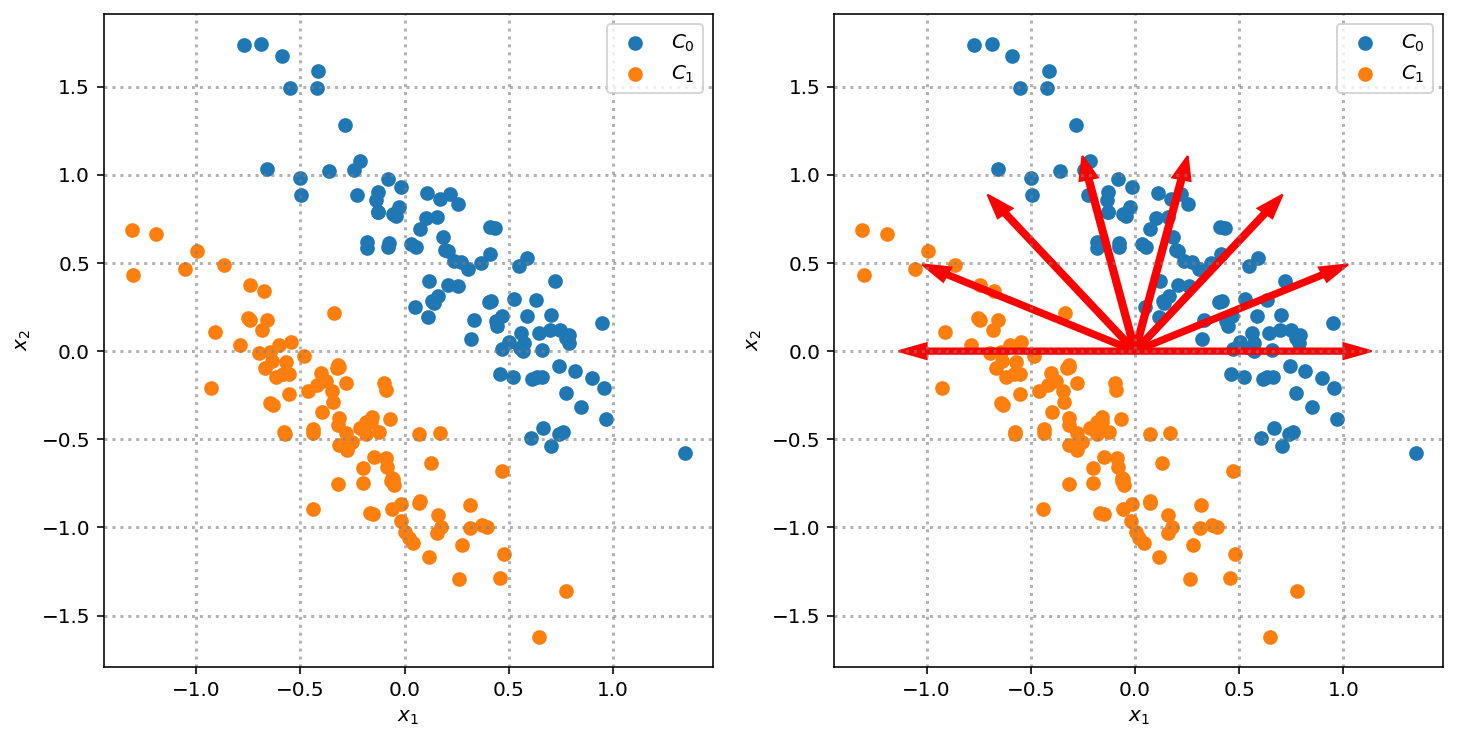

In [4]:
from sklearn.datasets import make_blobs

XX, y_true = make_blobs(n_samples=200, centers=2,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(13)
X_stretched = np.dot(XX, rng.randn(2, 2))

X_stretched -= np.mean(X_stretched,0)

fig, ax = plt.subplots(1,2,figsize=(12, 6))
ax[0].scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_0$')
ax[0].scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_1$')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
ax[0].legend()
v_angle = np.linspace(0,np.pi,8)

ax[1].scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_0$')
ax[1].scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_1$')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
ax[1].grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
ax[1].legend()
for alfa in v_angle:
    ax[1].arrow(0,0,np.cos(alfa), np.sin(alfa),color='red', shape='full',width=.03)

Para cada una de las direcciones de proyección dadas por las flechas rojas, calculamos las proyecciones de los datos originales y evaluamos la separabilidad de las clases en el espacio proyectado mediante la comparación de los histogramas de los valores de las proyecciones de los miembros de cada clase. La zona de **solape de los histogramas representa falta de separabilidad**; si una observación cae en la zona de solape no podemos estar seguros 100% de la clase que debemos asignar a esta observación porque en principio puede ser de cualquiera de las dos clases.

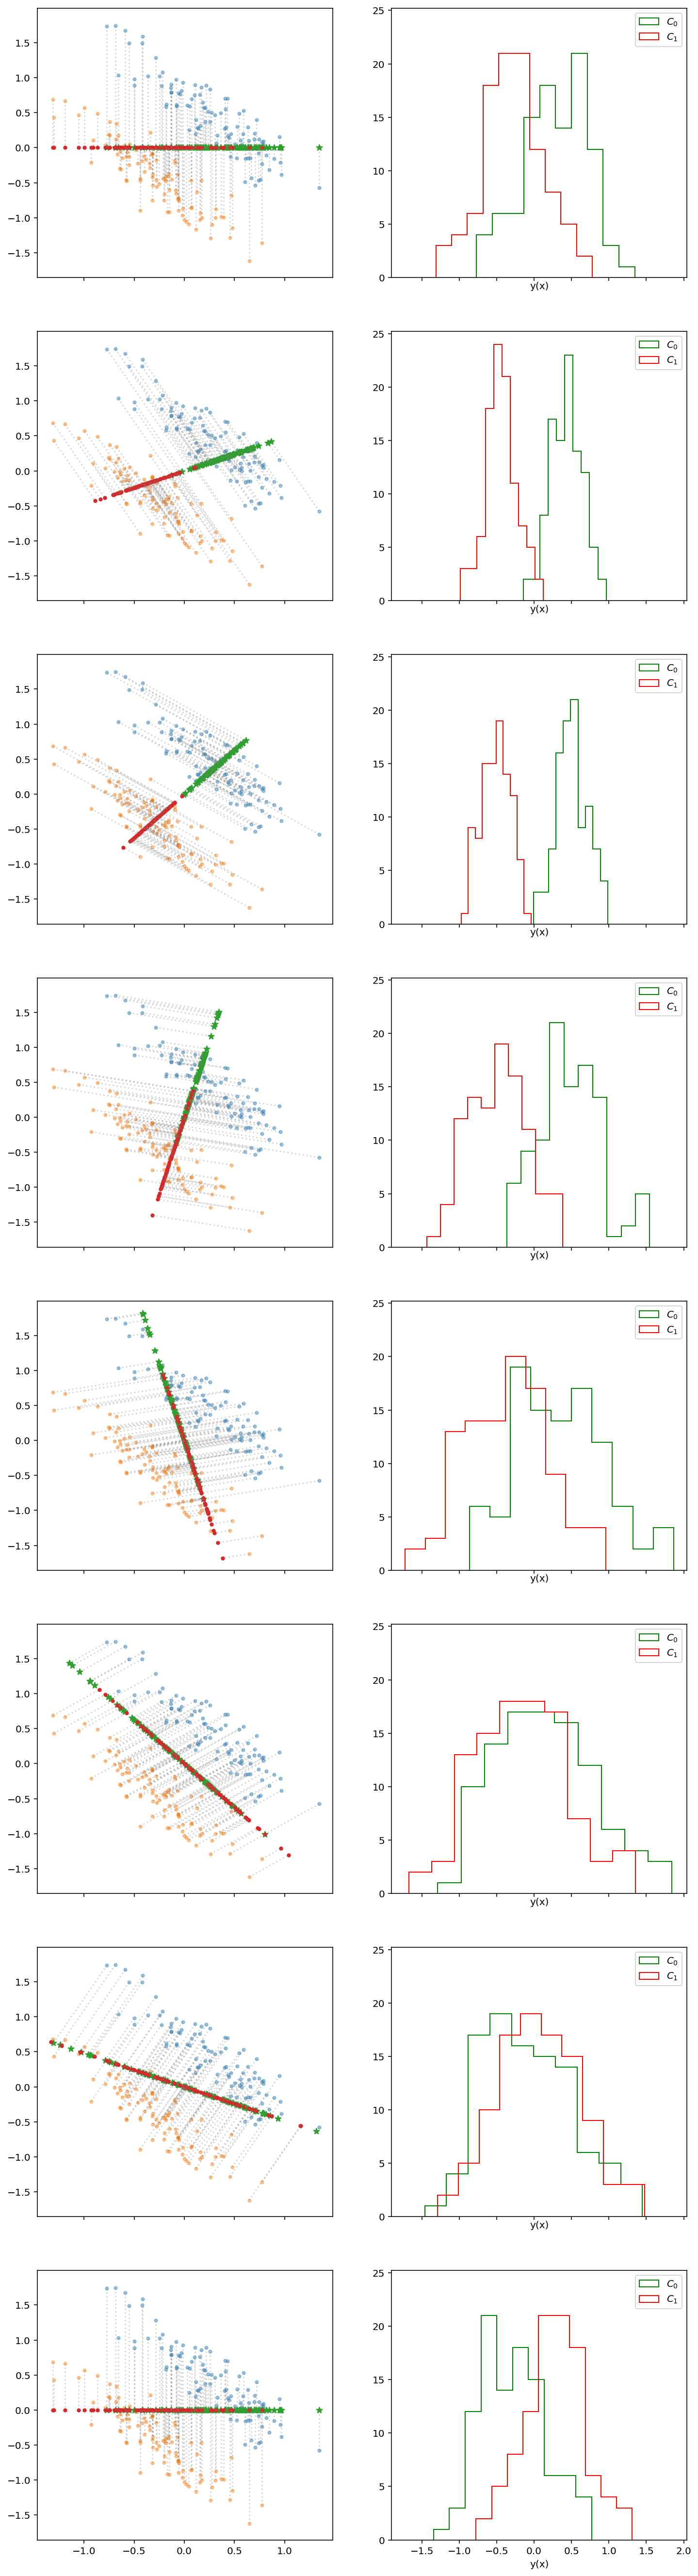

In [5]:
ff,aa = plt.subplots(len(v_angle), 2, sharex='col', sharey='col', figsize=(12,len(v_angle)*6))
for kk in range(len(v_angle)):
    ax = aa[kk][0]
    ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4)
    ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4)

    w = np.array([np.cos(v_angle[kk]),np.sin(v_angle[kk])])
    proj = X_stretched.dot(w)
    Z = np.outer(proj,w)
    ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40)
    ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40)
    for jj in range(Z.shape[0]):
        ax.plot([X_stretched[jj,0], Z[jj,0]],
                 [X_stretched[jj,1], Z[jj,1]],
                  linestyle=':',
                  alpha=0.3, color='gray')

    
    ax = aa[kk][1]
    ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
    ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color = 'red')
    ax.set_xlabel('y(x)')
    ax.legend()    

Una primera aproximación para cuantificar la separabilidad de las clases en el espacio proyectado puede ser medir la separación entre las medias de las clases en el espacio proyectado. El siguiente conjunto de figuras completa las anteriores mostrando las medias de las clases en el espacio reducido mediante estrellas en las figuras de la izquierda y mediante líneas verticales superimpuestas a los histogramas en las figuras de la derecha.

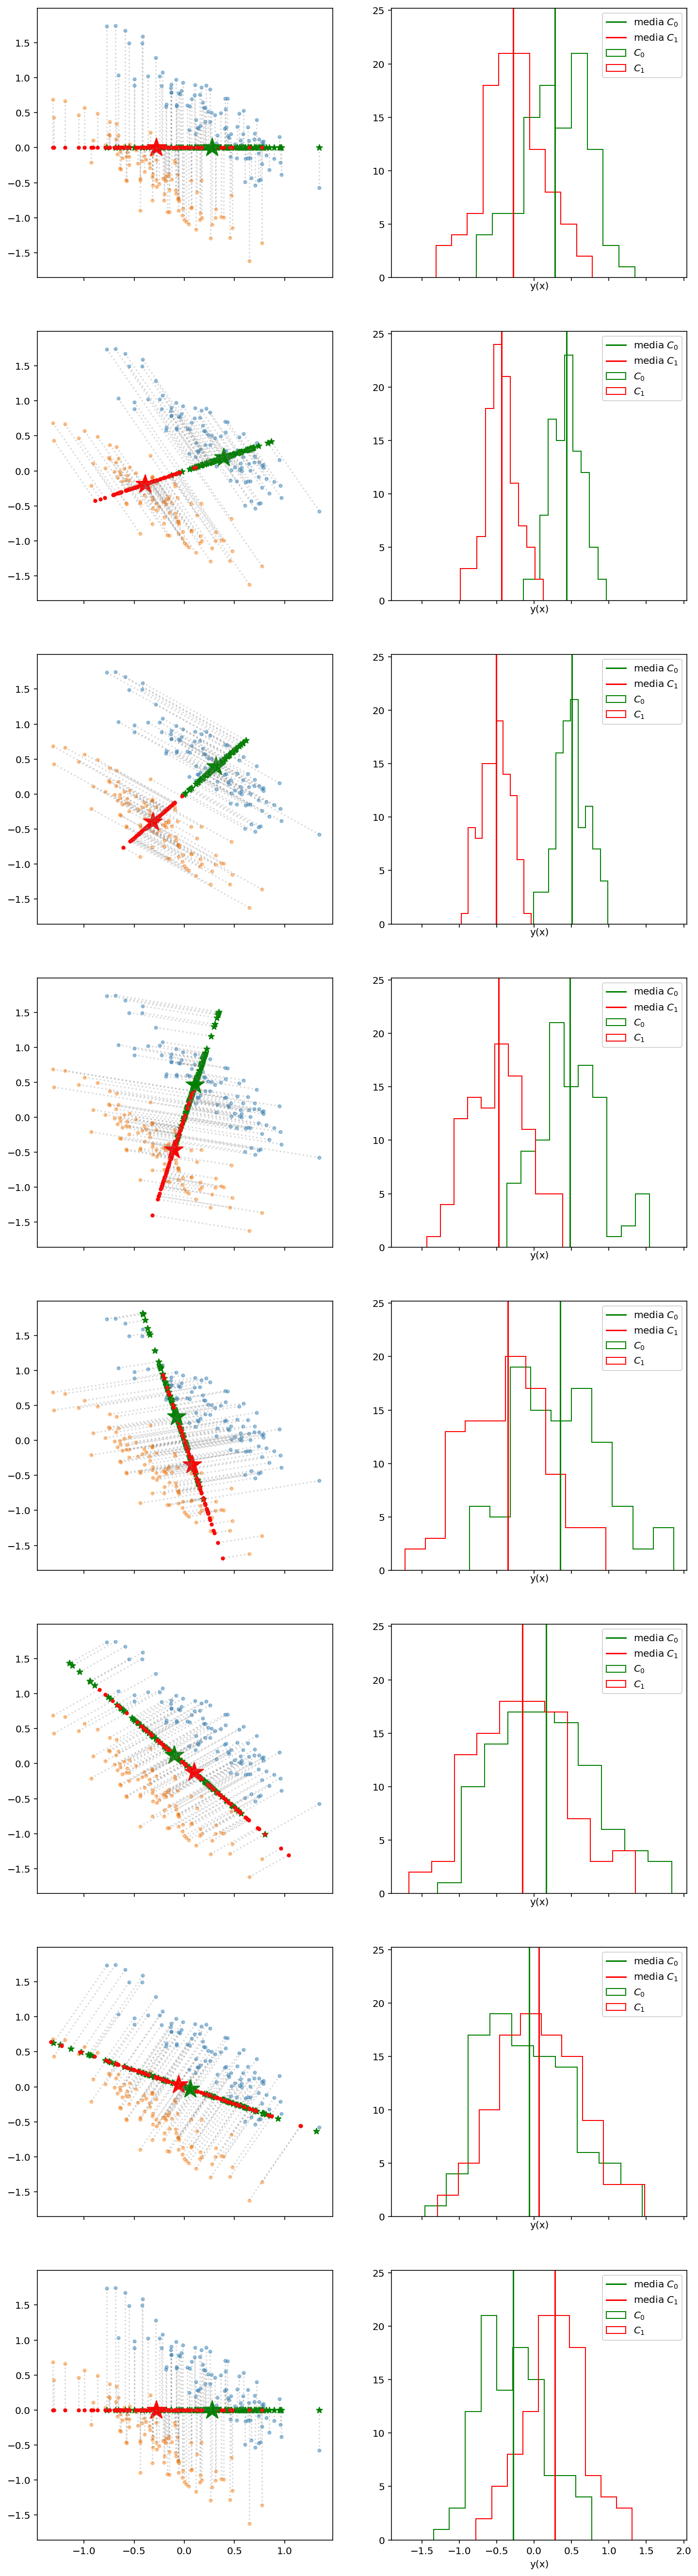

In [6]:
ff,aa = plt.subplots(len(v_angle), 2, sharex='col', sharey='col', figsize=(12,len(v_angle)*6))
for kk in range(len(v_angle)):
    ax = aa[kk][0]
    ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4)
    ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4)

    w = np.array([np.cos(v_angle[kk]),np.sin(v_angle[kk])])
    proj = X_stretched.dot(w)
    Z = np.outer(proj,w)
    ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40, color='green')
    ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40, color ='red')
    ax.scatter(np.mean(Z[y_true==0, 0]), np.mean(Z[y_true==0, 1]), marker='*',  s=400, color='green', label='media $C_0$')
    ax.scatter(np.mean(Z[y_true==1, 0]), np.mean(Z[y_true==1, 1]), marker='*',  s=400, color ='red', label='medida $C_1$')
    
    for jj in range(Z.shape[0]):
        ax.plot([X_stretched[jj,0], Z[jj,0]],
                 [X_stretched[jj,1], Z[jj,1]],
                  linestyle=':',
                  alpha=0.3, color='gray')

    
    ax = aa[kk][1]
    ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
    ax.axvline(x=np.mean(proj[y_true==0]), color='green', label = 'media $C_0$')
    ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color='red')
    ax.axvline(x=np.mean(proj[y_true==1]), color='red', label = 'media $C_1$')
    ax.set_xlabel('y(x)')
    ax.legend()    

Parece que separar las medias de las clases en el espacio proyectado sí contribuye a mejorar la separabilidad de las clases. Si llamamos $m_1$ y $m_0$ a las medias de las clases en el espacio reducido, un criterio de diseño para elegir $\mathbf w$ puede ser

$$
\max_{\mathbf w} m_1 - m_0 = \max_{\mathbf w} \mathbf w^\top(\mathbf m_1 - \mathbf m_0)
$$

donde

$$
\mathbf m_0 = \frac{1}{N_0}\sum_{i \in C_0}{\mathbf x_i }
$$

y 

$$
\mathbf m_1 = \frac{1}{N_1}\sum_{i \in C_1}{\mathbf x_i }
$$


Como vimos para el caso de PCA con la maximización de la varianza en la dirección de los datos proyectados, la separación entre las medias en el espacio proyectado $m_1$ y $m_0$  puede hacerse arbitrariamente grande simplemente escalando la norma de $\mathbf w$. Para evitar esta situación imponemos la restricción de que la norma de $\mathbf w$ sea $1$.

$$
\max_{\mathbf w} m_1 - m_0 = \max_{\mathbf w} \mathbf w^\top(\mathbf m_1 - \mathbf m_0)
$$
sujeto a 
$$
\mathbf w^\top\mathbf w = 1
$$

Usando un multiplicador de Lagrange $\lambda$ para introducir la restricción en el funcional llegamos a 
$$
\max_{\mathbf w} \min_{\lambda}   \mathbf w^\top(\mathbf m_1 - \mathbf m_0) - \lambda (\mathbf w^\top\mathbf w -1)
$$


Tomando gradientes con respecto a $\mathbf w$ e igualando a $\mathbf 0$

$$
(\mathbf m_1 - \mathbf m_0) -2\lambda \mathbf w = 0
$$

Despejando $\mathbf w$:

$$
\mathbf w =  \frac{1}{\lambda} \frac{\mathbf m_1 - \mathbf m_0}{2}
$$

Es decir, la dirección de proyección $\mathbf w$ es proporcional al vector que une las medias de las dos clases en el espacio original. Además, la constante de proporcionalidad tiene que ser la necesaria para que la norma de $\mathbf w$ sea $1$. Es decir

$$
\lambda = \frac{\|\mathbf m_1 - \mathbf m_0\|}{2}
$$

En el ejemplo en 2D con el que estamos trabajando:

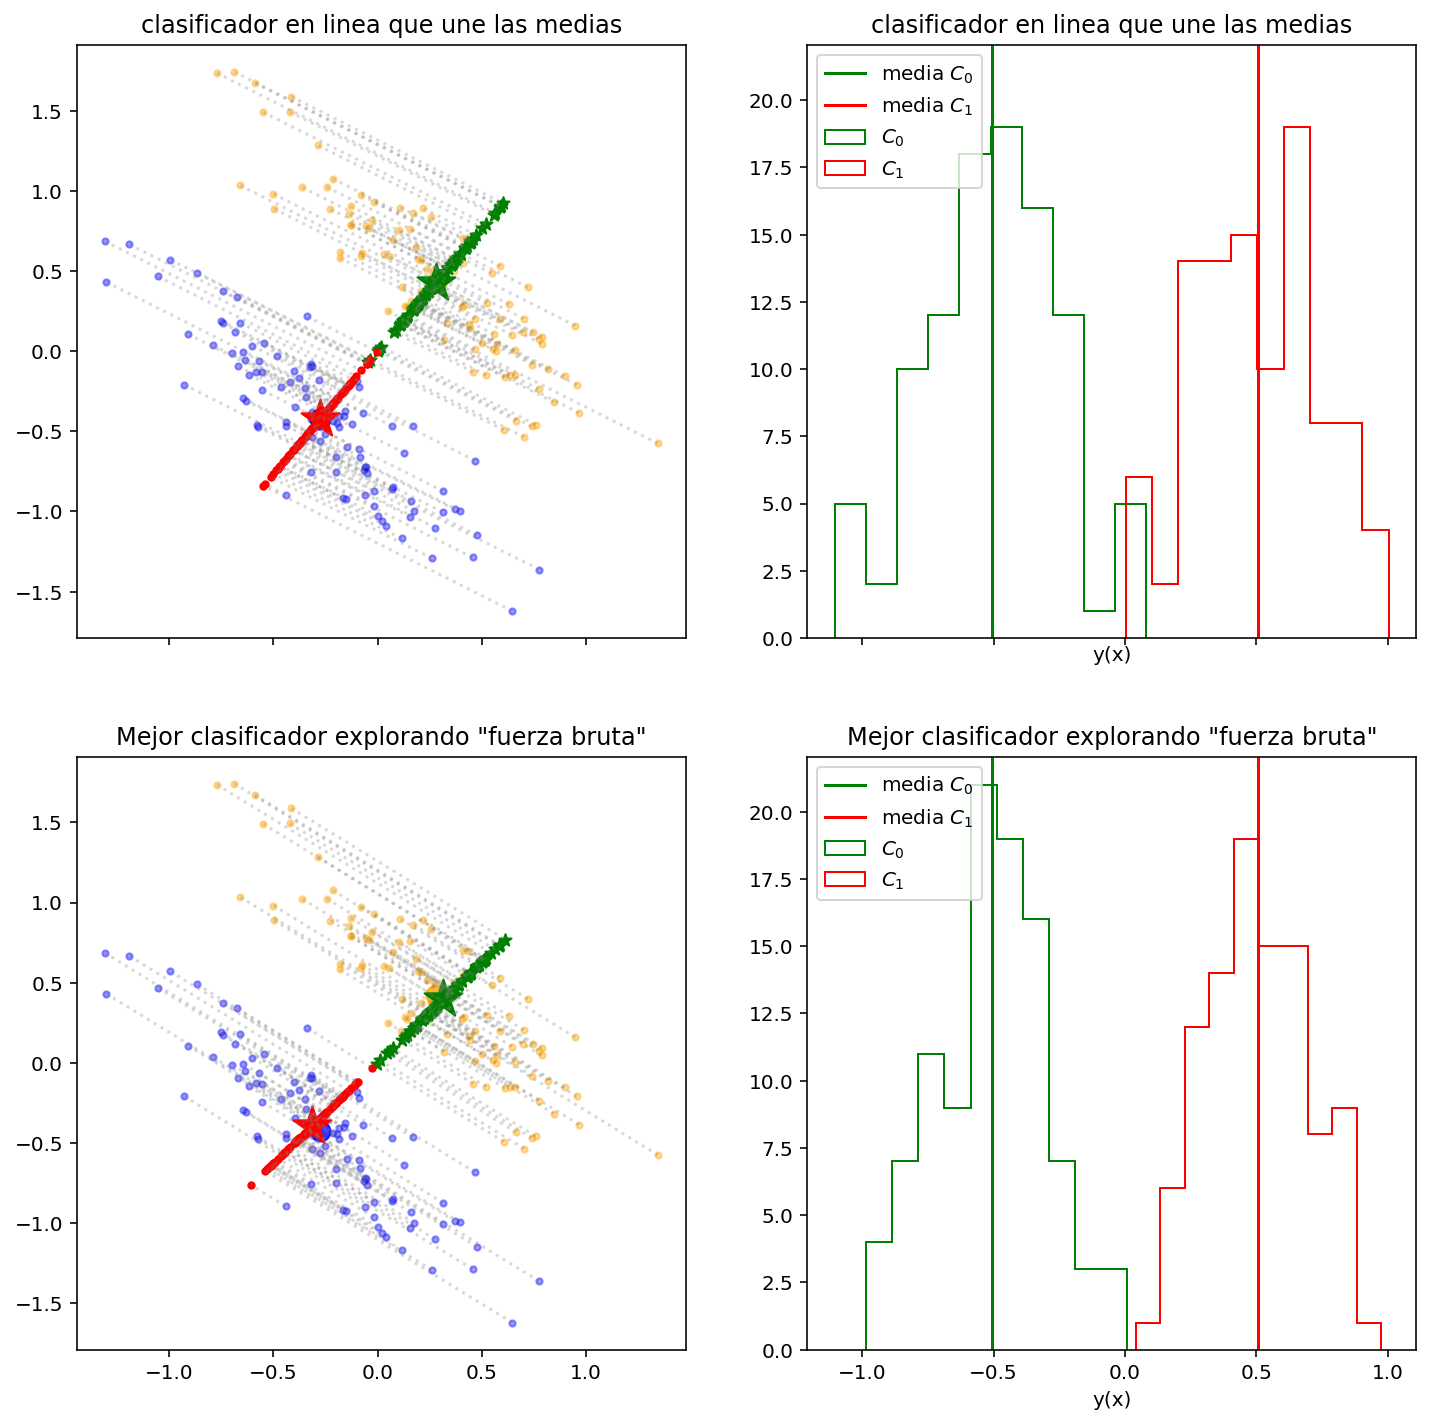

In [7]:
ff,aa = plt.subplots(2, 2, sharex='col', sharey='col', figsize=(12,2*6))
kk=0
ax = aa[kk][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4, color='orange')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4, color='blue')
ax.scatter(np.mean(X_stretched[y_true==0, 0]), np.mean(X_stretched[y_true==0, 1]), marker='.', s=400, alpha=0.8, color='orange', label='media $C_0$')
ax.scatter(np.mean(X_stretched[y_true==1, 0]), np.mean(X_stretched[y_true==1, 1]), marker='.', s=400, alpha=0.8, color='blue', label='medida $C_1$')

w1 = 0.5*np.array([np.mean(X_stretched[y_true==1, 0]) - np.mean(X_stretched[y_true==0, 0]),
                  np.mean(X_stretched[y_true==1, 1]) - np.mean(X_stretched[y_true==0, 1]) ])
w = w1 / np.linalg.norm(w1)
proj = X_stretched.dot(w)
Z = np.outer(proj,w)
ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40, color='green')
ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40, color ='red')
ax.scatter(np.mean(Z[y_true==0, 0]), np.mean(Z[y_true==0, 1]), marker='*',  s=400, color='green', label='media $C_0$')
ax.scatter(np.mean(Z[y_true==1, 0]), np.mean(Z[y_true==1, 1]), marker='*',  s=400, color ='red', label='medida $C_1$')

for jj in range(Z.shape[0]):
    ax.plot([X_stretched[jj,0], Z[jj,0]],
             [X_stretched[jj,1], Z[jj,1]],
              linestyle=':',
              alpha=0.3, color='gray')

ax.set_title('clasificador en linea que une las medias')
    
ax = aa[kk][1]
ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
ax.axvline(x=np.mean(proj[y_true==0]), color='green', label = 'media $C_0$')
ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color='red')
ax.axvline(x=np.mean(proj[y_true==1]), color='red', label = 'media $C_1$')
ax.set_xlabel('y(x)')
ax.legend()  
ax.set_title('clasificador en linea que une las medias')
kk = 1

ax = aa[kk][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4, color='orange')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4, color='blue')
ax.scatter(np.mean(X_stretched[y_true==0, 0]), np.mean(X_stretched[y_true==0, 1]), marker='.', s=400, alpha=0.8, color='orange', label='media $C_0$')
ax.scatter(np.mean(X_stretched[y_true==1, 0]), np.mean(X_stretched[y_true==1, 1]), marker='.', s=400, alpha=0.8, color='blue', label='medida $C_1$')

w = -np.array([np.cos(v_angle[2]),np.sin(v_angle[2])])
proj = X_stretched.dot(w)
Z = np.outer(proj,w)
ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40, color='green')
ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40, color ='red')
ax.scatter(np.mean(Z[y_true==0, 0]), np.mean(Z[y_true==0, 1]), marker='*',  s=400, color='green', label='media $C_0$')
ax.scatter(np.mean(Z[y_true==1, 0]), np.mean(Z[y_true==1, 1]), marker='*',  s=400, color ='red', label='medida $C_1$')

for jj in range(Z.shape[0]):
    ax.plot([X_stretched[jj,0], Z[jj,0]],
             [X_stretched[jj,1], Z[jj,1]],
              linestyle=':',
              alpha=0.3, color='gray')

ax.set_title('Mejor clasificador explorando "fuerza bruta"')
ax = aa[kk][1]
ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
ax.axvline(x=np.mean(proj[y_true==0]), color='green', label = 'media $C_0$')
ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color='red')
ax.axvline(x=np.mean(proj[y_true==1]), color='red', label = 'media $C_1$')
ax.set_xlabel('y(x)')
_=ax.legend()  
_=ax.set_title('Mejor clasificador explorando "fuerza bruta"')


En la figura de arriba comprobamos que hay direcciones que consiguen una mejor separabilidad que la lograda por la línea que separa las medias.

Observando los histogramas podemos comprobar que si bien en los dos espacios reducidos las medias están más o menos igual de separadas, las varianzas de las clases son más compactas en el caso del mejor clasificador explorando por *fuerza bruta*. Esto sucede por la fuerte covarianza presente en los datos de cada clase (la matriz de covarianzas no es diagonal por bastante). 

El clasificador de Fisher propone complementar la función objetivo del optimizador **añadiendo como requisito minimizar la varianza de cada una de las clases en el espacio proyectado**.

La razón de este objetivo complementario es que separar las medias es tanto mejor *proxy* para la separabilidad de las clases **cuanto más compactas** sean las distribuciones de las observaciones de cada clase alrededor de su correspondiente media. Claramente en el segundo plot la separabilidad es debida a la compacidad de estas distribuciones.

La varianza de cada clase en el espacio proyectado es proporcional a 

$$
s_0^2 = \sum_{i\in C_0}{(y(\mathbf x_i)-m_0)^2} = \sum_{i\in C_0}{(\mathbf w^\top\mathbf x_i-m_0)^2}
$$

$$
s_1^2 = \sum_{i\in C_1}{(y(\mathbf x_i)-m_1)^2} = \sum_{i\in C_1}{(\mathbf w^\top\mathbf x_i-m_1)^2}
$$



Una manera inmediata de añadir la compacidad de las varianzas en el espacio proyectado es proponer la siguiente optimización para encontrar el vector de proyección:

$$
\max_{\mathbf w} J(\mathbf w) = \frac{ (m_1 - m_0)^2 }{s_0^2 + s_1^2}
$$
sujeto a 
$$
\mathbf w^\top\mathbf w = 1
$$

Introducimos explícitamente la dependencia con $\mathbf w$

$$
\max_{\mathbf w} J(\mathbf w) = \frac{ (m_1 - m_0)^2 }{s_0^2 + s_1^2} = \frac{ \mathbf w^\top(\mathbf m_1 - \mathbf m_0)(\mathbf m_1 - \mathbf m_0)^\top \mathbf w }{\sum_{i\in C_0}{\mathbf w^\top(\mathbf x_i - \mathbf m_0)(\mathbf x_i - \mathbf m_0)^\top \mathbf w} + \sum_{i\in C_1}{\mathbf w^\top(\mathbf x_i - \mathbf m_1)(\mathbf x_i - \mathbf m_1)^\top \mathbf w}}
$$

$$
 = \max_{\mathbf w} \frac{ \mathbf w^\top(\mathbf m_1 - \mathbf m_0)(\mathbf m_1 - \mathbf m_0)^\top \mathbf w }{\mathbf w^\top \left (\sum_{i\in C_0}{(\mathbf x_i - \mathbf m_0)(\mathbf x_i - \mathbf m_0)^\top } + \sum_{i\in C_1}{(\mathbf x_i - \mathbf m_1)(\mathbf x_i - \mathbf m_1)^\top }\right)\mathbf w}
$$

El numerador se escribe en forma más compacta como

$$
\mathbf w^\top(\mathbf m_1 - \mathbf m_0)(\mathbf m_1 - \mathbf m_0)^\top \mathbf w = \mathbf w^\top S_B\mathbf w
$$

donde $S_B = (\mathbf m_1 - \mathbf m_0)(\mathbf m_1 - \mathbf m_0)^\top $ es la **matriz de covarianzas entre clases**, es decir, las covarianzas de las medias.

El denominador también se escribe en una forma más compacta como:

$$
\mathbf w^\top \left (\sum_{i\in C_0}{(\mathbf x_i - \mathbf m_0)(\mathbf x_i - \mathbf m_0)^\top } + \sum_{i\in C_1}{(\mathbf x_i - \mathbf m_1)(\mathbf x_i - \mathbf m_1)^\top }\right)\mathbf w = \mathbf w^\top S_W \mathbf w
$$

donde 

$$
S_W = \sum_{i\in C_0}{(\mathbf x_i - \mathbf m_0)(\mathbf x_i - \mathbf m_0)^\top } + \sum_{i\in C_1}{(\mathbf x_i - \mathbf m_1)(\mathbf x_i - \mathbf m_1)^\top }
$$

se denomina **matriz de covarianzas intraclase** pues es la suma de las matrices de covarianza de cada una de las clases.

Con esta notación compacta el problema de optimización queda expresado así:

$$
\max_{\mathbf w} J(\mathbf w) = \frac{\mathbf w^\top S_B\mathbf w }{\mathbf w^\top S_W \mathbf w}
$$
sujeto a 
$$
\mathbf w^\top\mathbf w = 1
$$

Tomando gradientes con respecto a $\mathbf w$ e igualando a cero

$$
\frac{2S_B\mathbf w (\mathbf w^\top S_W \mathbf w) - 2S_W \mathbf w (\mathbf w^\top S_B\mathbf w)}{(\mathbf w^\top S_W \mathbf w)^2} = 0
$$

$$
\Rightarrow S_B\mathbf w (\mathbf w^\top S_W \mathbf w) = S_W \mathbf w (\mathbf w^\top S_B\mathbf w) \Rightarrow S_B\mathbf w = \frac{(\mathbf w^\top S_B\mathbf w)}{(\mathbf w^\top S_W \mathbf w)}S_W \mathbf w 
$$

El término $\frac{(\mathbf w^\top S_B\mathbf w)}{(\mathbf w^\top S_W \mathbf w)}$ es un escalar. Como realmente estamos **interesados en la dirección** de $\mathbf w$, y no en su tamaño, podemos cambiar ese término por una constante $c$

$$
\Rightarrow S_B\mathbf w (\mathbf w^\top S_W \mathbf w) = S_W \mathbf w (\mathbf w^\top S_B\mathbf w) \Rightarrow S_B\mathbf w = c S_W \mathbf w 
$$

Multiplicando ambos lados por $S_W^{-1}$

$$
S_W^{-1} S_B\mathbf w = c\mathbf w
$$

Retomando la definición de $S_B$:

$$
S_B\mathbf w = (\mathbf m_1 - \mathbf m_0)(\mathbf m_1 - \mathbf m_0)^\top \mathbf w = \beta (\mathbf m_1 - \mathbf m_0)
$$

Es decir, $S_B\mathbf w$ es un vector en la dirección dada por el vector que une las medias de las clases $(\mathbf m_1 - \mathbf m_0)$ con una cierta norma $\beta$, pero como realmente estamos interesados en la dirección de $\mathbf w$, no hace falta que detallemos el valor de $\beta$. Introduciendo este resultado en la ecuación principal llegamos a

$$
\beta^{\prime}S_W^{-1}(\mathbf m_1 - \mathbf m_0)  = \mathbf w
$$

Es decir, la dirección de proyección que buscamos está **definida por un vector unitario** $\mathbf w$ en la dirección dada por $S_W^{-1}(\mathbf m_1 - \mathbf m_0)$.

Esta dirección de proyección es la del **clasificador de Fisher**. Hay que reseñar que el clasificador debe **completarse con el umbral** $w_0$. Es decir, que una vez que estén proyectados los datos a lo largo de $\mathbf w$ hay que establecer el valor $w_0$ tal que si $\mathbf w^\top \mathbf x > -w_0$ asignemos $\mathbf x$ a la clase $C_1$ y se lo asignemos a $C_0$ si $\mathbf w^\top \mathbf x < - w_0$.


Continuando con el ejemplo bidimensional que hemos visto antes

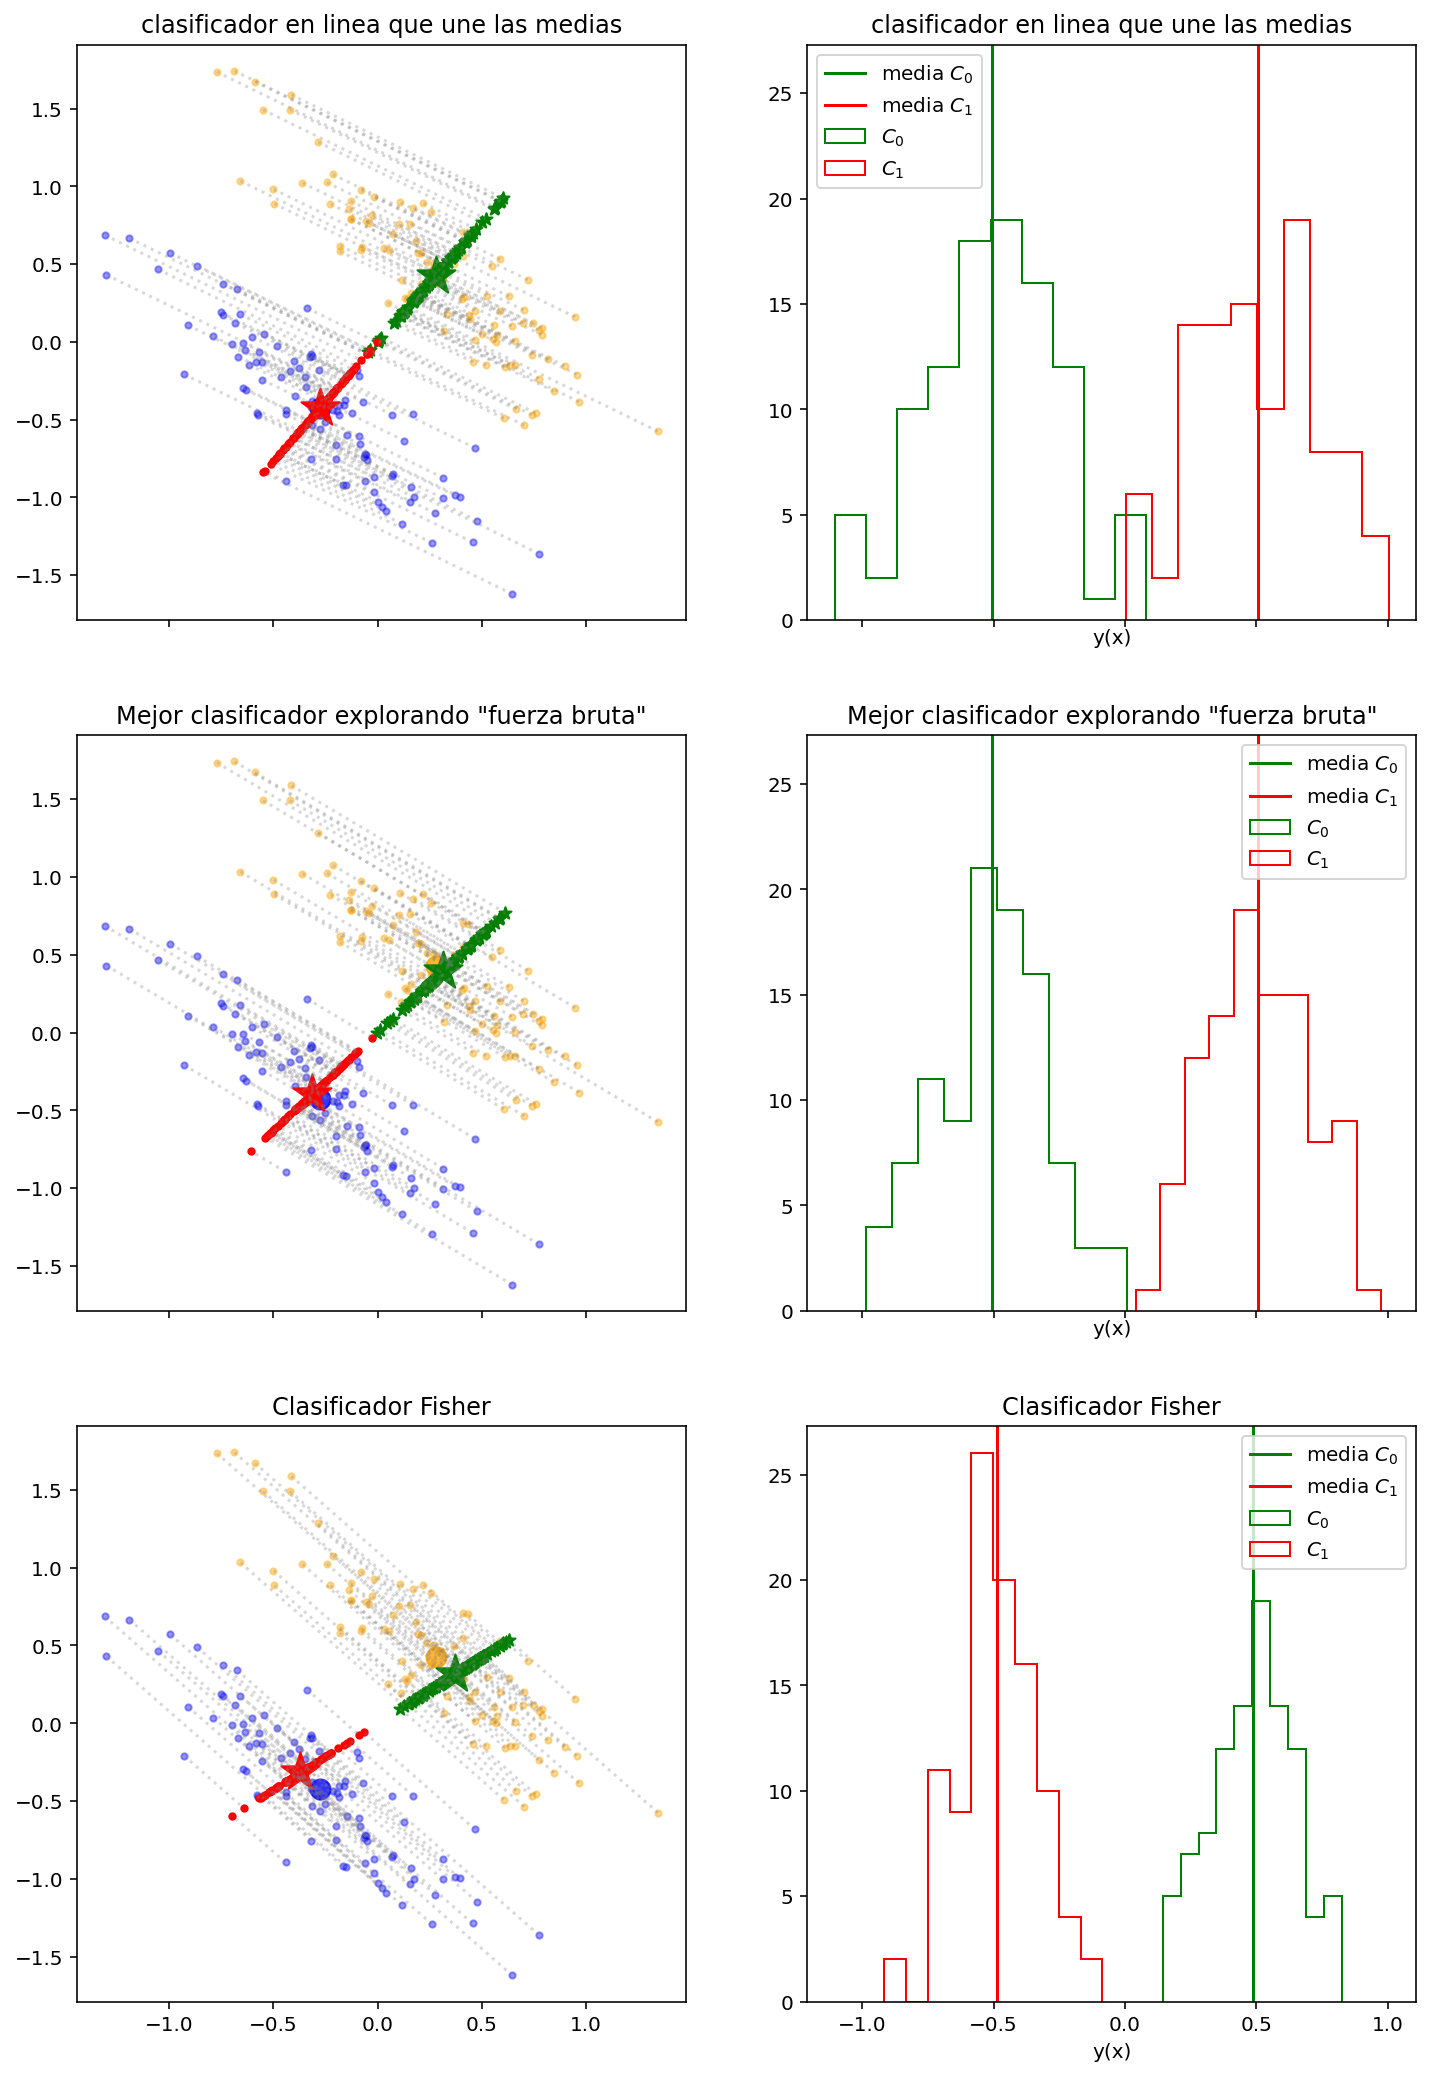

In [8]:
ff,aa = plt.subplots(3, 2, sharex='col', sharey='col', figsize=(12,3*6))
kk=0
ax = aa[kk][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4, color='orange')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4, color='blue')
ax.scatter(np.mean(X_stretched[y_true==0, 0]), np.mean(X_stretched[y_true==0, 1]), marker='.', s=400, alpha=0.8, color='orange', label='media $C_0$')
ax.scatter(np.mean(X_stretched[y_true==1, 0]), np.mean(X_stretched[y_true==1, 1]), marker='.', s=400, alpha=0.8, color='blue', label='medida $C_1$')

w1 = 0.5*np.array([np.mean(X_stretched[y_true==1, 0]) - np.mean(X_stretched[y_true==0, 0]),
                  np.mean(X_stretched[y_true==1, 1]) - np.mean(X_stretched[y_true==0, 1]) ])
w = w1 / np.linalg.norm(w1)
proj = X_stretched.dot(w)
Z = np.outer(proj,w)
ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40, color='green')
ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40, color ='red')
ax.scatter(np.mean(Z[y_true==0, 0]), np.mean(Z[y_true==0, 1]), marker='*',  s=400, color='green', label='media $C_0$')
ax.scatter(np.mean(Z[y_true==1, 0]), np.mean(Z[y_true==1, 1]), marker='*',  s=400, color ='red', label='medida $C_1$')

for jj in range(Z.shape[0]):
    ax.plot([X_stretched[jj,0], Z[jj,0]],
             [X_stretched[jj,1], Z[jj,1]],
              linestyle=':',
              alpha=0.3, color='gray')

ax.set_title('clasificador en linea que une las medias')
    
ax = aa[kk][1]
ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
ax.axvline(x=np.mean(proj[y_true==0]), color='green', label = 'media $C_0$')
ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color='red')
ax.axvline(x=np.mean(proj[y_true==1]), color='red', label = 'media $C_1$')
ax.set_xlabel('y(x)')
ax.legend()  
ax.set_title('clasificador en linea que une las medias')

kk = 1

ax = aa[kk][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4, color='orange')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4, color='blue')
ax.scatter(np.mean(X_stretched[y_true==0, 0]), np.mean(X_stretched[y_true==0, 1]), marker='.', s=400, alpha=0.8, color='orange', label='media $C_0$')
ax.scatter(np.mean(X_stretched[y_true==1, 0]), np.mean(X_stretched[y_true==1, 1]), marker='.', s=400, alpha=0.8, color='blue', label='medida $C_1$')

w = -np.array([np.cos(v_angle[2]),np.sin(v_angle[2])])
proj = X_stretched.dot(w)
Z = np.outer(proj,w)
ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40, color='green')
ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40, color ='red')
ax.scatter(np.mean(Z[y_true==0, 0]), np.mean(Z[y_true==0, 1]), marker='*',  s=400, color='green', label='media $C_0$')
ax.scatter(np.mean(Z[y_true==1, 0]), np.mean(Z[y_true==1, 1]), marker='*',  s=400, color ='red', label='medida $C_1$')

for jj in range(Z.shape[0]):
    ax.plot([X_stretched[jj,0], Z[jj,0]],
             [X_stretched[jj,1], Z[jj,1]],
              linestyle=':',
              alpha=0.3, color='gray')

ax.set_title('Mejor clasificador explorando "fuerza bruta"')
ax = aa[kk][1]
ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
ax.axvline(x=np.mean(proj[y_true==0]), color='green', label = 'media $C_0$')
ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color='red')
ax.axvline(x=np.mean(proj[y_true==1]), color='red', label = 'media $C_1$')
ax.set_xlabel('y(x)')
_=ax.legend()  
_=ax.set_title('Mejor clasificador explorando "fuerza bruta"')


kk = 2

ax = aa[kk][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1], marker='.', s=40, alpha=0.4, color='orange')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1], marker='.', s=40, alpha=0.4, color='blue')
ax.scatter(np.mean(X_stretched[y_true==0, 0]), np.mean(X_stretched[y_true==0, 1]), marker='.', s=400, alpha=0.8, color='orange', label='media $C_0$')
ax.scatter(np.mean(X_stretched[y_true==1, 0]), np.mean(X_stretched[y_true==1, 1]), marker='.', s=400, alpha=0.8, color='blue', label='medida $C_1$')

X0 = X_stretched[y_true==0,:]
m0 = np.mean(X_stretched[y_true==0,:],0)
s0 = (X0 - m0).T.dot(X0 - m0)

X1 = X_stretched[y_true==1,:]
m1 = np.mean(X_stretched[y_true==1,:],0)
s1 = (X1 - m1).T.dot(X1 - m1)

Sw = s0 + s1

w1 = -np.linalg.inv(Sw).dot((m1 - m0).T)
w = w1 / np.linalg.norm(w1)
proj = X_stretched.dot(w)
Z = np.outer(proj,w)
ax.scatter(Z[y_true==0, 0], Z[y_true==0, 1], marker='*',  s=40, color='green')
ax.scatter(Z[y_true==1, 0], Z[y_true==1, 1], marker='.',  s=40, color ='red')
ax.scatter(np.mean(Z[y_true==0, 0]), np.mean(Z[y_true==0, 1]), marker='*',  s=400, color='green', label='media $C_0$')
ax.scatter(np.mean(Z[y_true==1, 0]), np.mean(Z[y_true==1, 1]), marker='*',  s=400, color ='red', label='medida $C_1$')

for jj in range(Z.shape[0]):
    ax.plot([X_stretched[jj,0], Z[jj,0]],
             [X_stretched[jj,1], Z[jj,1]],
              linestyle=':',
              alpha=0.3, color='gray')

ax.set_title('Clasificador Fisher')
ax = aa[kk][1]
ax.hist(proj[y_true==0],10,histtype='step', label='$C_0$', color='green')
ax.axvline(x=np.mean(proj[y_true==0]), color='green', label = 'media $C_0$')
ax.hist(proj[y_true==1],10,histtype='step', label='$C_1$', color='red')
ax.axvline(x=np.mean(proj[y_true==1]), color='red', label = 'media $C_1$')
ax.set_xlabel('y(x)')
_=ax.legend()  
_=ax.set_title('Clasificador Fisher')


## Clasificador lineal de Fisher en Scikit Learn

La clase [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) implementa el clasificador lineal de Fisher en sklearn.

Para representar las líneas de nivel empleamos el método `decision_function` ($y(\mathbf x)$ antes de pasar por el umbral que nos da la predicción).

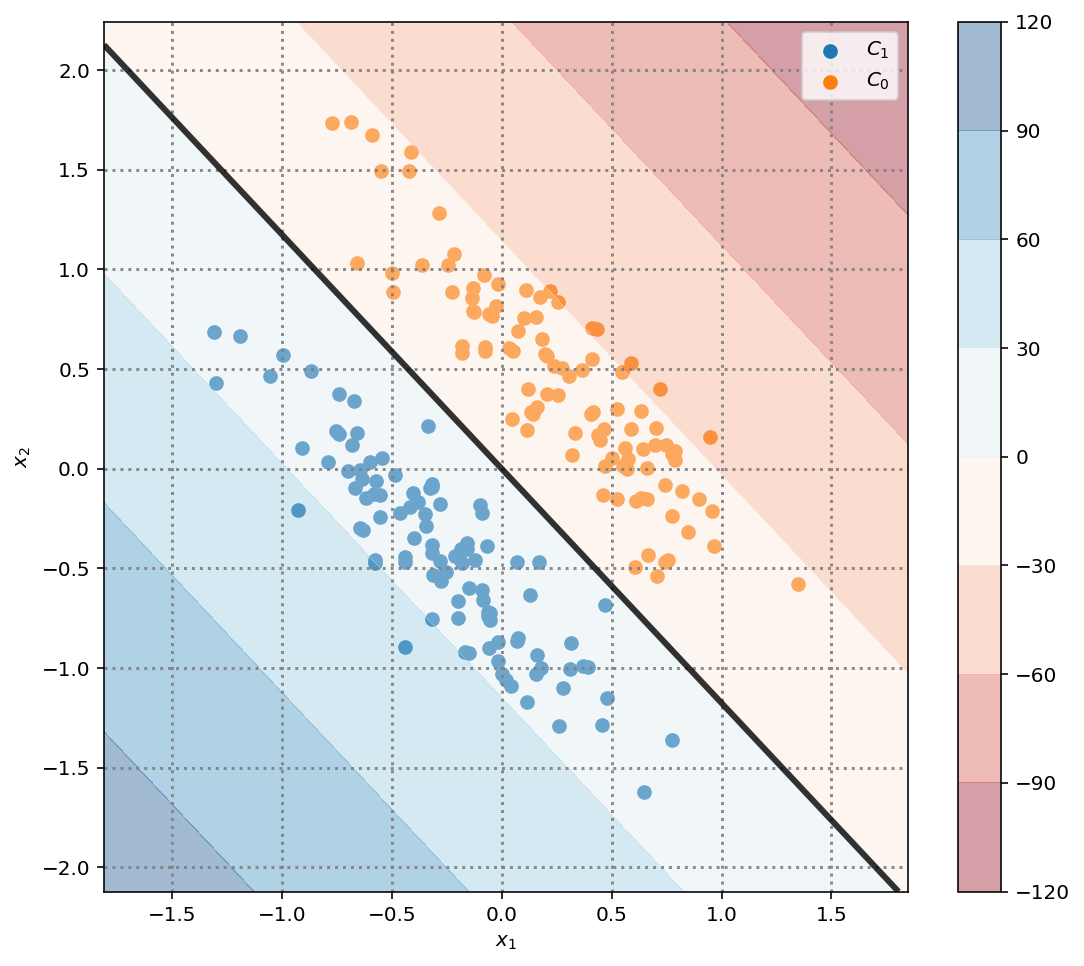

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib.colors import ListedColormap

clf = LinearDiscriminantAnalysis()
clf.fit(X_stretched, y_true)


cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

fig, ax = plt.subplots(1,1,figsize=(9, 8))
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_1$')
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_0$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.9, linestyle='dotted', lw=1.5)
_=ax.legend()

h=100
x_min, x_max = X_stretched[:, 0].min() - .5, X_stretched[:, 0].max() + .5
y_min, y_max = X_stretched[:, 1].min() - .5, X_stretched[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                        np.linspace(y_min, y_max, h))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.4)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)

## Clasificador de Fisher binario en la base de datos de dígitos manuscritos

Vamos a probar el clasificador de Fisher con datos reales. Para ganar intuiciones de sus diferencias con PCA usaremos el conjunto de datos de dígitos manuscritos con el que estuvimos trabajando en el otro notebook sobre MVA.

Los problemas binarios que vamos a resolver son:
- separar los unos de los cincos 
- separar los cincos de los seises
- separar los dígitos pares de los impares

In [10]:
data = np.loadtxt("mnist_test.csv", 
                       delimiter=",") 
fac = 0.99 / 255
X=np.asfarray(data[:, 1:]) * fac + 0.01
Y = np.array([int(cc) for cc in data[:, :1]])
print("Cargados {0:d} dígitos".format(X.shape[0]))
print("")
for cc in range(10):
    print("El dígito {0:d} tiene {1:d} ejemplos".format(cc,np.sum(Y==cc)))

Cargados 10000 dígitos

El dígito 0 tiene 980 ejemplos
El dígito 1 tiene 1135 ejemplos
El dígito 2 tiene 1032 ejemplos
El dígito 3 tiene 1010 ejemplos
El dígito 4 tiene 982 ejemplos
El dígito 5 tiene 892 ejemplos
El dígito 6 tiene 958 ejemplos
El dígito 7 tiene 1028 ejemplos
El dígito 8 tiene 974 ejemplos
El dígito 9 tiene 1009 ejemplos


In [11]:
cincos = np.where(Y==5)[0]
seis = np.where(Y==6)[0]
unos = np.where(Y==1)[0] 

### 5 vs 1

En primer lugar clasificamos con en el espacio reducido propuesto por PCA con dos componentes. Para ello las celdas siguientes:
- Aprenden un PCA con `n_components=2`
- Aprenden un clasificador lineal en el espacio reducido, usando `LinearDiscriminantAnalysis`

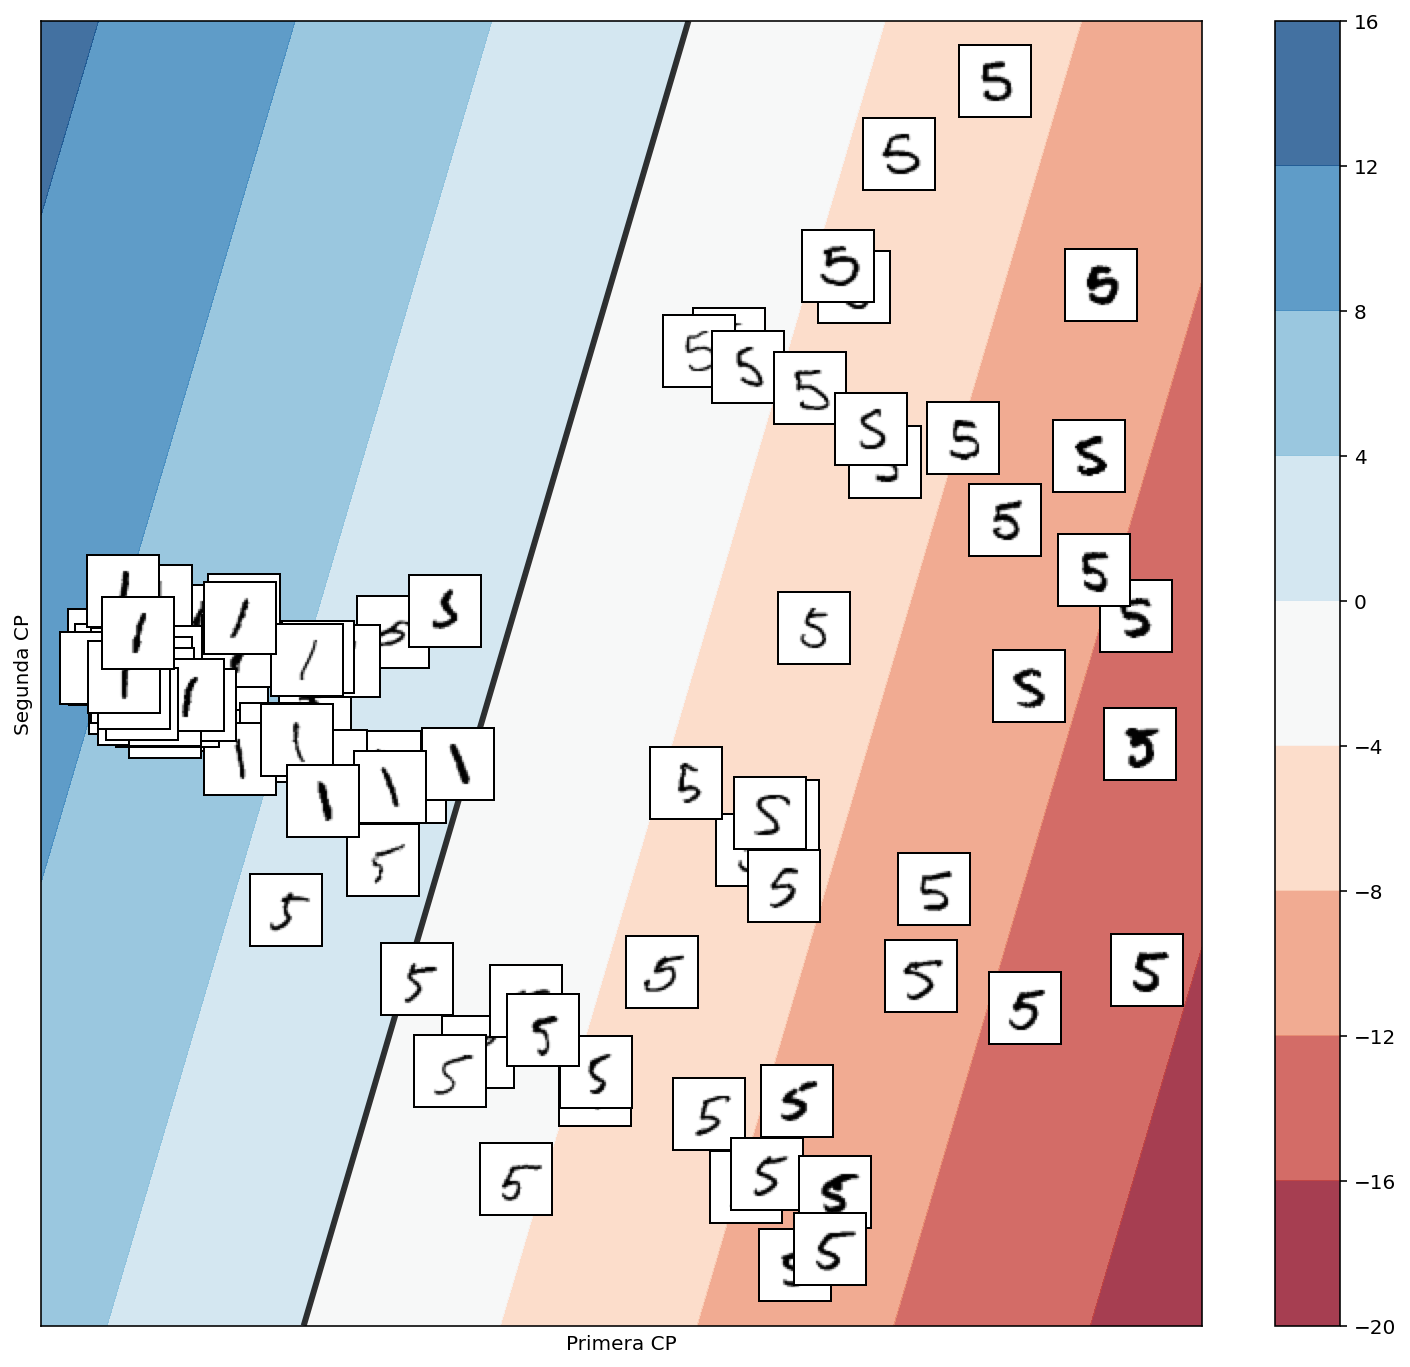

In [12]:
from sklearn.decomposition import PCA
X51 = np.vstack((X[cincos[:50],:], X[unos[:50],:]))
Y51 = np.ones((X51.shape[0]))
Y51[:50] = -1
ff,ax=plt.subplots(1,1,figsize=(13,12))
pca51 = PCA(n_components=2)
Z51=pca51.fit_transform(X51)
plot_embedding(ax, Z51, X51)

lda_pca51 = LinearDiscriminantAnalysis()
lda_pca51.fit(Z51, Y51)
h=100
x_min, x_max = Z51[:, 0].min() - .5, Z51[:, 0].max() + .5
y_min, y_max = Z51[:, 1].min() - .5, Z51[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                        np.linspace(y_min, y_max, h))
Z = lda_pca51.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)

La siguente celda aplica directamente `LinearDiscriminantAnalysis` en el espacio original (de $28\times 28$) dimensiones.

In [13]:
lda51 = LinearDiscriminantAnalysis()
lda51.fit(X51, Y51)
U51 = lda51.transform(X51)

En un problema binario `LinearDiscriminantAnalysis` encuentra un espacio reducido de una única dimensión. Para poder visualizar dígitos en 2 dimensiones en la figura de abajo la componente vertical es aleatoria. 

Vemos cómo en el espacio reducido los 5s tienen menos variabilidad que los 1s. En la figura de arriba, donde el espacio reducido estaba orientado a la reconstrucción, los 5s tienen bastante más variabilidad que los 1s. Esto quiere decir que para distinguir un 5 de un 1 es más fácil desde el lado de los 5s.

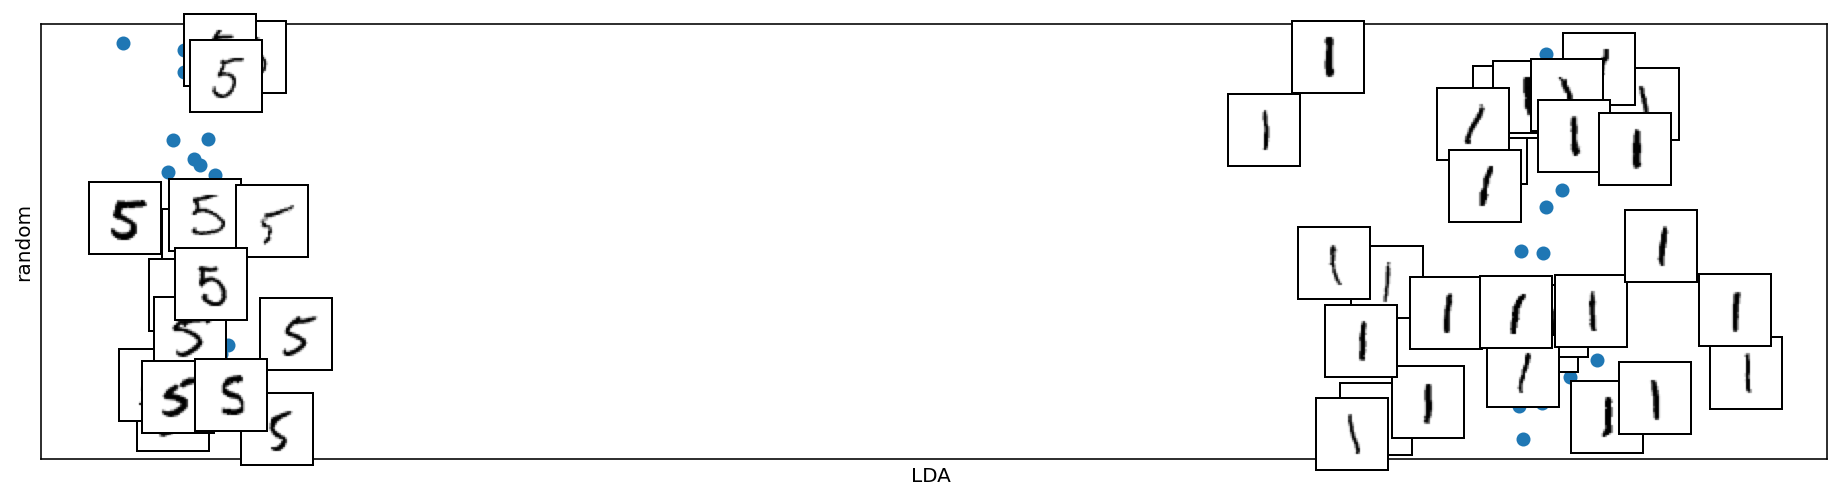

In [14]:
ff,aa = plt.subplots(1,1,figsize=(16,4))
plot_embedding(aa,np.vstack((U51.ravel(), 0.02*np.random.rand(U51.shape[0]))).T, 
                   X51,
                  xlabel='LDA ', 
                  ylabel='random')

### 5 vs 6

Repetimos el experimento con ejemplos de 5s y de 6s

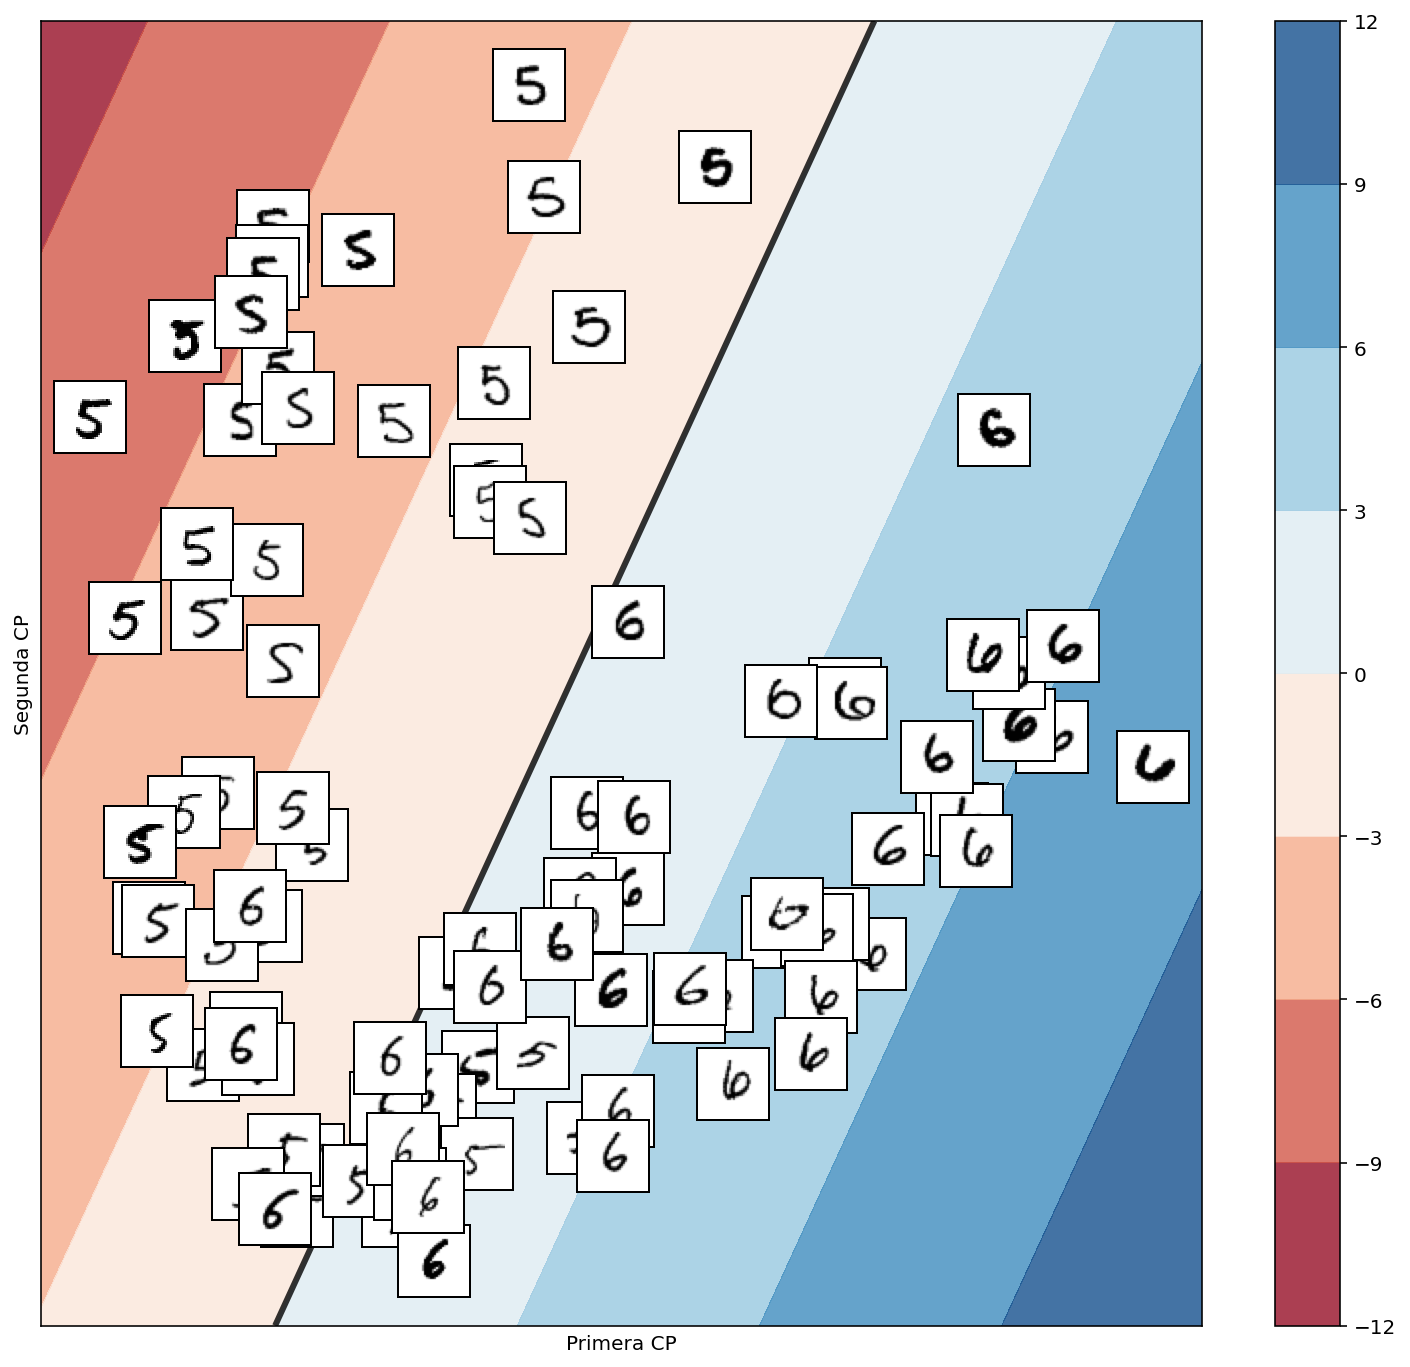

In [15]:
X56 = np.vstack((X[cincos[:50],:], X[seis[:50],:]))
Y56 = np.ones((X51.shape[0]))
Y56[:50] = -1
ff,ax=plt.subplots(1,1,figsize=(13,12))
pca56 = PCA(n_components=2)
Z56=pca56.fit_transform(X56)
plot_embedding(ax, Z56, X56)

lda_pca56 = LinearDiscriminantAnalysis()
lda_pca56.fit(Z56, Y56)
h=100
x_min, x_max = Z56[:, 0].min() - .5, Z56[:, 0].max() + .5
y_min, y_max = Z56[:, 1].min() - .5, Z56[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                        np.linspace(y_min, y_max, h))
Z = lda_pca56.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)

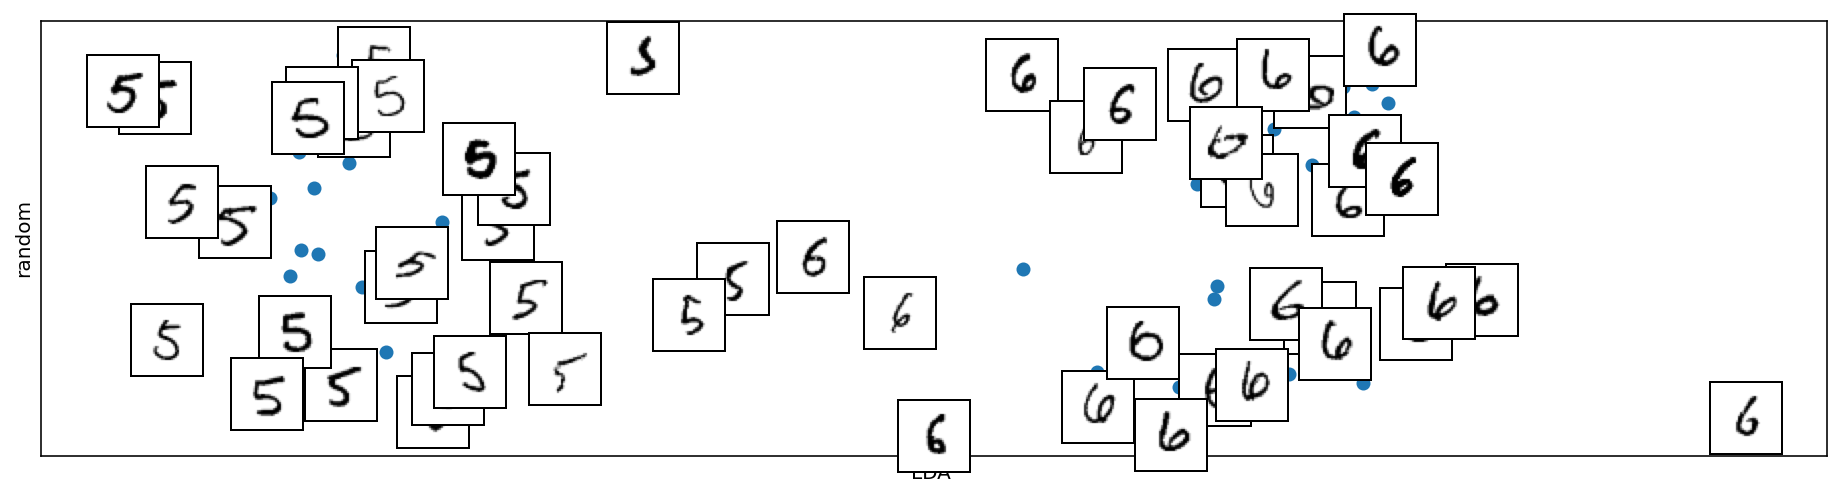

In [16]:
lda56 = LinearDiscriminantAnalysis()
lda56.fit(X56, Y56)
U56 = lda56.transform(X56)
ff,aa = plt.subplots(1,1,figsize=(16,4))
plot_embedding(aa,np.vstack((U56.ravel(), 0.02*np.random.rand(U56.shape[0]))).T, 
                   X56,
                  xlabel='LDA ', 
                  ylabel='random')

### Pares vs. impares

Ahora vamos a probar una clasificación más exótica: separar pares de impares. Es exótica porque si bien es fácil diferenciar dígitos pares de dígitos impares esta clasificación agrupa en una misma clase a por ejemplo a 0 y 4 mientras que en una clase distinta está el 9, que es más parecido al 4.

In [17]:
pares = []
for cc in [0,2,4,6,8]:
    pares += (np.where(Y==cc)[0][:20]).tolist()
pares = np.array(pares)

impares = []
for cc in [1,3,5,7,9]:
    impares += (np.where(Y==cc)[0][:20]).tolist()
impares = np.array(impares)


In [18]:
Xeo = np.vstack((X[pares,:], X[impares,:]))
Yeo = np.ones(Xeo.shape[0])
Yeo[:len(pares)]=-1

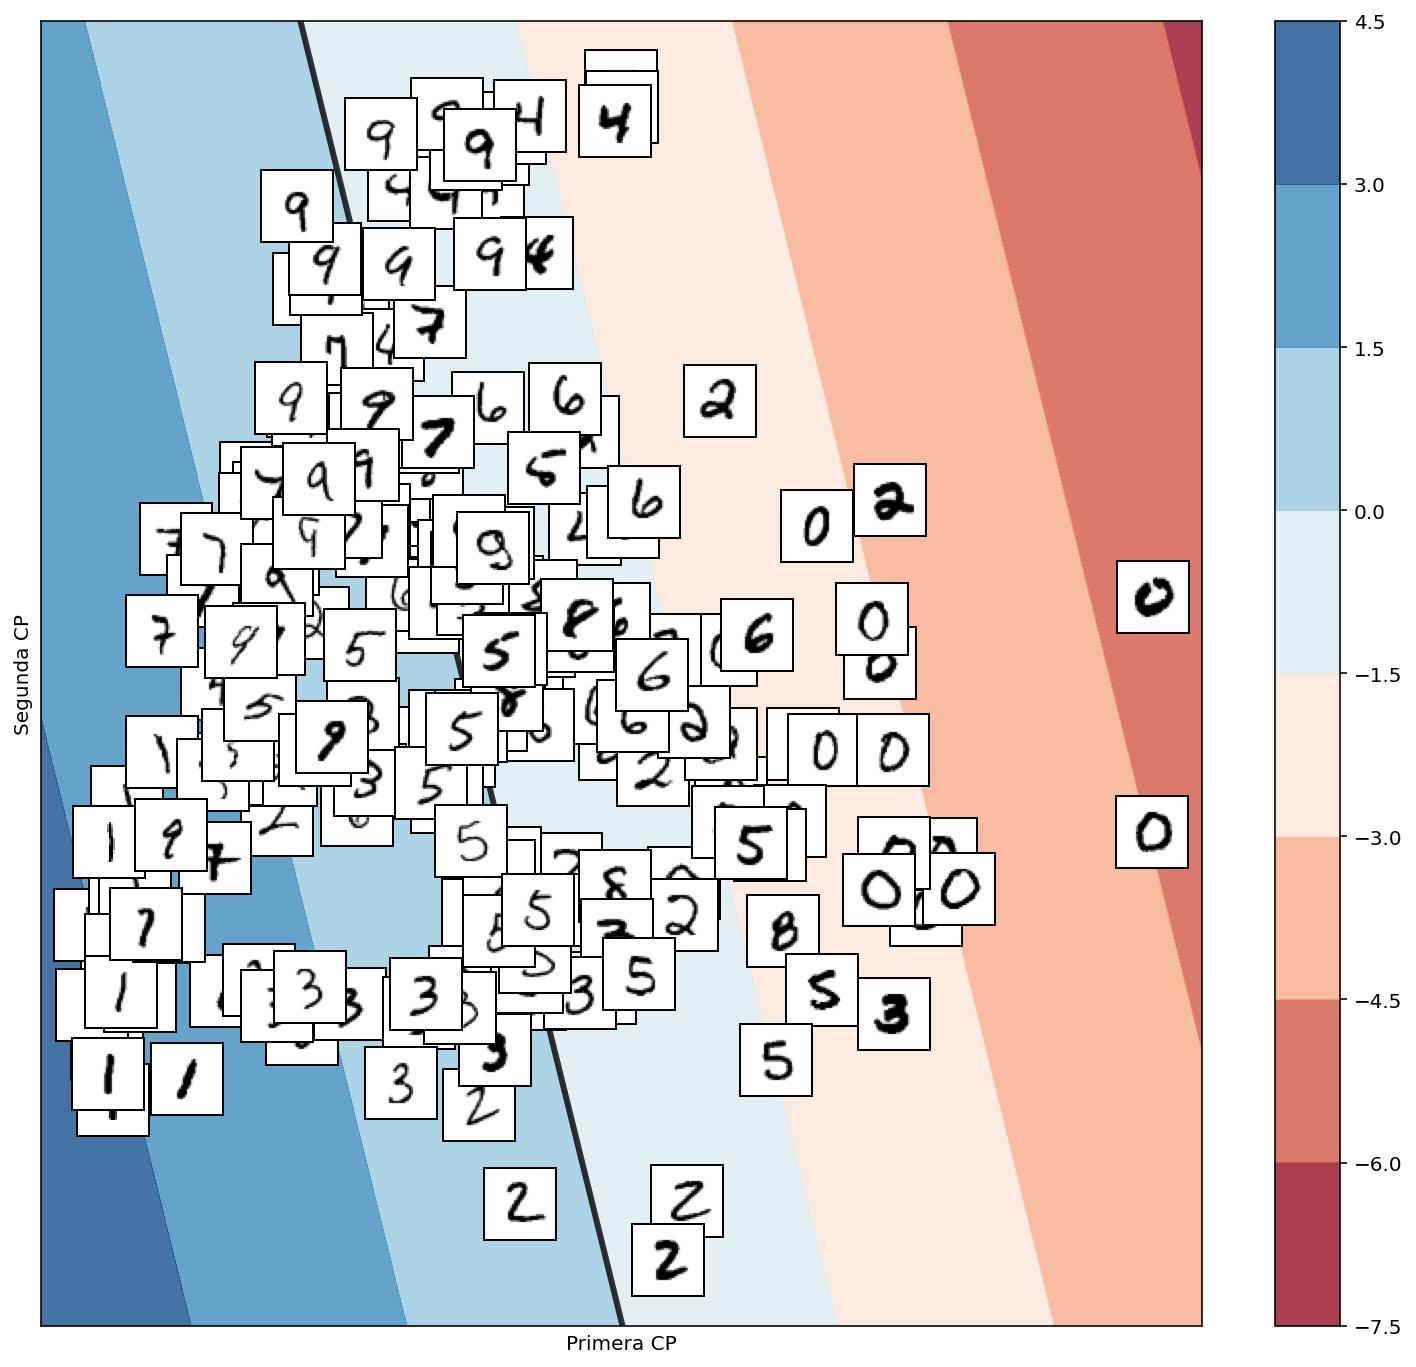

In [19]:
ff,ax=plt.subplots(1,1,figsize=(13,12))
pca_eo = PCA(n_components=2)
Zeo=pca_eo.fit_transform(Xeo)
plot_embedding(ax, Zeo, Xeo)

lda_pca_eo = LinearDiscriminantAnalysis()
lda_pca_eo.fit(Zeo, Yeo)
h=100
x_min, x_max = Zeo[:, 0].min() - .5, Zeo[:, 0].max() + .5
y_min, y_max = Zeo[:, 1].min() - .5, Zeo[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                        np.linspace(y_min, y_max, h))
Z = lda_pca_eo.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)

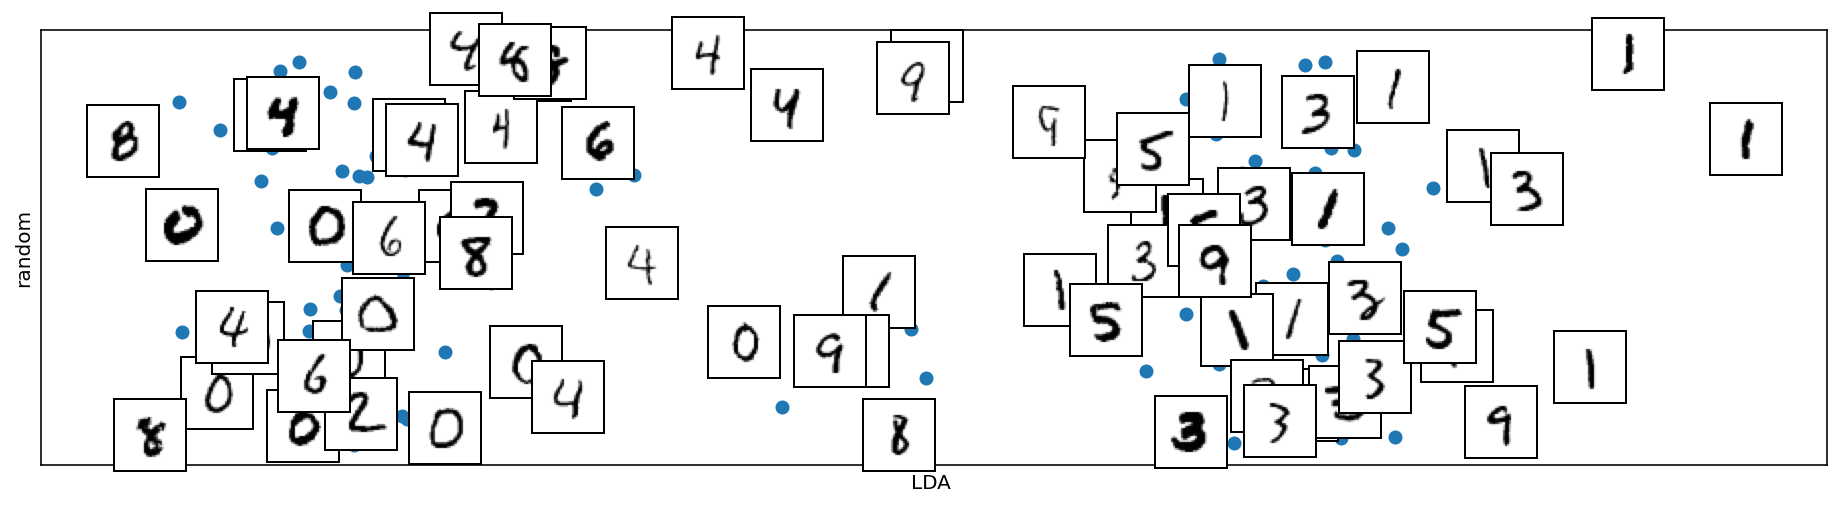

In [20]:
lda_eo = LinearDiscriminantAnalysis()
lda_eo.fit(Xeo, Yeo)
Ueo = lda_eo.transform(Xeo)
ff,aa = plt.subplots(1,1,figsize=(16,4))
plot_embedding(aa,np.vstack((Ueo.ravel(), 0.02*np.random.rand(Ueo.shape[0]))).T, 
                   Xeo,
                  xlabel='LDA ', 
                  ylabel='random')

## Clasificador de Fisher en problemas multiclase

Cuando presentamos las SVM, vimos que los problemas multiclase se resuelven empleando baterías de clasificadores binarios, bien con el esquema uno-contra-el-resto o con el esquema uno-contra-uno. El clasificador de Fisher tiene una manera más natural de trabajar con problemas con $M>2$ clases. Esta manera consiste en proyectar los datos a un espacio reducido de $q=M-1$ dimensiones con un conjunto de $q$ direcciones de proyección $\mathbf w_j$, $j=1,\dots,q$. En este espacio reducido se construyen $M$ *scores* (análogo a las características sintéticas), cada uno relacionado con una de las clases de salida, y cada observación se clasifica en la clase para la que dicha observación alcanza el maximo de los $M$ *scores*.

En primer lugar es necesario asegurarse de que el **número de dimensiones de los datos es mayor que el número de clases**, para que la transformación lineal tenga grados de libertad suficientes con los que resolver el problema. 

La manera de generalizar el problema binario a $M>2$ clases es la siguiente. En el problema binario tratamos de encontrar la dirección de **separación de las medias de las dos clases**, es decir, separar $m_0$ (la media de la clase $C_0$ en el espacio proyectado) de $m_1$ (la media de la clase $C_1$ en el espacio proyectado). Esto es equivalente a  separar la media $m_0$ de la media $m$ de todos los datos y simultáneamente separar $m_1$ de $m$.

Matemáticamente separar cada una de las medias de cada clase de la media global se escribe como:

$$
(m_1-m)^2 + (m_0-m)^2 = m_1^2 -2m_1m + m^2 + m_0^2 -2m_0m + m^2 = m_1^2 + m_0^2 + 2m^2 -2m_0m - 2m_1m
$$

La media total puede calcularse como (si asumimos clases equiprobables)

$$
m = \frac{1}{2}(m_1 + m_0)
$$

Sustituyendo este valor arriba

$$
(m_1-m)^2 + (m_0-m)^2 = m_1^2 + m_0^2 + \frac{1}{2}(m_1^2 + m_0^2 + 2m_1m_0)-m_0(m_1+m_0) - m_1(m_1+m_0) =
$$

$$
m_1^2 + m_0^2 + \frac{1}{2}(m_1^2 + m_0^2 + 2m_1m_0) -2m_0m_1 - m_0^2 - m_1^2 =
$$

$$
=\frac{1}{2}m_1^2 +\frac{1}{2} m_0^2 -m_1m_0 = \frac{1}{2}(m_1-m_0)^2
$$

que es la expresión que nos separa las medias de cada clase en el espacio proyectado. Luego es equivalente separar las dos medias $m_0$ y $m_1$ entre sí que separar simultáneamente cada una de estas medias de la media de todos los datos $m$.


Cuando tenemos más de dos clases ($M>2$) el espacio proyectado debe ser de dimensión $q>1$. Anticipamos que esta dimensión va a ser $q=M-1$. La proyección lineal entonces se realiza a partir de $q$ direcciones $\mathbf w_m$. Por tanto cada observación en el espacio original $\mathbf x \in \mathbb R^p$ con $p$ dimensiones se va proyectar en un vector $\mathbf z \in \mathbb R^{q}$ de un espacio intermedio de $q< p$ dimensiones mediante

$$
\mathbf z_i = W\mathbf x_i = \left [ \begin{array}{c} \mathbf w_1^\top \\ \mathbf w_2^\top \\ \vdots \\ \mathbf w_{q}^\top  \end{array}\right ] \mathbf x_i
$$

donde las filas de la matriz $W$ de tamaño $q \times p$ son los  $q$ vectores $\mathbf w_m$ que componen cada una de estas características sintéticas lineales.

Por tanto los datos proyectados tendrán una media que será un vector

$$
\boldsymbol \mu = \frac{1}{N}\sum_{i=1}^N\mathbf z_i \in \mathbb R^{q}
$$

Y las medias de cada clase vendrán dadas por

$$
\boldsymbol \mu_1 = \frac{1}{N_1}\sum_{i\in 1}\mathbf z_i \in \mathbb R^{q}
$$

$$
\boldsymbol \mu_2 = \frac{1}{N_2}\sum_{i\in 2}\mathbf z_i \in \mathbb R^{q}
$$

$$
\vdots
$$

$$
\boldsymbol  \mu_M = \frac{1}{N_M}\sum_{i\in M}\mathbf z_i \in \mathbb R^{q}
$$


donde $N_m$ es el número de observaciones de la clase $C_m$ presentes en el conjunto de entrenamiento

El término que se encarga de la separación de las medias de cada clase en el problema de optimización es la matrix $s_B$. En el espacio proyectado esta matriz se calcula como:

$$
s_B = \sum_{m=1}^MN_m(\boldsymbol \mu_m - \boldsymbol \mu)(\boldsymbol \mu_m - \boldsymbol \mu)^\top
$$

La otra componente que constituye el problema de optimización es la compacidad de las varianzas en el espacio proyectado. Como ahora los elementos en el espacio proyectado son vectores, en lugar de varianzas tenemos matrices de covarianzas. En el problema binario de esta componente se encargaba la suma de las varianzas. En un problema multiclase formamos la matriz $s_W$ de tamaño $q\times q$ sumando las matrices de covarianza de cada clase

$$
s_W = s_1 + s_2 + \dots + s_M = \sum_{m=1}^M{\sum_{i\in m}{(\mathbf z_i - \boldsymbol \mu_m)(\mathbf z_i - \boldsymbol \mu_m)^\top}}
$$

Una función escalar dependiente de $W$ cuya optimización nos puede conducir a un espacio reducido donde maximizar la separación de las clases posibilitando la  clasificación puede ser:

$$
J(W) = \max_W \mbox{Traza}\{s_W^{-1}s_B\}
$$

El funcional $J(W)$ puede expresarse en función de las observaciones en el espacio original

$$
s_B = \sum_{m=1}^MN_m(\boldsymbol \mu_m - \boldsymbol \mu)(\boldsymbol \mu_m - \boldsymbol \mu)^\top = \sum_{m=1}^MN_mW(\mathbf m_m - \mathbf m)(\mathbf m_m - \mathbf m)^\top W^\top = W\left (\sum_{m=1}^MN_m(\mathbf m_m - \mathbf m)(\mathbf m_m - \mathbf m)^\top \right )W^\top = WS_BW^\top
$$
donde 
$$
S_B = \sum_{m=1}^MN_m(\mathbf m_m - \mathbf m)(\mathbf m_m - \mathbf m)^\top
$$

Análogamente

$$
s_W = \sum_{m=1}^M{\sum_{i\in m}{(\mathbf z_i - \boldsymbol \mu_m)(\mathbf z_i - \boldsymbol \mu_m)^\top}} =  \sum_{m=1}^M{\sum_{i\in m}{W(\mathbf x_i - \mathbf m_m)(\mathbf x_i - \mathbf m_m)^\top W^\top}} = W\left (\sum_{m=1}^M{\sum_{i\in m}{(\mathbf x_i - \mathbf m_m)(\mathbf x_i - \mathbf m_m)^\top }}\right ) W^\top = WS_WW^\top
$$

donde

$$
S_W = \sum_{m=1}^M{\sum_{i\in m}{(\mathbf x_i - \mathbf m_m)(\mathbf x_i - \mathbf m_m)^\top }}
$$

Luego la función a optimizar explícitamente expresada en función de $W$ y de los datos en el espacio original es:

$$
J(W) = \max_W \mbox{Traza}\{(WS_WW^\top)^{-1}WS_BW^\top\}
$$

Esta optimización se resuelve mediante un **problema de autovalores** sobre la matriz $S_W^{-1}S_B$. En concreto $W$ está formada por los $q$ autovectores de $S_W^{-1}S_B$ de mayores autovalores. 

La matriz de covarianzas de las medias, $S_B$, tiene como mucho rango $M-1$ porque es una combinación lineal de $M$ componentes, pero como le restamos la media a todas, esa colinealidad nos resta un grado de libertad. Por esta circunstancia, la matriz $S_W^{-1}S_B$ va a tener como mucho $q=M-1$ autovalores.

### Linear Discriminant Analysis multiclase en scikit learn

La clase `LinearDiscriminantAnalysis` de *scikit learn* tiene implementada la versión multiclase del algoritmo, por lo tanto se puede emplear en modo transparente cuando en el vector de *targets*  aparecen más de dos clases distintas.

Vamos a probar la clase `LinearDiscriminantAnalysis` en un problema sencillo con tres clases.

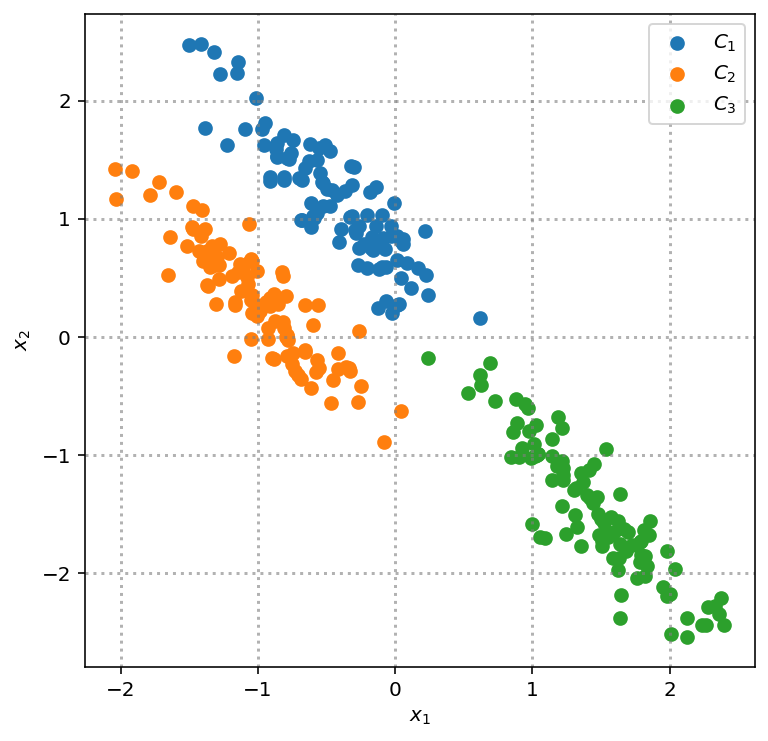

In [21]:
XX, y_true = make_blobs(n_samples=300, centers=3,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(13)
X_stretched = np.dot(XX, rng.randn(2, 2))

X_stretched -= np.mean(X_stretched,0)

fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_1$')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_2$')
ax.scatter(X_stretched[y_true==2, 0], X_stretched[y_true==2, 1],  s=40, label='$C_3$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_=ax.legend()


La siguiente celda aprende el clasificador de Fisher y dibuja cada uno de los 3 scores en el espacio reducido de 2 dimensiones que se emplean para clasificar cada observación. Estos *scores* se pueden recuperar del método `decision_function`

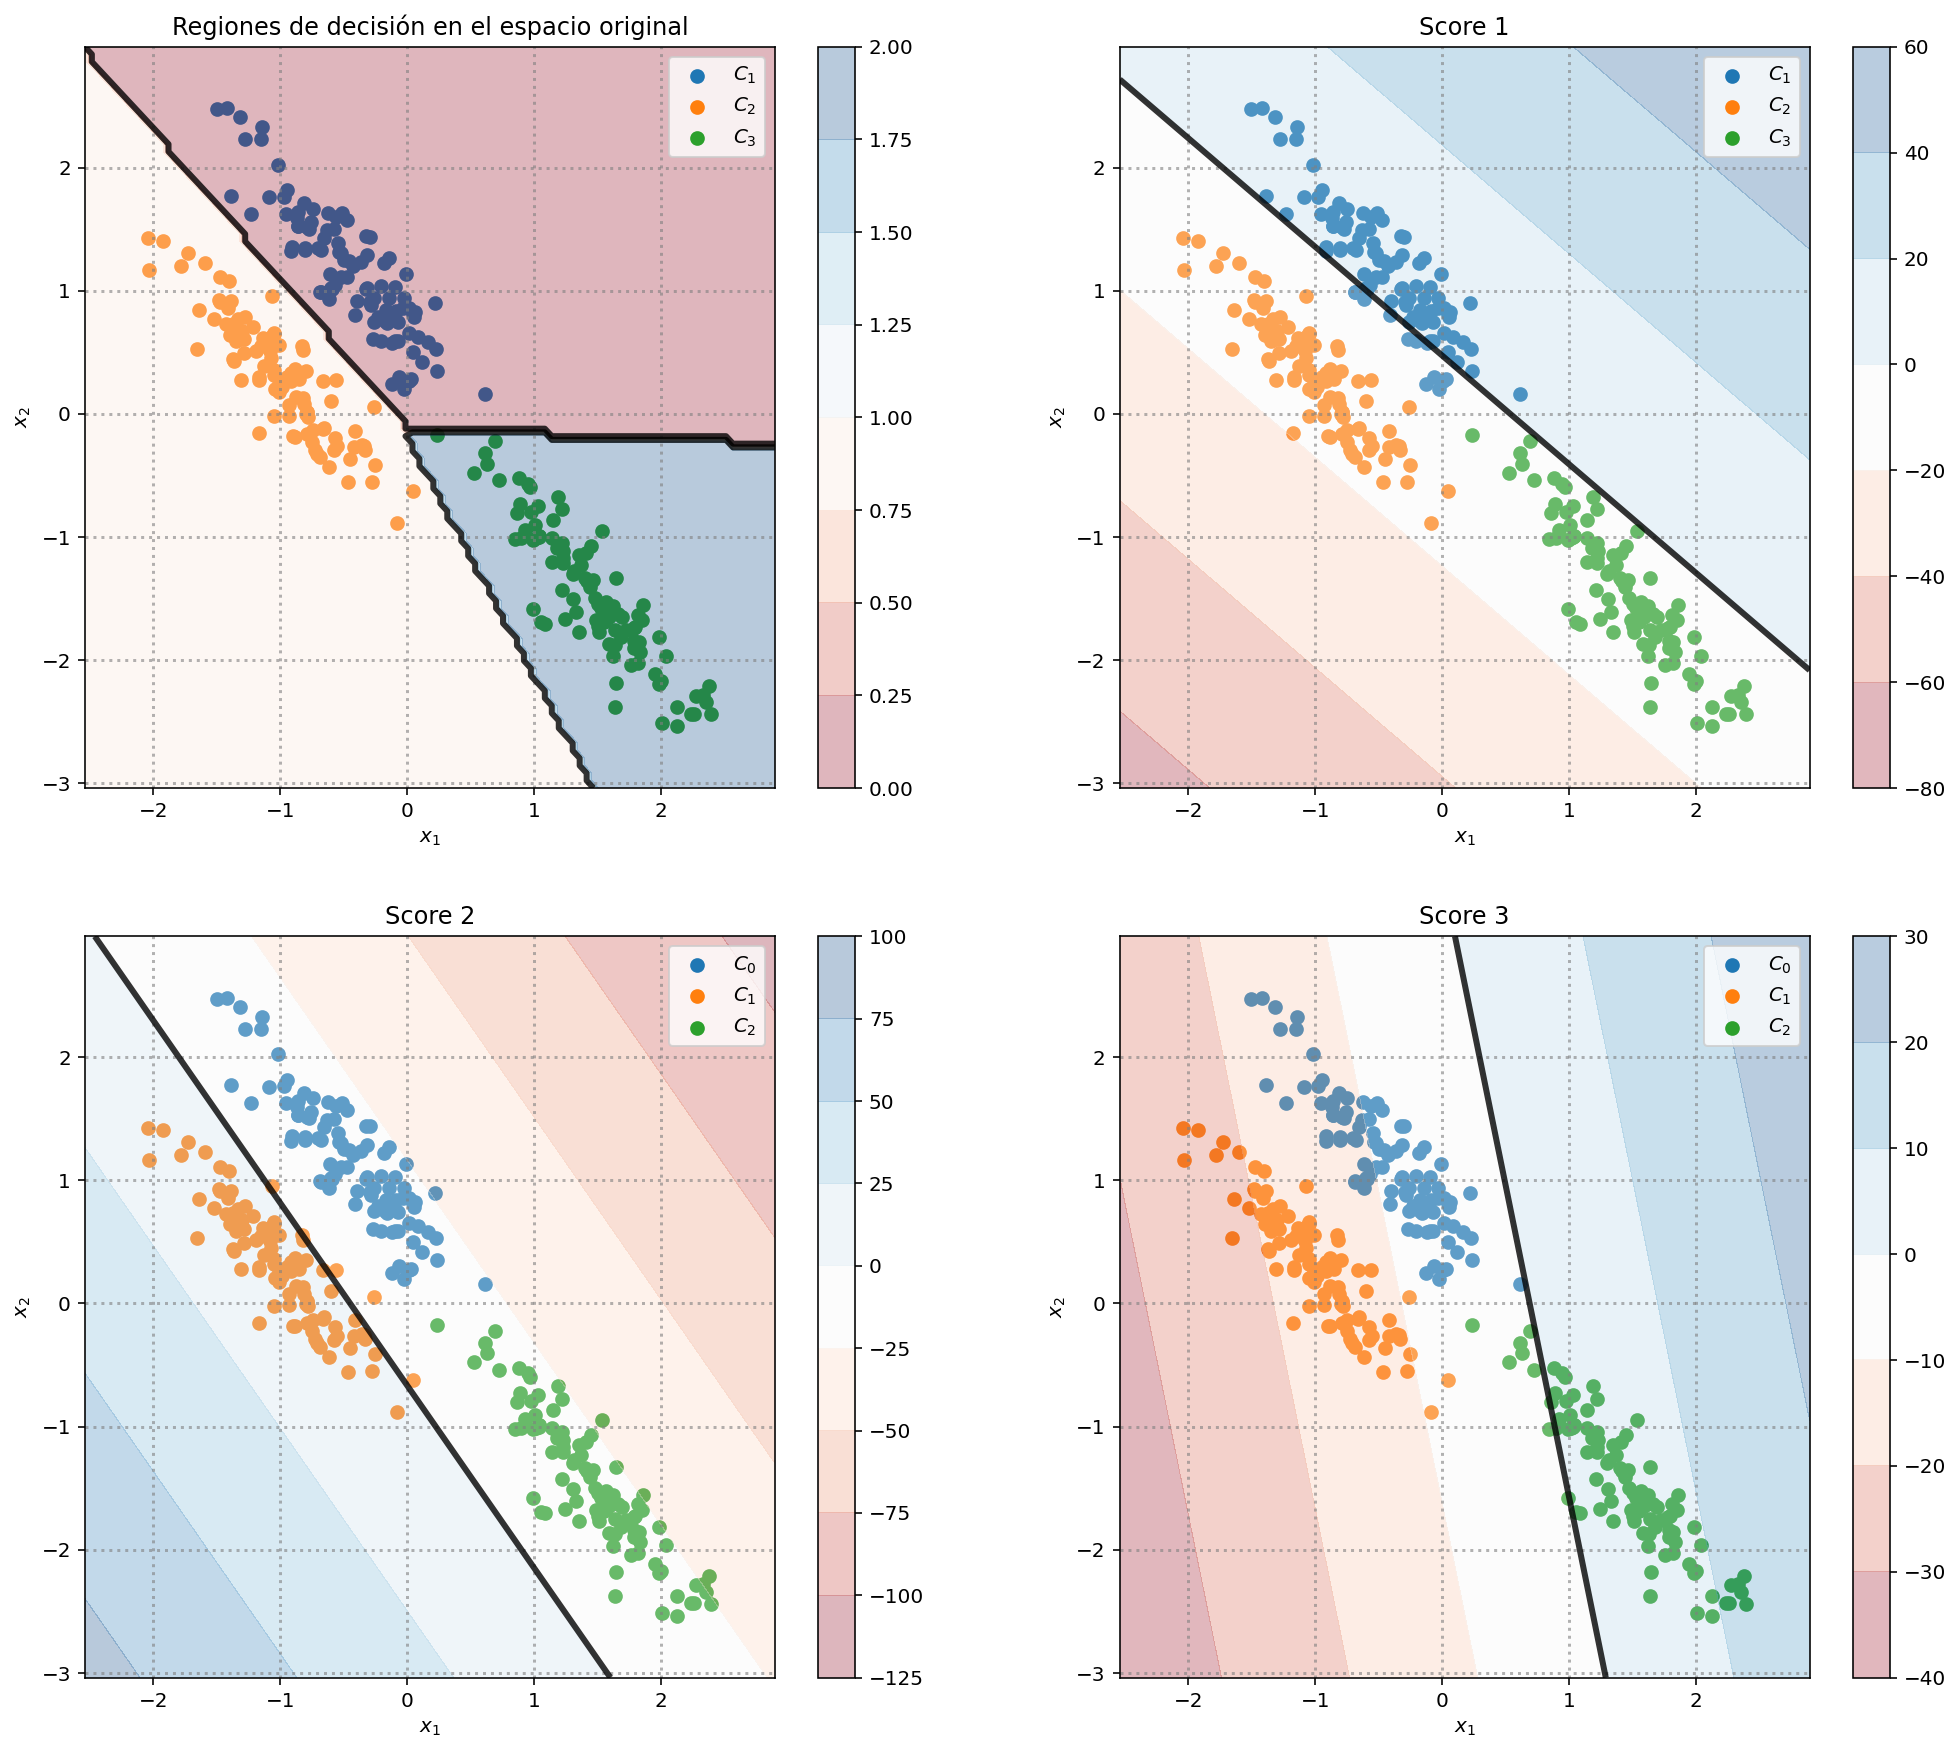

In [22]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_stretched, y_true)


cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

fig, aa = plt.subplots(2,2,figsize=(17, 15))
ax = aa[0][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_1$')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_2$')
ax.scatter(X_stretched[y_true==2, 0], X_stretched[y_true==2, 1],  s=40, label='$C_3$')
ax.set_xlabel('$x_1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_=ax.legend()

h=100
x_min, x_max = X_stretched[:, 0].min() - .5, X_stretched[:, 0].max() + .5
y_min, y_max = X_stretched[:, 1].min() - .5, X_stretched[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                        np.linspace(y_min, y_max, h))
Zz = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Zz,1)
        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.3)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0,1],  alpha=.8, colors='black',linewidths=3)

_ = ax.set_title('Regiones de decisión en el espacio original')


ax = aa[0][1]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_1$')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_2$')
ax.scatter(X_stretched[y_true==2, 0], X_stretched[y_true==2, 1],  s=40, label='$C_3$')
ax.set_xlabel('$x_1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_=ax.legend()


Z = Zz[:,0]
        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.3)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)

_ = ax.set_title('Score 1')

ax = aa[1][0]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_0$')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_1$')
ax.scatter(X_stretched[y_true==2, 0], X_stretched[y_true==2, 1],  s=40, label='$C_2$')
ax.set_xlabel('$x_1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_=ax.legend()


Z = Zz[:,1]
        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.3)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)
_ = ax.set_title('Score 2')

ax = aa[1][1]
ax.scatter(X_stretched[y_true==0, 0], X_stretched[y_true==0, 1],  s=40, label='$C_0$')
ax.scatter(X_stretched[y_true==1, 0], X_stretched[y_true==1, 1],  s=40, label='$C_1$')
ax.scatter(X_stretched[y_true==2, 0], X_stretched[y_true==2, 1],  s=40, label='$C_2$')
ax.set_xlabel('$x_1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_=ax.legend()


Z = Zz[:,2]
        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.3)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)
_ = ax.set_title('Score 3')

La partición en regiones de la figura de arriba a la izquierda se realiza viendo cuál es el *score* máximo para cada punto. Se define la región de $C_1$ como aquellos puntos para los cuales el *score 1* es máximo. Se evalúan los 3 *scores* para cada punto y se asignan a la región de $C_1$ aquellos para los que el valor del *score 1* es mayor que cualquiera de los otros dos *scores*. El *score 1* se representa en la figura de arriba a la derecha. Análogamente las regiones asignadas a $C_2$ y $C_3$ son las que comprenden los puntos para los que el *score 2* o el *score 3* son los más altos, respectivamente.

La siguiente figura representa las observaciones en el espacio reducido.

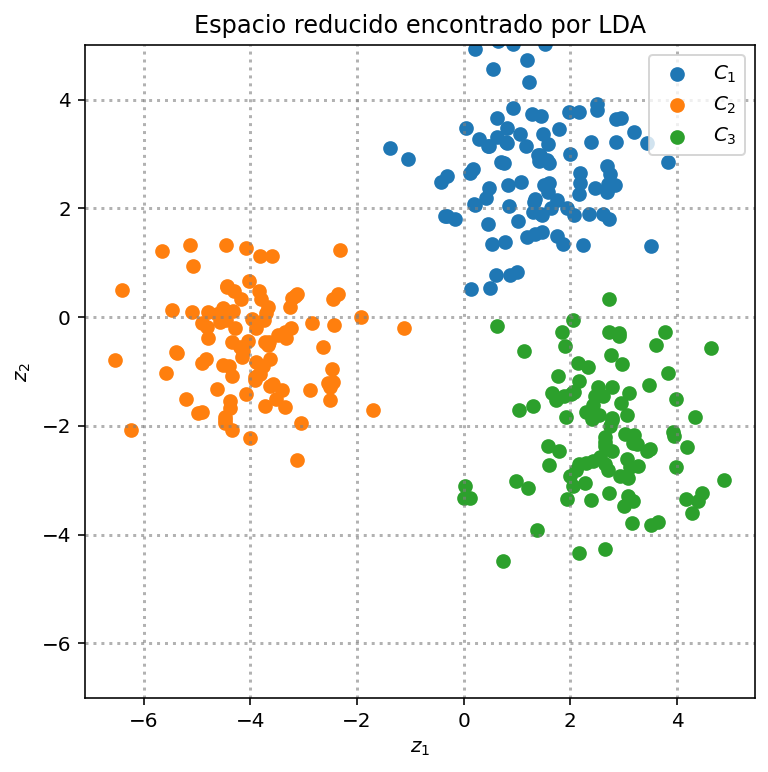

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
Z_lda = clf.transform(X_stretched) 
ax.scatter(Z_lda[y_true==0, 0], Z_lda[y_true==0, 1],  s=40, label='$C_1$')
ax.scatter(Z_lda[y_true==1, 0], Z_lda[y_true==1, 1],  s=40, label='$C_2$')
ax.scatter(Z_lda[y_true==2, 0], Z_lda[y_true==2, 1],  s=40, label='$C_3$')
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_ = ax.legend()
_ = ax.set_title('Espacio reducido encontrado por LDA')
_ = ax.set_ylim(-7,5)

En contraste representamos ahora el espacio reducido determinado por PCA, que está orientado a la reconstrucción de las observaciones con menor error, mientras que el espacio reducido encontrado por el clasificador de Fisher está orientado a la separabilidad de las clases.

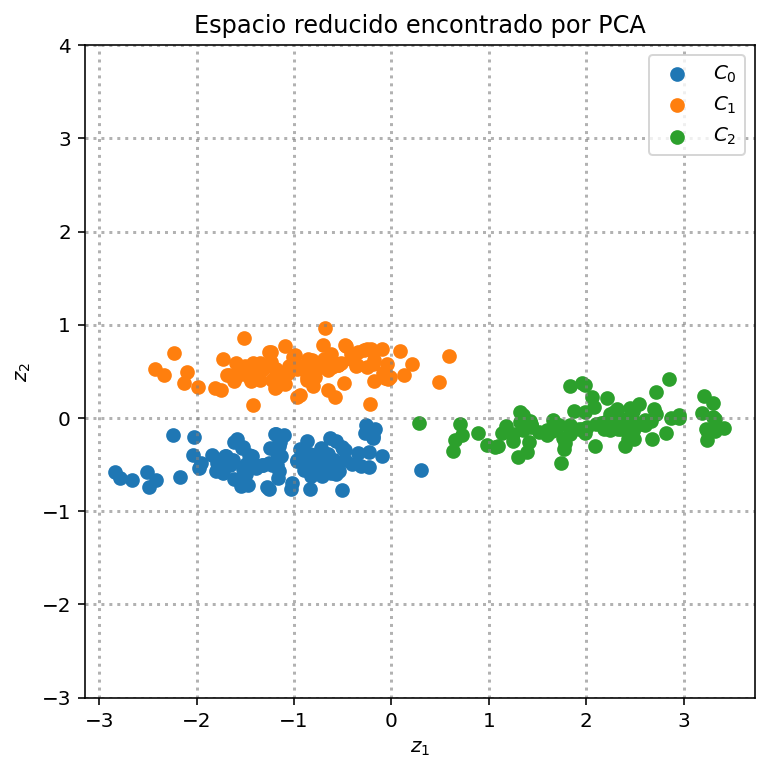

In [24]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
Z_pca = PCA(n_components=2).fit_transform(X_stretched) 
ax.scatter(Z_pca[y_true==0, 0], Z_pca[y_true==0, 1],  s=40, label='$C_0$')
ax.scatter(Z_pca[y_true==1, 0], Z_pca[y_true==1, 1],  s=40, label='$C_1$')
ax.scatter(Z_pca[y_true==2, 0], Z_pca[y_true==2, 1],  s=40, label='$C_2$')
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
_ = ax.legend()
_ = ax.set_ylim(-3,4)
_ = ax.set_title('Espacio reducido encontrado por PCA')

### Clasificador de Fisher multiclase con los dígitos manuscritos

Vamos a plantear un problema multiclase, que es separar 1s, 5s y 6s con el clasificador lineal de Fisher. En primer lugar, tal y como hicimos en los casos binarios, primero proyectamos con PCA a un espacio reducido de 2 dimensiones y planteamos el clasificador de Fisher en este espacio reducido.

<ipython-input-25-35d766e89251>:24: UserWarning: No contour levels were found within the data range.
  _=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)


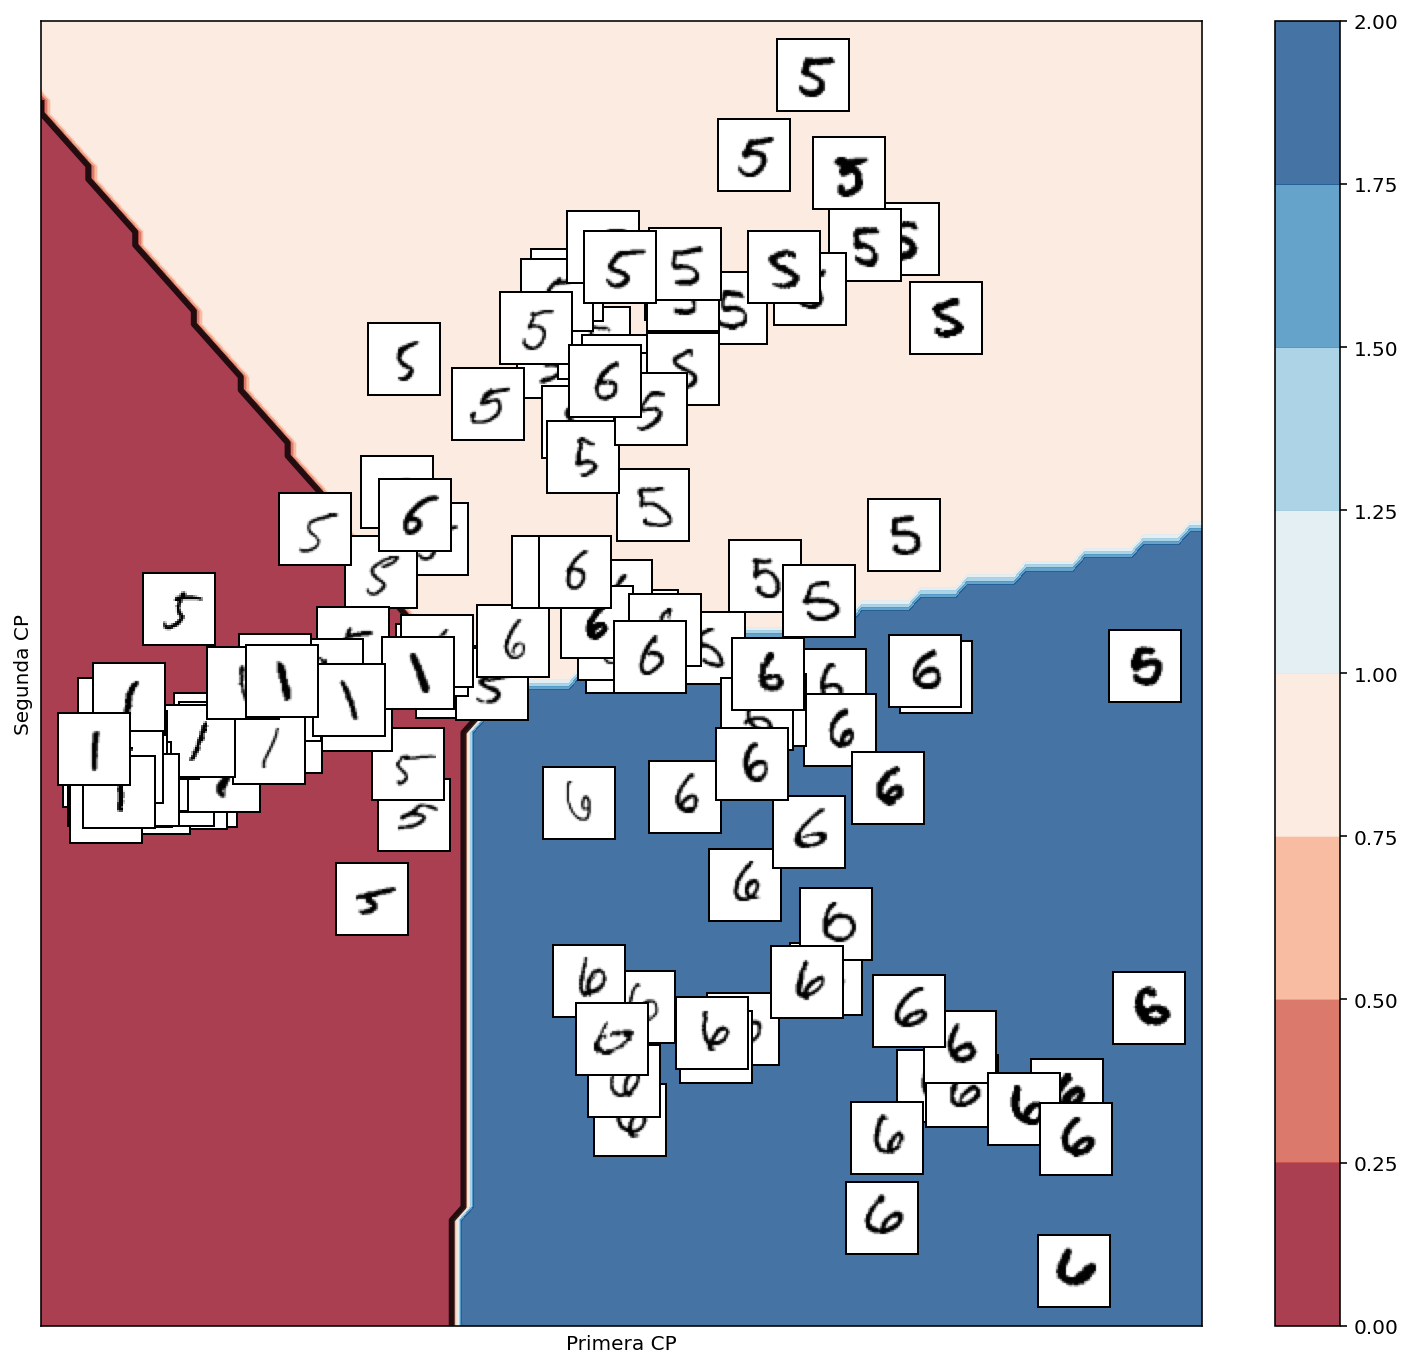

In [25]:
X561 = np.vstack((X[cincos[:50],:], X[seis[:50],:], X[unos[:50],:]))
Y561 = np.ones((X561.shape[0]))
Y561[:50] = 5
Y561[51:100] = 6

ff,ax=plt.subplots(1,1,figsize=(13,12))
pca561 = PCA(n_components=2)
Z561=pca561.fit_transform(X561)
plot_embedding(ax, Z561, X561)

lda_pca561 = LinearDiscriminantAnalysis()
lda_pca561.fit(Z561, Y561)
h=100
x_min, x_max = Z561[:, 0].min() - .5, Z561[:, 0].max() + .5
y_min, y_max = Z561[:, 1].min() - .5, Z561[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                        np.linspace(y_min, y_max, h))
Zz = lda_pca561.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Zz,1)
        # Put the result into a color plot
Z = Z.reshape(xx.shape)
cc=ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
fig.colorbar(cc, ax=ax)
_=ax.contour(xx, yy, Z, [0],  alpha=.8, colors='black',linewidths=3)

A continuación aplicamos el clasificador de Fisher directamente sobre los datos en el espacio original de dimensión $28\times 28$. Este espacio reducido es de $q=M-1=2$ dimensiones.

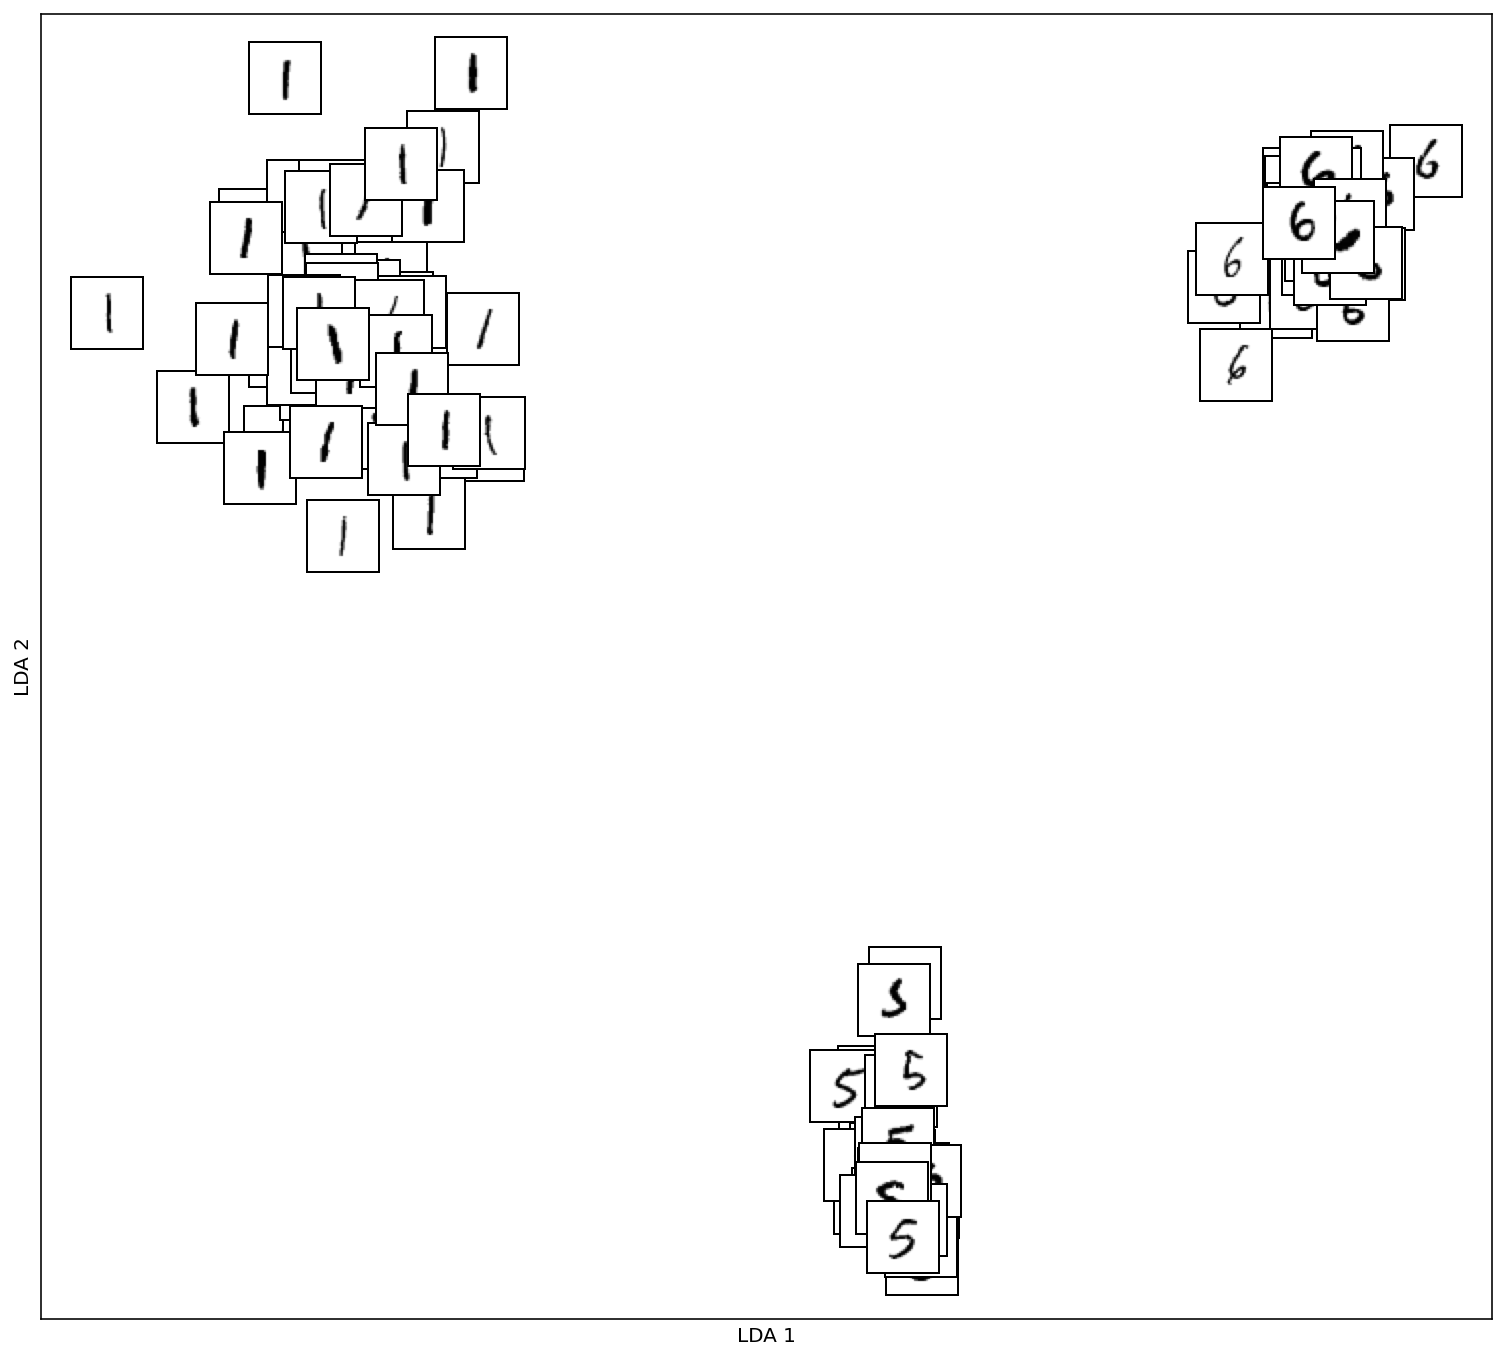

In [26]:
lda561 = LinearDiscriminantAnalysis()
lda561.fit(X561, Y561)
U561 = lda561.transform(X561)
ff,aa = plt.subplots(1,1,figsize=(13,12))
plot_embedding(aa,U561, 
                   X561,
                  xlabel='LDA 1', 
                  ylabel='LDA 2')



Si aplicamos el clasificador de Fisher al problema original con 10 clases y representamos las dos primeras componentes

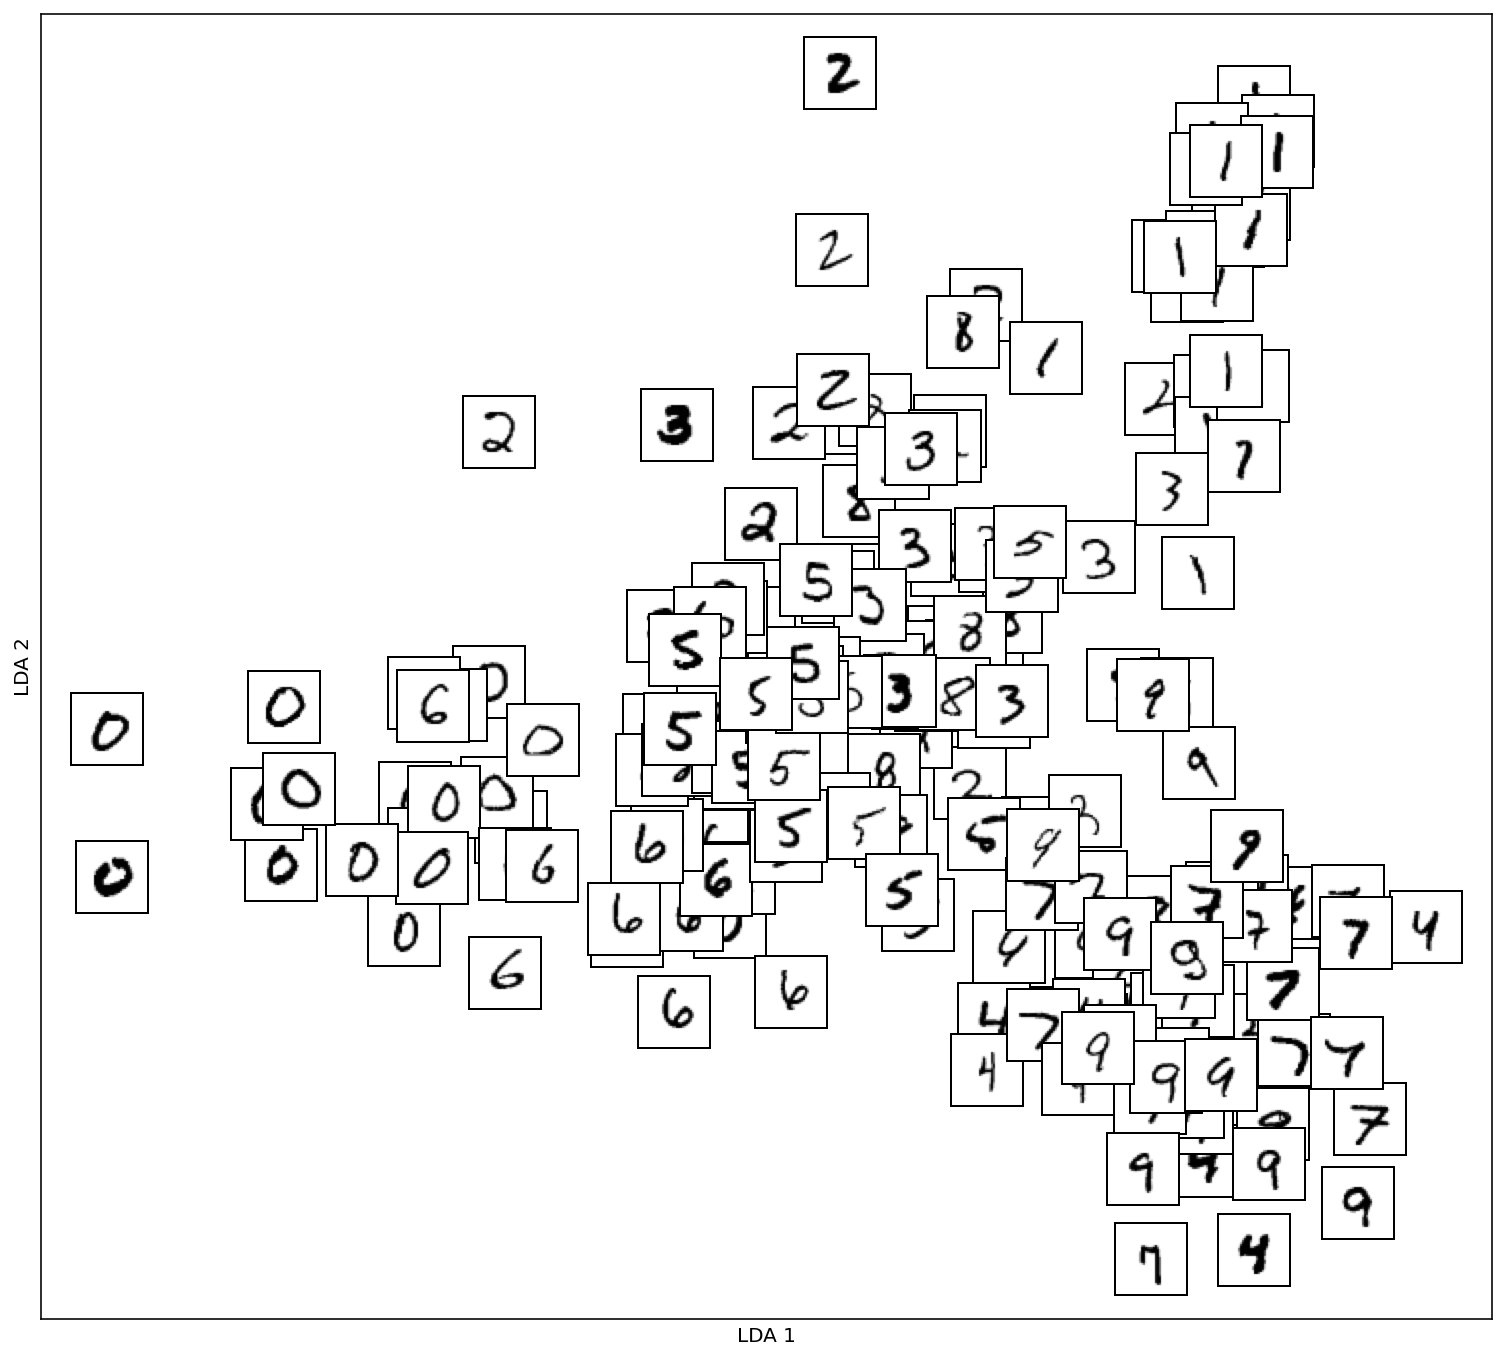

In [27]:
lda_all = LinearDiscriminantAnalysis()
lda_all.fit(X, Y)
U_all = lda_all.transform(Xeo)[:,:2]
ff,aa = plt.subplots(1,1,figsize=(13,12))
plot_embedding(aa,U_all, 
                   Xeo,
                  xlabel='LDA 1', 
                  ylabel='LDA 2')

In [28]:
print('Separabilidad alcanzada por el clasificador de Fisher {0:.2f}%'.format(100*lda_all.score(X,Y)))

Separabilidad alcanzada por el clasificador de Fisher 90.19%


### Capacidad de discriminación del espacio reducido

Las siguientes celdas comparan la capacidad de discriminación del clasificador de Fisher actuando en el espacio original respecto de hacer un PCA con un número creciente de componentes y aplicando un clasificador de Fisher en el espacio reducido. 
   

In [29]:
 x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.5)

In [30]:
pca = PCA(n_components=200).fit(x_train, y_train)
z_train = pca.transform(x_train)
z_test = pca.transform(x_test)
score_pca = np.empty(199)
score_pca_train = np.empty(199)
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
score_lda = lda.score(x_test, y_test)
score_lda_train = lda.score(x_train, y_train)

for nc in range(1,200):
    
    lda_pca = LinearDiscriminantAnalysis().fit(z_train[:,:nc], y_train)
    score_pca[nc-1] = lda_pca.score(z_test[:,:nc], y_test)
    score_pca_train[nc-1]= lda_pca.score(z_train[:,:nc], y_train)
    

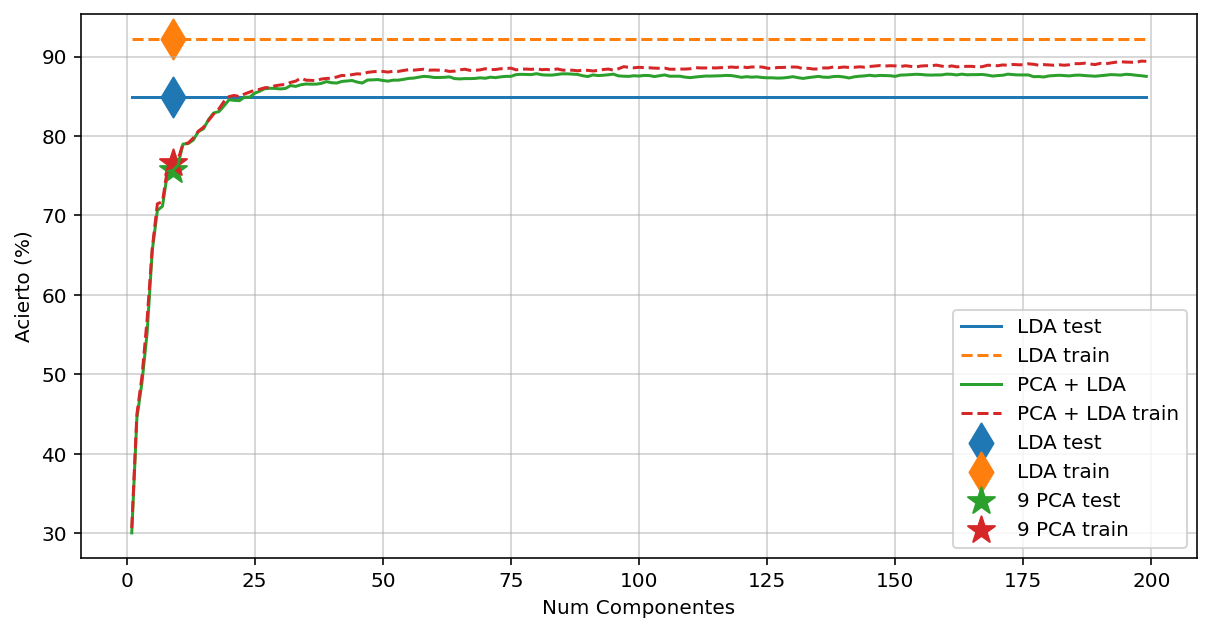

In [31]:
plt.figure(figsize=(10,5))
plt.plot(range(1,200), score_lda*np.ones(199)*100, label='LDA test')
plt.plot(range(1,200), score_lda_train*np.ones(199)*100, 
         linestyle = '--',
         label='LDA train')
plt.scatter(9,100*score_lda,marker='d',s=200, label='LDA test ')
plt.scatter(9,100*score_lda_train,marker='d',s=200, label='LDA train ')
plt.plot(range(1,200), score_pca*100, label='PCA + LDA')
plt.plot(range(1,200), score_pca_train*100, label='PCA + LDA train', linestyle='--')

plt.scatter(9,100*score_pca[8],marker='*',s=200, label='9 PCA test ')
plt.scatter(9,100*score_pca_train[8],marker='*',s=200, label='9 PCA train ')
plt.xlabel('Num Componentes')
plt.ylabel('Acierto (%)')
plt.grid(alpha=0.6)
_=plt.legend()

El acierto de LDA es independiente del número de componentes extraíadas porque LDA elige automáticamente el tamaño del subespacio en el que proyecta, no es posible hacer un LDA en menos (o en más) dimensiones.

El clasificador de Fisher es más fácil de sobreajustar porque no tiene ningún elemento de regularización (en el PCA el número de componentes puede contribuir a regularizar la solución).

# 2. Kernel Fisher Discriminant

El clasificador lineal de Fisher puede extenderse a escenarios no lineales mediante *kernels* de modo análogo al procedimiento que presentamos para PCA. 

Tal y como hemos visto para la SVM y para el PCA, planteamos el clasificador de Fisher que obtendríamos si proyectamos no-linealmente las observaciones a un espacio de características $\mathcal F$ de muy alta dimensión mediante una transformación $\boldsymbol \phi(\mathbf x)$, y aplicaremos el *kernel trick* para poder acceder a este clasificador desde el espacio original (sin emplear explícitamente la proyección).

### Proyectando las observaciones a un espacio $\mathcal F$ de muy alta dimensión

Al elegir el *kernel* $\kappa(\mathbf x_i , \mathbf x_j)$ estamos implícitamente eligiendo una transformación  $\boldsymbol \phi(\mathbf x)$ tal que se cumple que:

$$
\kappa(\mathbf x_i , \mathbf x_j) = \boldsymbol \phi(\mathbf x_i)^\top \boldsymbol \phi(\mathbf x_j)
$$

donde $\mathbf x_i$ y $\mathbf x_j$ son dos vectores en $\mathbb R^p$ y $\boldsymbol \phi(\mathbf x_i)$ y $\boldsymbol \phi(\mathbf x_j)$ son dos vectores en $\mathcal F$.

Entonces, vamos a asumir que en lugar de los datos en el espacio original, tenemos el problema definido en el espacio $\mathcal F$, es decir, nuestras observaciones son $\{\boldsymbol \phi(\mathbf x_i)\}_{i=1}^N$ y cada observación pertenece a una de las $M$ clases ($C_1$ a $C_{M}$) de salida posibles.

Las observaciones en el espacio transformado forman una matriz $\Phi$ donde cada observación es una fila
$$
\boldsymbol \Phi = \left [ \begin{array}{c}\boldsymbol\phi(\mathbf x_1)^\top \\ \boldsymbol\phi(\mathbf x_2)^\top \\ \vdots \\ \boldsymbol\phi(\mathbf x_N)^\top \end{array}\right ]
$$

Si suponemos que la dimensión de $\mathcal F$ es $h \gg p$, entonces la matriz $\boldsymbol \Phi$ es de tamaño $N\times h$

### Formulación del LDA en el espacio $\mathcal F$

Entrenar un clasificador de Fisher en el espacio $\mathcal F$ para un problema con $M$ clases conlleva aprender los *scores* lineales $\mathbf w_j$ que consiguen la reducción de dimensión lineal desde el espacio transformado

$$
\mathbf z_i = W\boldsymbol \phi(\mathbf x_i)
$$

Los scores lineales en este caso tienen dimensión $q$ pero la reducción es desde el espacio $\mathcal F$, por lo que la matriz $W$ que definiría la reducción de dimensión sería de tamaño $q\times h$.

El problema de optimización que determina $W$ sería

$$
J(W) = \max_W \mbox{Traza}\{(W\Sigma_WW^\top)^{-1}W\Sigma_BW^\top\}
$$

donde $\Sigma_W$ y $\Sigma_B$ son matrices $h\times h$ que hacen las veces de $S_W$ y $S_B$. En este punto hay que hacer notar algunos detalles:
- la dimensión $h$ puede ser mucho mayor incluso que el número de muestras $N$, por lo que $\Sigma_W^{-1}$ no estaría bien definida ya que sería singular.
- debemos asumir que no conocemos explícitamente $\boldsymbol \phi()$ por lo que no podríamos resolver directamente el problema de autovalores de $\Sigma_W^{-1}\Sigma_B$

### Kernel trick

Para aplicar el *kernel trick* lo primero que tenemos que explotar es que dado que el clasificador de Fisher se basa en un problema de autovectores sobre matrices que son combinaciones lineales de las observaciones proyectadas a $\mathcal F$, las filas de la matriz $W$ que realizan la reducción de dimensión pueden expresarse como combinaciones lineales de las observaciones, es decir:
$$
\mathbf w_j = \sum_{i=1}^N\beta_{j,i}\boldsymbol \phi(\mathbf x_i), \quad j=1,\dots,q
$$

En forma matricial

$$
\mathbf w_j =  \left [ \begin{array}{cccc}\boldsymbol\phi(\mathbf x_1) & \boldsymbol\phi(\mathbf x_2) & \cdots & \boldsymbol\phi(\mathbf x_N) \end{array}\right ] \left [ \begin{array}{c}\beta_{j,1} \\ \beta_{j,2} \\ \vdots \\ \beta_{j,N}\end{array}\right ]  = \Phi^\top \boldsymbol \beta_j, \quad j=1,\dots,q
$$

Como los $\mathbf w_j$ son en realidad las filas de $W$

$$
W = \left [ \begin{array}{c}\mathbf w_1^\top \\ \mathbf w_2^\top \\ \vdots \\ \mathbf w_q^\top \end{array}\right ] = \left [ \begin{array}{c}\boldsymbol \beta_1^\top \Phi \\ \boldsymbol \beta_2^\top \Phi \\ \vdots \\ \boldsymbol \beta_q^\top \Phi \end{array}\right ] = B \Phi
$$

donde $B$ es una matriz de tamaño $q\times N$ que contiene los coeficientes que expresan cada fila de $W$ como una combinación lineal de las filas de $\Phi$.

$$
B = \left [ \begin{array}{c} \boldsymbol \beta_1^\top \\ \boldsymbol \beta_2^\top  \\ \vdots \\ \boldsymbol \beta_q^\top \end{array}\right ] = \left [ \begin{array}{cccc} \beta_{1,1} & \beta_{1,2} & \dots & \beta_{1,N} \\ \beta_{2,1} & \beta_{2,2} & \dots & \beta_{2,N} \\ \vdots & \vdots & \ddots & \vdots \\ \beta_{q,1} & \beta_{q,2} & \dots & \beta_{q,N} \end{array}\right ]
$$


Seguidamente nos ocupamos del cálculo de $W\Sigma_BW^\top = B\Phi\Sigma_B\Phi^\top B^\top$. La matriz de covarianzas entre clases se calcula mediante 

$$
\Sigma_B = \sum_{m=1}^MN_m(\mathbf m_m - \mathbf m)(\mathbf m_m - \mathbf m)^\top
$$

donde $\mathbf m_m$ es la media de las observaciones de la clase $m$ y $\mathbf m$ es la media de todas las observaciones de todas las clases.

Estos dos vectores de medias se pueden escribir matricialmente en función de la matriz de datos del espacio proyectado $\Phi$

$$
\mathbf m = \frac{1}{N}\sum_{i=1}^{N}{\boldsymbol \phi(\mathbf x_i)} = \frac{1}{N} \left [ \begin{array}{cccc}\boldsymbol\phi(\mathbf x_1) & \boldsymbol\phi(\mathbf x_2) & \dots & \boldsymbol\phi(\mathbf x_N) \end{array}\right ] \left [ \begin{array}{c} 1 \\ 1 \\ \vdots \\ 1 \end{array}\right ] = \frac{1}{N} \Phi^\top \mathbf 1
$$

$$
\mathbf m_m = \frac{1}{N_m}\sum_{i\in m}{\boldsymbol \phi(\mathbf x_i)} = \frac{1}{N_m} \left [ \begin{array}{cccc}\boldsymbol\phi(\mathbf x_{m_1}) & \boldsymbol\phi(\mathbf x_{m_2}) & \dots & \boldsymbol\phi(\mathbf x_{m_{N_m}}) \end{array}\right ] \left [ \begin{array}{c} 1 \\ 1 \\ \vdots \\ 1 \end{array}\right ] = \frac{1}{N_m} \Phi_m^\top \mathbf 1_m
$$



donde $\mathbf 1_m$ es un vector con $N_m$ unos,  $\Phi_m$ es la **submatriz** de $\Phi$ **formada exclusivamente por las filas correspondientes a las** $N_m$ **observaciones de la clase** $C_m$

Sustituyendo en la definición de $S_B$:

$$
\Sigma_B = \sum_{m=1}^MN_m \left(\frac{1}{N_m} \Phi_m^\top \mathbf 1_m - \frac{1}{N} \Phi^\top \mathbf 1\right )\left(\frac{1}{N_m} \Phi_m^\top \mathbf 1_m - \frac{1}{N} \Phi^\top \mathbf 1\right)^\top = \sum_{m=1}^MN_m \left(\frac{1}{N_m} \Phi_m^\top \mathbf 1_m - \frac{1}{N} \Phi^\top \mathbf 1\right )\left(\frac{1}{N_m} \mathbf 1^\top \Phi_m  - \mathbf 1_m^\top \frac{1}{N} \Phi \right)
$$

Con lo que $B\Phi\Sigma_B\Phi^\top B^\top$ se puede calcular mediante

$$
W\Sigma_BW^\top = B\Phi\Sigma_B\Phi^\top B^\top = B\Phi\left ( \sum_{m=1}^MN_m \left(\frac{1}{N_m} \Phi_m^\top \mathbf 1_m - \frac{1}{N} \Phi^\top \mathbf 1\right )\left(\frac{1}{N_m} \mathbf 1_m^\top \Phi_m  - \mathbf 1^\top \frac{1}{N} \Phi \right) \right )\Phi^\top B^\top 
$$

$$
B\left ( \sum_{m=1}^MN_m \left(\frac{1}{N_m} \Phi\Phi_m^\top \mathbf 1_m - \frac{1}{N} \Phi\Phi^\top \mathbf 1\right )\left(\frac{1}{N_m} \mathbf 1_m^\top \Phi_m \Phi^\top - \mathbf 1^\top \frac{1}{N} \Phi\Phi^\top \right) \right ) B^\top 
$$


El producto matricial 
$$
 \Phi  \Phi^\top
$$

puede escribirse como:

$$
 \Phi  \Phi^\top = 
\left [ \begin{array}{c}\boldsymbol \phi(\mathbf x_1)^\top \\ \boldsymbol \phi(\mathbf x_2)^\top \\ \vdots \\ \boldsymbol\phi(\mathbf x_N)^\top \end{array}\right ] \left [ \begin{array}{cccc}\boldsymbol\phi(\mathbf x_1) & \boldsymbol\phi(\mathbf x_2)  & \cdots & \boldsymbol\phi(\mathbf x_N) \end{array}\right ]  = \left [ \begin{array}{cccc}\boldsymbol\phi(\mathbf x_1)^\top \boldsymbol\phi(\mathbf x_1) & \boldsymbol\phi(\mathbf x_1)^\top\boldsymbol\phi(\mathbf x_2)  & \cdots & \boldsymbol\phi(\mathbf x_1)^\top\boldsymbol\phi(\mathbf x_N) \\ \boldsymbol\phi(\mathbf x_2)^\top \boldsymbol\phi(\mathbf x_1) & \boldsymbol\phi(\mathbf x_2)^\top\boldsymbol\phi(\mathbf x_2)  & \cdots & \boldsymbol\phi(\mathbf x_2)^\top\boldsymbol\phi(\mathbf x_N) \\ \vdots & \vdots & \ddots & \vdots \\ \boldsymbol\phi(\mathbf x_N)^\top \boldsymbol\phi(\mathbf x_1) & \boldsymbol\phi(\mathbf x_N)^\top\boldsymbol\phi(\mathbf x_2)  & \cdots & \boldsymbol\phi(\mathbf x_N)^\top\boldsymbol\phi(\mathbf x_N) \end{array}\right ] 
$$

aplicando el *truco del kernel* 

$$
 \Phi  \Phi^\top = 
 \left [ \begin{array}{cccc}\kappa(\mathbf x_1,\mathbf x_1) & \kappa(\mathbf x_1,\mathbf x_2) & \cdots & \kappa(\mathbf x_1,\mathbf x_N) \\ \kappa(\mathbf x_2,\mathbf x_1) & \kappa(\mathbf x_2,\mathbf x_2)  & \cdots &\kappa(\mathbf x_2,\mathbf x_N)  \\ \vdots & \vdots & \ddots & \vdots \\ \kappa(\mathbf x_N,\mathbf x_1)  & \kappa(\mathbf x_N,\mathbf x_2) & \cdots & \kappa(\mathbf x_N,\mathbf x_N) \end{array}\right ] = K
$$

Esta matriz que contiene todos los pares posibles de evaluaciones de la función *kernel* entre observaciones del conjunto de entrenamiento se conoce como **matriz de kernels** y vamos a denominarla con la letra $K$.



Análogamente

$$
\Phi_m  \Phi^\top = 
\left [ \begin{array}{cccc}\kappa(\mathbf x_{m_1},\mathbf x_1) & \kappa(\mathbf x_{m_1},\mathbf x_2) & \cdots & \kappa(\mathbf x_{m_1},\mathbf x_N) \\ \kappa(\mathbf x_{m_2},\mathbf x_1) & \kappa(\mathbf x_{m_2},\mathbf x_2)  & \cdots &\kappa(\mathbf x_{m_2},\mathbf x_N)  \\ \vdots & \vdots & \ddots & \vdots \\ \kappa(\mathbf x_{m_{N_m}},\mathbf x_1)  & \kappa(\mathbf x_{m_{N_m}},\mathbf x_2) & \cdots & \kappa(\mathbf x_{m_{N_m}},\mathbf x_N) \end{array}\right ] = K_m 
$$

está formada por las $N_m$ filas de la matriz $K$ que se corresponden con observaciones que pertenecen a la clase $C_m$

Introduciendo las matrices de *kernels* en el cálculo anterior
$$
W\Sigma_BW^\top =B\left ( \sum_{m=1}^MN_m \left(\frac{1}{N_m} K_m^\top \mathbf 1_m - \frac{1}{N} K \mathbf 1\right )\left(\frac{1}{N_m} \mathbf 1_m^\top K_m - \mathbf 1^\top \frac{1}{N} K \right) \right ) B^\top 
$$

Y definimos la media por filas (o columnas, puesto que es simétrica) de la matriz $K$

$$
\mathbf h = \frac{1}{N} K \mathbf 1
$$

y la media de las filas de $K_m$ como

$$
\mathbf h_m = \frac{1}{N_m} K_m^\top \mathbf 1_m
$$

tanto $\mathbf h$ como $\mathbf h_m$ son vectores con $N$ componentes. Estos dos vectores nos permiten definir una matriz de covarianzas entre clases $S_B$ análoga a la que vimos para el caso lineal, pero usando las matrices de kernels en lugar de las observaciones en el espacio original:

$$
S_B = \sum_{m=1}^MN_m \left(\mathbf h_m - \mathbf h\right )\left(\mathbf h_m^\top  - \mathbf h^\top\right)
$$

con lo que 

$$
W\Sigma_BW^\top =BS_BB^\top
$$

La *kernelización* se completa expresando el cálculo correspondiente a la matriz de covarianzas intra clases  $W\Sigma_WW^\top$ en función de las matrices de *kernels*.


$$
\Sigma_W = \sum_{m=1}^M{\sum_{i\in m}{(\boldsymbol \phi(\mathbf x_i) - \mathbf m_m)(\boldsymbol \phi(\mathbf x_i) - \mathbf m_m)^\top }} = \sum_{m=1}^M{\sum_{i\in m}{(\boldsymbol \phi(\mathbf x_i) - \frac{1}{N_m} \Phi_m^\top \mathbf 1_m)(\boldsymbol \phi(\mathbf x_i) - \frac{1}{N_m} \Phi_m^\top \mathbf 1_m)^\top }} = \sum_{m=1}^M{\sum_{i\in m}{(\boldsymbol \phi(\mathbf x_i) - \frac{1}{N_m} \Phi_m^\top \mathbf 1_m)(\boldsymbol \phi(\mathbf x_i) - \frac{1}{N_m} \mathbf 1_m^\top \Phi_m) }}
$$

$$
W\Sigma_WW^\top = B\Phi \Sigma_W \Phi^\top B^\top = B\left ( \sum_{m=1}^M{\sum_{i\in m}{(\Phi\boldsymbol \phi(\mathbf x_i) - \frac{1}{N_m} \Phi\Phi_m^\top \mathbf 1_m)(\boldsymbol \phi(\mathbf x_i)\Phi^\top - \frac{1}{N_m} \mathbf 1_m^\top \Phi_m\Phi^\top) }} \right ) B^\top 
$$

$$
= B\left ( \sum_{m=1}^M{\sum_{i\in m}{(\mathbf k_i - \frac{1}{N_m} K_m^\top \mathbf 1_m)(\mathbf k_i^\top - \frac{1}{N_m} \mathbf 1_m^\top K_m) }} \right ) B^\top = B\left ( \sum_{m=1}^M{\sum_{i\in m}{(\mathbf k_i - \mathbf h_m)(\mathbf k_i^\top - \mathbf h_m^\top) }} \right ) B^\top
$$

donde $\mathbf k_i$ es un vector que contiene el kernel de la observación $\mathbf x_i$ con todas las observaciones del conjunto de entrenamiento, es decir, la columna (o fila porque es simétrica) $i$ de la matriz $K$.

A partir de la última expresión podemos definir una matriz de covarianzas intra clases $S_W$ análoga a la que vimos para el caso lineal pero usando las matrices de kernels en lugar de los vectores de observaciones

$$
S_W = \sum_{m=1}^M{\sum_{i\in m}{(\mathbf k_i - \mathbf h_m)(\mathbf k_i^\top - \mathbf h_m^\top) }} 
$$

con lo que 

$$
W\Sigma_WW^\top = BS_WB^\top 
$$

Agrupando todos los elementos llegamos al problema de optimización que nos define el clasificador de Fisher con kernels (o *Kernel Discriminant Analysis*)

$$
J(W) = \max_W \mbox{Traza}\{(W\Sigma_WW^\top)^{-1}W\Sigma_BW^\top\} = \max_B \mbox{Traza}\{(BS_WB^\top)^{-1}BS_BB^\top\}
$$

El problema de optimización es análogo al que vimos en el caso lineal, es decir que las filas de $B$ están dadas por los $q$ autovectores de $S_W^{-1}S_B$ de mayor autovalor. La solución a la optimización, $B$, es en realidad la matriz que contiene los coeficientes de las direcciones que efectúan la reducción de la dimensionalidad en $\mathcal F$, es decir,

$$
W = B\Phi
$$

## Cálculo de las proyecciones de una observación en el espacio reducido en $\mathcal F$

El  objetivo final de KDA es encontrar una representación de las observaciones originales (las $\mathbf x_t$) en un nuevo juego de coordenadas definido por los $q$ *scores* $\mathbf w_j$ en el espacio de características $\mathcal F$ inducido por el *kernel*.

Para conseguir esto es necesario realizar los siguientes pasos:

1. Proyectar la observación desde el espacio original a $\mathcal F$
$$
\mathbf x_t \rightarrow \boldsymbol \phi(\mathbf x_t) \in \mathcal F
$$

2. Proyectar $\boldsymbol \phi(\mathbf x_t)$ al espacio reducido
$$
\mathbf z_t = W\boldsymbol \phi(\mathbf x_t) 
$$

ahora tenemos la observación en el vector de $q$ componentes $\mathbf z_t$.

En realidad como no disponemos explícitamente de $\boldsymbol \phi()$ ni de $W$, estas operaciones deben realizarse usando el *kernel* $\kappa()$:

$$
\mathbf z_t = W\boldsymbol \phi(\mathbf x_t) = B\Phi \boldsymbol \phi(\mathbf x_t) = B \left [ \begin{array}{c}\boldsymbol\phi(\mathbf x_1)^\top \\ \boldsymbol\phi(\mathbf x_2)^\top \\ \vdots \\ \boldsymbol\phi(\mathbf x_N)^\top \end{array}\right ]\boldsymbol \phi(\mathbf x_t) = B \left [ \begin{array}{c}\boldsymbol\phi(\mathbf x_1)^\top \boldsymbol \phi(\mathbf x_t)\\ \boldsymbol\phi(\mathbf x_2)^\top \boldsymbol \phi(\mathbf x_t)\\ \vdots \\ \boldsymbol\phi(\mathbf x_N)^\top \boldsymbol \phi(\mathbf x_t)\end{array}\right ] = B \left [ \begin{array}{c}\kappa(\mathbf x_1,\mathbf x_t)\\ \kappa(\mathbf x_2,\mathbf x_t)\\ \vdots \\ \kappa(\mathbf x_N,\mathbf x_t)\end{array}\right ] = B\mathbf k_t
$$

donde $\mathbf k_t$ es un vector de $N$ componentes que contiene el *kernel* entre la observación $\mathbf x_t$ y las $N$ observaciones del conjunto de entrenamiento empleadas para aprender el modelo KDA.

## Ejemplos de uso de KDA

El Kernel Discriminant Analysis **no está implementado en scikit learn** sin embargo no es complicado programarlo al menos para resolver *toy problems*. A modo de resumen, la funcionalidad `fit` debe realizar los siguientes pasos:
1. elegir el kernel
2. construir la matriz de kernels $K$ con todas las observaciones del conjunto de entrenamiento
3. construir $\mathbf h_m$, $m=1,\dots,M$ que son las medias de las filas de $K$ que se corresponden con cada una de las clases $C_1$ a $C_M$
4. construir $\mathbf h$ que es la media de todas las filas de $K$.
5. construir $S_B = \sum_{m=1}^MN_m \left(\mathbf h_m - \mathbf h\right )\left(\mathbf h_m  - \mathbf h\right)^\top$
6. construir $S_W = \sum_{m=1}^M{\sum_{i\in m}{(\mathbf k_i - \mathbf h_m)(\mathbf k_i - \mathbf h_m) ^\top}} $ 
7. construir $S_W^{-1}S_B$
8. extraer los  autovectores de $S_W^{-1}S_B$ correspondientes a los $q$ autovalores de mayor tamaño, estos autovectores forman las filas de $B$

La funcionalidad `transform` debe realizar los siguientes pasos:
1. construir el vector $\mathbf k_t = \left [ \begin{array}{cccc}\kappa(\mathbf x_1,\mathbf x_t)& \kappa(\mathbf x_2,\mathbf x_t)&\dots & \kappa(\mathbf x_N,\mathbf x_t)\end{array}\right ]^\top $
2. multiplicar $\mathbf z_t = B\mathbf k_t$

Finalmente, si queremos usar el KDA para clasificar, necesitamos implementar una funcionalidad `predict` que para cada observación del conjunto de test nos devuelva la clase a la que pertenece. Una propuesta puede ser clasificar la muestra como perteneciente a la clase $C_m$ tal que la distancia entre la observación y la media de la clase en el espacio reducido sea mínima, es decir:

$$
m^* = \mbox{argmin}_{m} \|\mathbf z_t - \mathbf z_m \|^2
$$

donde $\mathbf z_m$ son las proyecciones de las medias de las clases en $\mathcal F$ al espacio reducido. Es decir

$$
\mathbf z_m = W\mathbf m_m
$$

Es necesario calcular las $\mathbf z_m$ mediante *kernels* ya que no tenemos acceso ni a $W$ ni a las medias $\mathbf m_m$.
$$
\mathbf z_m = W\mathbf m_m = B\Phi \left (\frac{1}{N_m} \Phi_m^\top \mathbf 1_m \right ) = B \left (\frac{1}{N_m} \Phi \Phi_m^\top \mathbf 1_m \right ) = B\mathbf h_m
$$

Luego para clasificar $\mathbf x_t$ hay que
1. calcular las medias en el espacio reducido $\mathbf z_m =B\mathbf h_m$
2. transformar $\mathbf x_t$ en $\mathbf z_t = B\mathbf k_t$
3. calcular la norma entre $\mathbf z_t$ y todas las $\mathbf z_m$
4. elegir $C_m$ como la clase cuya media $\mathbf z_m$ sea la más cercana a $\mathbf z_t$

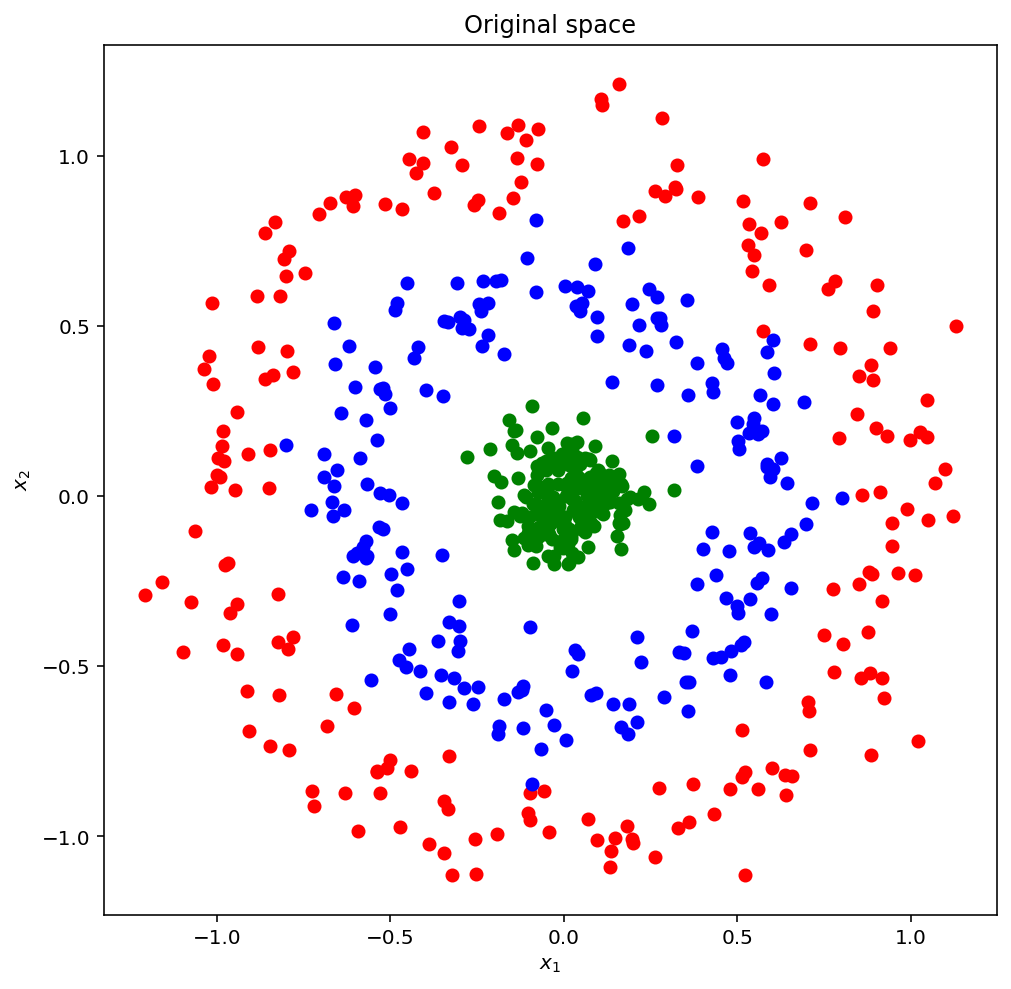

In [32]:
from sklearn.datasets import make_circles, make_moons

np.random.seed(0)
Xcc, Ycc = make_circles(n_samples=400, factor=.6, noise=.1)

X_c2 = 0.1*np.random.randn(200,2)
Y_c2 = 2*np.ones((200,))

Xcir= np.vstack([Xcc,X_c2])
Ycir= np.hstack([Ycc,Y_c2])

plt.figure(figsize=(8,8))
plt.title("Original space")
reds = Ycir == 0
blues = Ycir == 1
green = Ycir == 2

plt.plot(Xcir[reds, 0], Xcir[reds, 1], "ro")
plt.plot(Xcir[blues, 0], Xcir[blues, 1], "bo")
plt.plot(Xcir[green, 0], Xcir[green, 1], "go")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


In [33]:
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
import scipy

In [34]:
def  KDA(Xcir, Ycir, kernel='rbf', gamma = 5, degree=3):
    N = Xcir.shape[0]
    if kernel=='poly':
        K = polynomial_kernel(Xcir,  degree=degree)
    else:
        K = rbf_kernel(Xcir, gamma=gamma)
    H = np.empty((3,N))
    for clase in range(3):
        H[clase,:] = np.mean(K[Ycir==clase,:],0)
    h = np.mean(K,0)
    Sb = np.zeros((N,N))
    Sw = np.zeros((N,N))
    for clase in range(3):
        Hh = H[clase,:] -h
        nc = np.sum(Ycir==clase)
        Sb += nc *np.outer(Hh, Hh.T)
        Km = K[Ycir==clase,:] - np.outer(np.ones(nc),H[clase,:])
        for gg in range(nc):
            Sw += np.outer(Km[gg,:].T, Km[gg,:])

    autovalores, autovectores = scipy.linalg.eigh(Sb, Sw+1e-6*np.eye(N))
    B = autovectores[:,-2:].T
    Z = K.dot(B.T)
    return B, Z

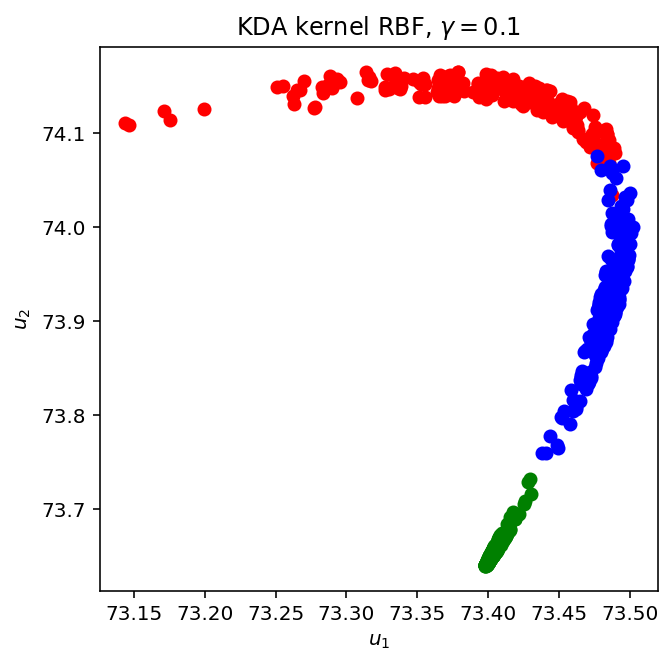

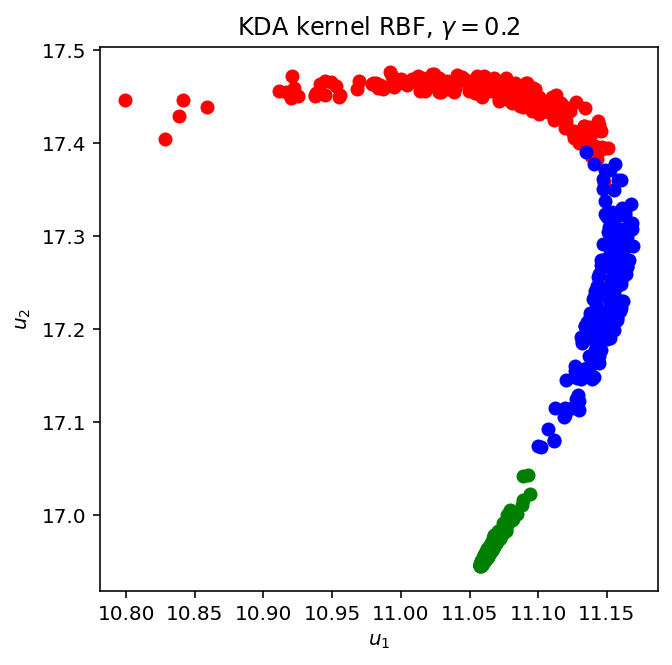

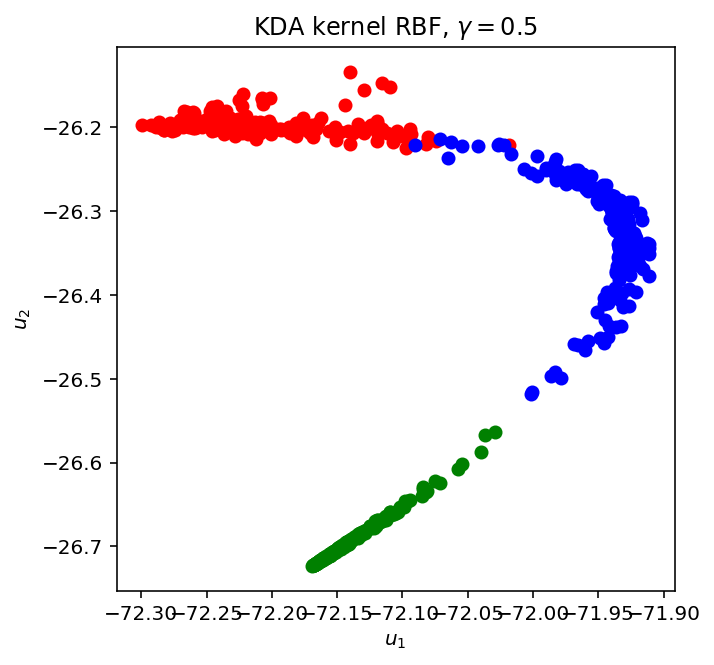

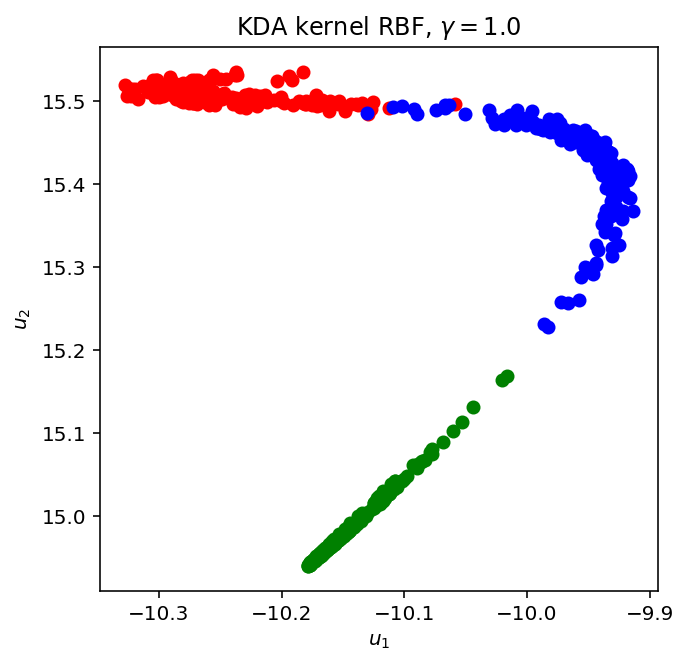

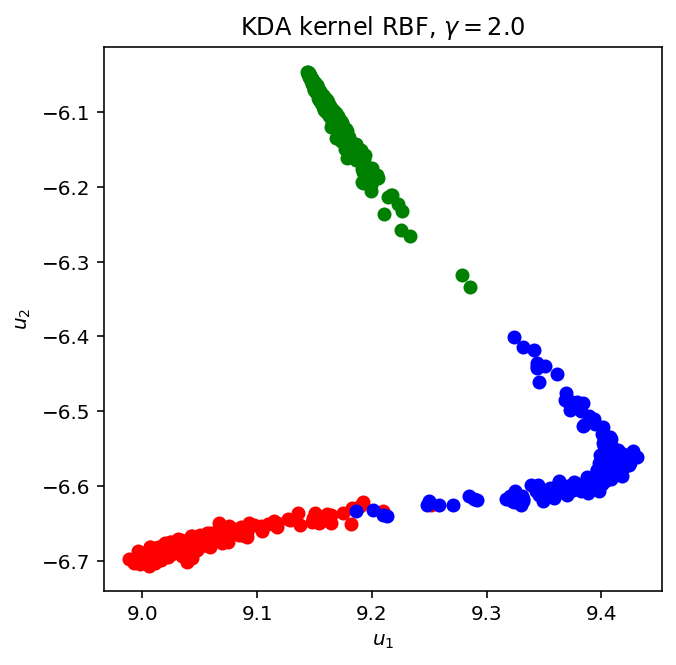

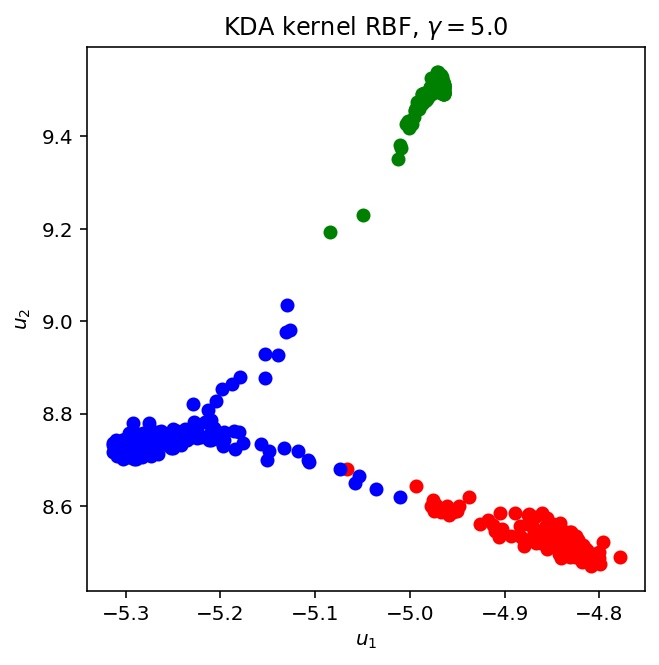

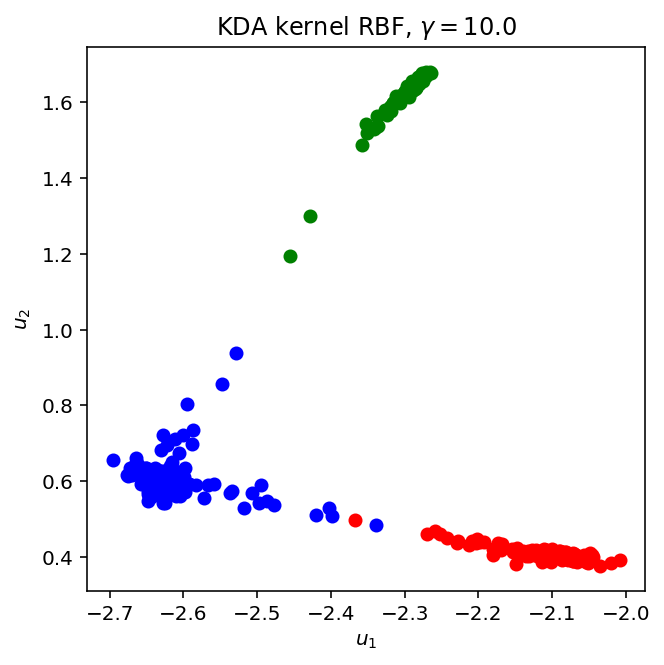

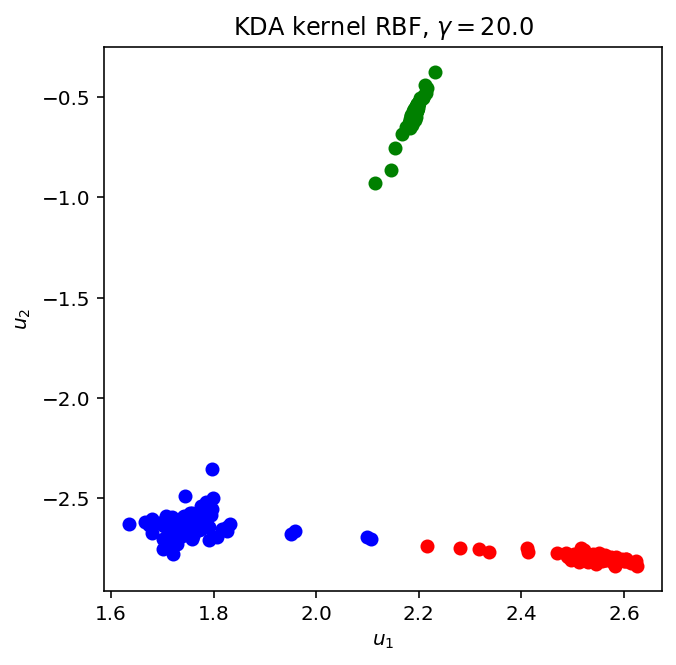

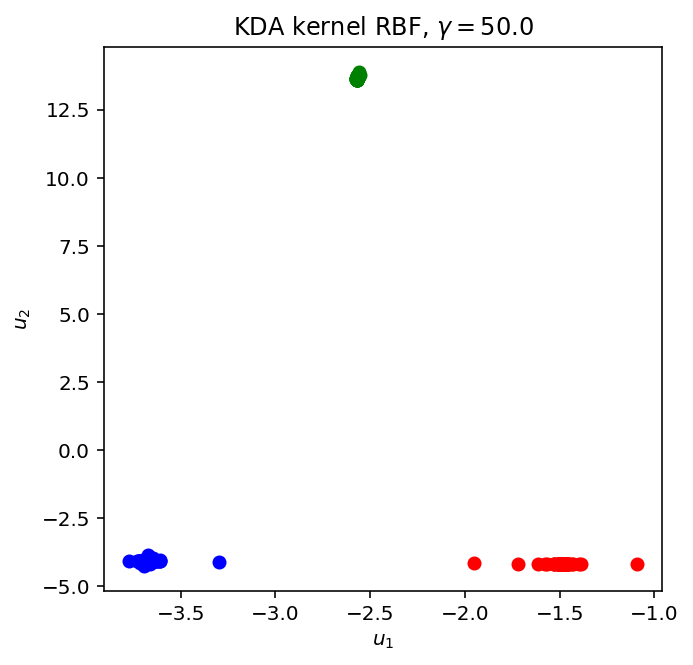

In [35]:
for gamma_value in [.1,.2,.5,1,2,5,10,20,50]:
    B,Pk_ = KDA(Xcir, Ycir, gamma = gamma_value)
    plt.figure(figsize=(5,5))
    plt.plot(Pk_[reds, 0], Pk_[reds, 1], "ro")
    plt.plot(Pk_[blues, 0], Pk_[blues, 1], "bo")
    plt.plot(Pk_[green, 0], Pk_[green, 1], "go")
    plt.xlabel("$u_1$")
    plt.ylabel("$u_2$")
    plt.title('KDA kernel RBF, $\gamma={0:.1f}$'.format(gamma_value))
    plt.show()

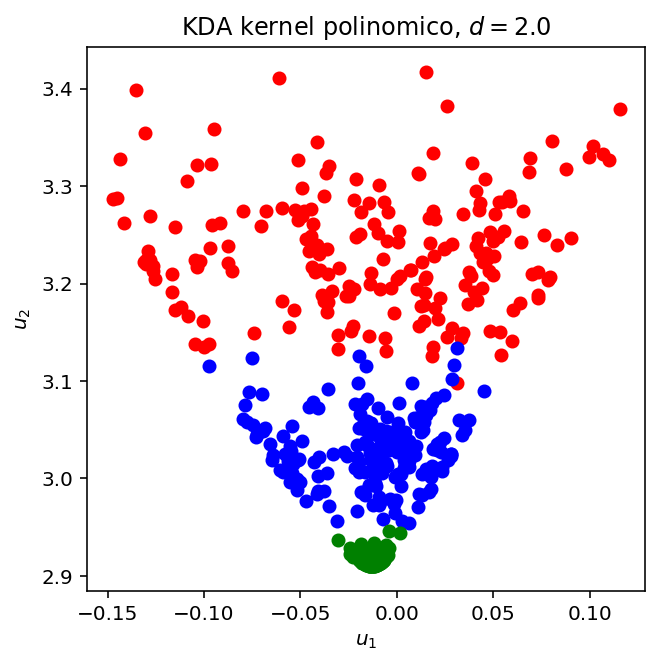

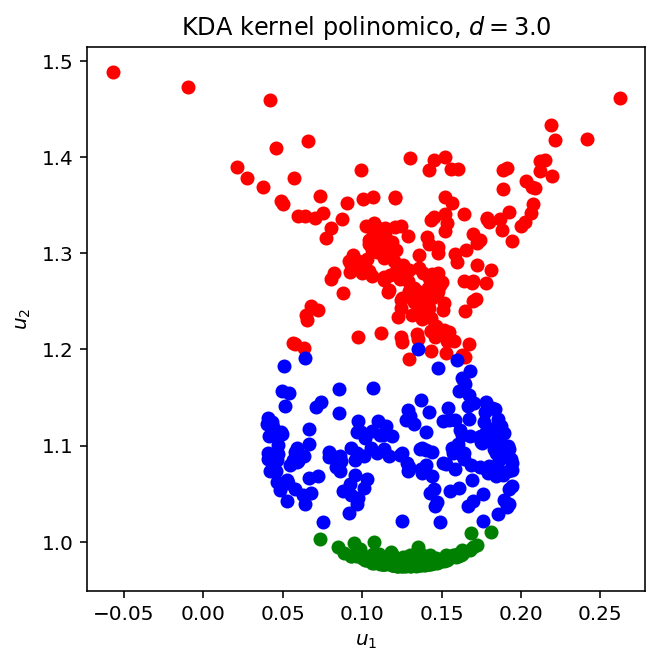

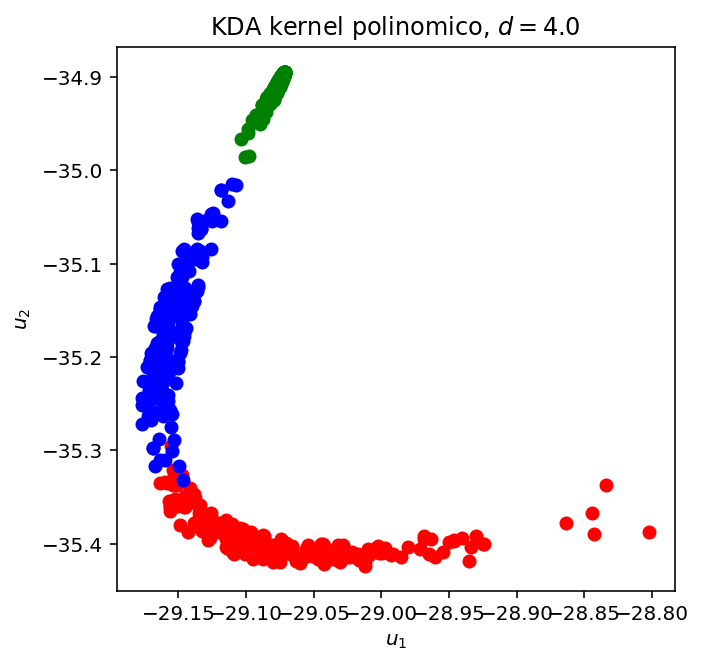

In [36]:
for d_value in [2,3,4]:
    B,Pk_ = KDA(Xcir, Ycir, degree = d_value,kernel='poly')
    plt.figure(figsize=(5,5))
    plt.plot(Pk_[reds, 0], Pk_[reds, 1], "ro")
    plt.plot(Pk_[blues, 0], Pk_[blues, 1], "bo")
    plt.plot(Pk_[green, 0], Pk_[green, 1], "go")
    plt.xlabel("$u_1$")
    plt.ylabel("$u_2$")
    plt.title('KDA kernel polinomico, $d={0:.1f}$'.format(d_value))
    plt.show()

# 3. CCA: *Canonical Correlation Analysis* 

Hasta ahora nos hemos centrado en buscar estructuras tipo *manifold* en el espacio de entrada, donde viven las **observaciones** $\mathbf x_i$:

- En PCA y Regresión en Componentes Principales aprendemos una proyección a un espacio de menor dimensión que es óptimo para reconstruir los datos con el menor error posible

- En el *Linear Discriminant Analysis* el espacio reducido maximiza la separabilidad entre las clases, es decir, se centra en aquellas componentes que recogen las diferencias más notables entre los ejemplos de cada clase

- En *Partial Least Squares* capturamos aquellas componentes principales más correlacionadas con la variable *target*, es decir, seleccionamos las componentes que nos ayudan a hacer mejor la regresión del target con las observaciones.



Dentro del aprendizaje automático cada vez está ganando más foco lo que se conoce como **aprendizaje con múltiples vistas**. Esto es, de cada objeto podemos disponer de diferentes juegos de observaciones. Escenarios claros que se benefician este paradigma

- **Procesamiento multimedia**. Si tenemos un conjunto de entrenamiento formado por *clips* de vídeo, para cada *clip* podemos tener:
    - La secuencia de *frames* de vídeo, es decir, para cada pixel de la pantalla tenemos una secuencia con los colores que ha tomado ese pixel durante cada frame del clip
    - La señal de audio (voces, música, ruidos, etc)
    - El texto (si es que los personajes del vídeo hablan durante el mismo)
    - Metadatos como *tags*, comentarios de usuarios, *likes*, geolocalización de las imágenes, etc
    
- **Aplicaciones médicas**. Por ejemplo en una aplicación de diagnóstico de enfermedades mentales podemos disponer, para cada paciente (o sujeto de control) del estudio clínico
    - resultados de tests psicológicos (papel y boli)
    - imágenes de resonancia magnética estructural
    - resonancias magnéticas funcionales (señales que se propagan en el tiempo)
    - expresiones genéticas del paciente
    - analíticas (hormonas, etc)
    
- **Traducción automática**. Tenemos colecciones de textos donde un mismo documento aparece redactado en diferentes idiomas. Cada idioma es una vista de ese documento.

CCA (*Canonical Correlation Analysis*) es un método para explorar relaciones entre dos conjuntos de variables, ambos medidos sobre un mismo objeto. En cierto modo podemos verlo como una generalización de la regresión multivariante al caso en el que los *targets* son vectores también y en el que *targets* y observaciones están en el mismo plano.

La motivación de CCA es poder analizar conjuntamente los dos juegos de variables para detectar interdependencias e interacciones entre ellos. 

### Ejemplo: estudio sobre vendedores de una compañía

Una compañía realiza un estudio para ver qué factores influyen más decisivamente en los resultados de sus vendedores. Para ello analizan dos juegos de variables medidas para cada vendedor:
- Resultados de sus ventas del último año:
    - V1: Crecimiento de sus ventas
    - V2: Rentabilidad
    - V3: Nuevas cuentas
- Resultados de test que miden sus competencias:
    - T1: Creatividad
    - T2: Razonamiento mecánico
    - T3: Razonamiento abstracto
    - T4: Matemáticas

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [38]:
X = np.loadtxt('sales.txt')
sc = StandardScaler()
Xs = sc.fit_transform(X)

In [39]:
ventas = pd.DataFrame(X, columns=['V1', 'V2', 'V3', 'T1', 'T2', 'T3', 'T4'])
ventas_s = pd.DataFrame(Xs, columns=['V1', 'V2', 'V3', 'T1', 'T2', 'T3', 'T4'])

In [40]:
ventas.head()

V1     V2     V3    T1    T2    T3    T4
0   93.0   96.0   97.8   9.0  12.0   9.0  20.0
1   88.8   91.8   96.8   7.0  10.0  10.0  15.0
2   95.0  100.3   99.0   8.0  12.0   9.0  26.0
3  101.3  103.8  106.8  13.0  14.0  12.0  29.0
4  102.0  107.8  103.0  10.0  15.0  12.0  32.0

In [41]:
ventas.describe()

V1          V2          V3         T1        T2         T3  \
count   50.000000   50.000000   50.000000  50.000000  50.00000  50.000000   
mean    98.836000  106.622000  102.810000  11.220000  14.18000  10.560000   
std      7.337345   10.124315    4.712218   3.950149   3.38478   2.139617   
min     81.500000   87.300000   94.300000   1.000000   5.00000   5.000000   
25%     93.550000   99.500000   99.075000   8.250000  12.00000   9.000000   
50%    100.650000  106.250000  103.150000  10.000000  15.00000  11.000000   
75%    105.050000  114.750000  106.450000  14.000000  17.00000  12.000000   
max    110.800000  122.300000  115.300000  18.000000  20.00000  15.000000   

              T4  
count  50.000000  
mean   29.760000  
std    10.537707  
min     9.000000  
25%    21.500000  
50%    31.500000  
75%    37.000000  
max    51.000000

In [42]:
ventas_s.head()

V1        V2        V3        T1        T2        T3        T4
0 -0.803458 -1.059809 -1.073988 -0.567710 -0.650598 -0.736505 -0.935601
1 -1.381684 -1.478864 -1.288356 -1.079160 -1.247478 -0.264386 -1.414905
2 -0.528113 -0.630777 -0.816745 -0.823435 -0.650598 -0.736505 -0.360436
3  0.339226 -0.281565  0.855332  0.455191 -0.053719  0.679851 -0.072854
4  0.435597  0.117535  0.040730 -0.311985  0.244721  0.679851  0.214728

In [43]:
V = ventas_s.loc[:,['V1','V2','V3']].values
T = ventas_s.loc[:,['T1','T2','T3','T4']].values

En primer lugar vamos a explorar si hay relaciones entre los juegos de variables con las herramientas que hemos usado hasta ahora. Podemos comprobar si es posible hace un modelo de regresión de las variables de los resultados de ventas con las variables de las competencias.

In [44]:
for ii in range(3):
    lr = LinearRegression().fit(T,V[:,ii])
    print('variable V{0:d}, R^2={1:.2f}'.format(ii+1,lr.score(T,V[:,ii])))
    print('termino sesgo {0:.2f}'.format(lr.intercept_))
    for jj in range(4):
        print('  variable T{0:d}, peso={1:.2f}'.format(jj+1,lr.coef_[jj]))
    print("")

variable V1, R^2=0.96
termino sesgo -0.00
  variable T1, peso=0.19
  variable T2, peso=0.14
  variable T3, peso=0.23
  variable T4, peso=0.64

variable V2, R^2=0.97
termino sesgo -0.00
  variable T1, peso=0.05
  variable T2, peso=0.29
  variable T3, peso=-0.12
  variable T4, peso=0.83

variable V3, R^2=0.93
termino sesgo -0.00
  variable T1, peso=0.48
  variable T2, peso=-0.06
  variable T3, peso=0.30
  variable T4, peso=0.52



En este análisis podemos ver la influencia de cada uno de los factores presentes en las competencias dentro de cada una de las variables de los resultados. Pero podemos perder intuiciones acerca de:

- Correlaciones entre los resultados de ventas. El análisis que hemos hecho trata a cada resultado de ventas **independiente del resto**.
- Correlaciones entre las competencias que están decisivamente conectadas con los resultados de las ventas.

Precisamente CCA sirve para **resumir** las interdependencias entre los dos juegos de variables pues permite:
- Estudiar las variables de resultados de ventas de un modo conjunto
- Identificar las componentes de las variables de las competencias que **están alineadas con la explicación de los resultados de ventas**. Esto nos va a permitir ser ambiciosos en la fase de toma de datos y no exponernos a un efecto **maldición de la dimensionalidad** por alimentar el modelo con información que no sea relevante para explicar la tarea en cuestión.

## Formulación de CCA

Partimos de dos vistas del mismo conjunto de objetos: $\mathbf x_i \in \mathbb R^p$ e $\mathbf y_i \in\mathbb R^s$. Las observaciones correspondientes a las vistas están pareadas en el sentido de que $(\mathbf x_i, \mathbf y_i)$ pertenecen al mismo objeto.

El objetivo de CCA es encontrar una dirección de proyección $\mathbf w \in \mathbb R^p$ y otra dirección $\mathbf v \in \mathbb R^s$ tales que la correlación entre la variable resultante de proyectar la vista $\mathbf x_i$ con $\mathbf w$ y la variable resultante de proyectar la vista $\mathbf y_i$ con $\mathbf v$ sea máxima.

Dadas dos variables aleatorias $x$ e $y$ con medias nulas, se define su **correlación** como

$$
\mathbf{corr}(x,y)= \frac{\mathbb E[xy]}{\sqrt{\mathbb E[xx] \mathbb E[yy]}} = \frac{\mbox{cov}(x,y)}{\sqrt{\mbox{var}(x)}\sqrt{\mbox{var}(y)}}
$$

Proyectar la vista $\mathbf x$ con $\mathbf w$ transforma la variable vectorial $\mathbf x$ en un escalar $x=\mathbf w^\top \mathbf x$. Análogamente la variable original $\mathbf y$ se convertirá en $y = \mathbf v^\top\mathbf y$

Para maximizar la correlación de las variables resultantes de las proyecciones escribimos el siguiente problema de optimización:

$$
\max \frac{\mathbb E[xy]}{\sqrt{\mbox{var}(x)}\sqrt{\mbox{var}(y)}}
$$

Si asumimos media nula para las observaciones independientemente de la vista que estemos contemplando:

$$
\max_{\mathbf w, \mathbf v} \frac{\mathbb E[xy]}{\sqrt{\mathbb E [x^2]}\sqrt{\mathbb E [y^2]}}
$$

$$
= \max_{\mathbf w, \mathbf v} \frac{\mathbb E[\mathbf w^\top \mathbf x \mathbf y^\top \mathbf v]}{\sqrt{\mathbb E [\mathbf w^\top \mathbf x \mathbf x^\top \mathbf w]}\sqrt{\mathbb E [\mathbf v^\top \mathbf y \mathbf y^\top \mathbf v]}}
$$

$$
= \max_{\mathbf w, \mathbf v} \frac{\mathbf w^\top \mathbb E[ \mathbf x \mathbf y^\top]\mathbf v}{\sqrt{\mathbf w^\top \mathbb E [ \mathbf x \mathbf x^\top ]\mathbf w}\sqrt{\mathbf v^\top\mathbb E [ \mathbf y \mathbf y^\top ]\mathbf v}}
$$

$$
= \max_{\mathbf w, \mathbf v} \frac{\mathbf w^\top C_{x,y}\mathbf v}{\sqrt{\mathbf w^\top C_{xx}\mathbf w}\sqrt{\mathbf v^\top C_{yy}\mathbf v}}
$$

donde las matrices de covarianzas $C_{x,y}$, $C_{xx}$ y $C_{yy}$ se estiman a partir de las observaciones del conjunto de entrenamiento como:

$$
C_{xx} = \frac{1}{N}\sum_{i=1}^N{(\mathbf x_i - \mathbf m_x)(\mathbf x_i - \mathbf m_x)^\top}
$$

$$
C_{yy} = \frac{1}{N}\sum_{i=1}^N{(\mathbf y_i - \mathbf m_y)(\mathbf y_i - \mathbf m_y)^\top}
$$

$$
C_{x,y} = \frac{1}{N}\sum_{i=1}^N{(\mathbf x_i - \mathbf m_x)(\mathbf y_i - \mathbf m_y)^\top}
$$

y donde $\mathbf m_x$ y $\mathbf m_y$ son los vectores con las medias en ambos juegos de variables

$$
\mathbf m_x = \frac{1}{N}\sum_{i=1}^N{\mathbf x_i}
$$

$$
\mathbf m_y = \frac{1}{N}\sum_{i=1}^N{\mathbf y_i}
$$

### Resolución de la optimización

Como estamos únicamente interesados en las direcciones de los vectores de proyección $\mathbf w$ y $\mathbf v$ y no en sus normas, podemos imponer las restricciones

$$
\mathbf w^\top C_{xx}\mathbf w = 1
$$

y

$$
\mathbf v^\top C_{yy}\mathbf v = 1
$$

y resolver

$$
\max_{\mathbf w, \mathbf v} \mathbf w^\top C_{x,y}\mathbf v
$$

sujeto a

$$
\mathbf w^\top C_{xx}\mathbf w = 1 \mbox{ y } \mathbf v^\top C_{yy}\mathbf v = 1
$$

Para resolver la optimización introducimos las restricciones mediante dos multiplicadores de Lagrange $\lambda_x$ y $\lambda_y$

$$
\max_{\mathbf w, \mathbf v} \mathbf w^\top C_{x,y}\mathbf v - \lambda_x(\mathbf w^\top C_{xx}\mathbf w - 1) - \lambda_y(\mathbf v^\top C_{yy}\mathbf v-1)
$$

Igualando a cero los gradientes con respecto a $\mathbf w$ y $\mathbf v$ llegamos al siguiente sistema de ecuaciones

$$
\left \{ \begin{array}{lcl} C_{x,y}\mathbf v - \lambda_x C_{xx}\mathbf w &=& \mathbf 0 \\ C_{x,y}^{\top}\mathbf w - \lambda_y C_{yy}\mathbf v &=& \mathbf 0\end{array}\right.
$$

Multiplicando la ecuación de arriba por $\mathbf w^\top$ y la de abajo por $-\mathbf v^\top$ y sumando las ecuaciones

$$
\lambda_y \mathbf v^\top  C_{yy}\mathbf v - \lambda_x \mathbf w^\top C_{xx}\mathbf w = 0
$$

aplicando las restricciones se llega a que $\lambda_y = \lambda_x$. Usamos $\lambda$ para unificar ambos valores y volvemos al sistema

$$
\left \{ \begin{array}{lcl} C_{x,y}\mathbf v   &=& \lambda C_{xx}\mathbf w \\ C_{x,y}^{\top}\mathbf w  &=&  \lambda C_{yy}\mathbf v\end{array}\right.
$$

Que puede expresarse en forma matricial como

$$
\left [\begin{array}{cc} 0 & C_{x,y} \\ C_{y,x} & 0 \end{array}\right ] \left [\begin{array}{c} \mathbf w \\ \mathbf v \end{array}\right ] = \lambda \left[\begin{array}{cc} C_{x,x} & 0  \\ 0  & C_{y,y} \end{array}\right ]\left [\begin{array}{c} \mathbf w \\ \mathbf v \end{array}\right ] 
$$

Esta última expresión se conoce como **problema generalizado de autovalores**. Los autovectores solución de este problema con mayor autovalor forman las direcciones de proyección que maximizan la correlación entre los dos juegos de variables. 

Cada **autovector** solución de este problema se descompone en dos partes, la primera marca una dirección de proyección para la vista $\mathbf x$, mientras que la segunda es la dirección de proyección acoplada para la vista $\mathbf y$.

### CCA en el ejemplo de los datos de ventas

La clase [CCA](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html) implementa el *Canonical Correlation Analysis* en *scikit learn*. Tiene los métodos habituales `fit`, `fit_transform` y `transform`.

In [45]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=3).fit(T,V)

In [46]:
Tx, Vy = cca.transform(T,V)

In [47]:
Tx.shape

(50, 3)

In [48]:
Vy.shape

(50, 3)

Las siguientes figuras muestran las correlaciones entre las componentes encontradas por CCA para cada vista. Las dos primeras componentes están altamente correlacionadas, las segundas un poco menos y las terceras componentes no parece guardar correlación.

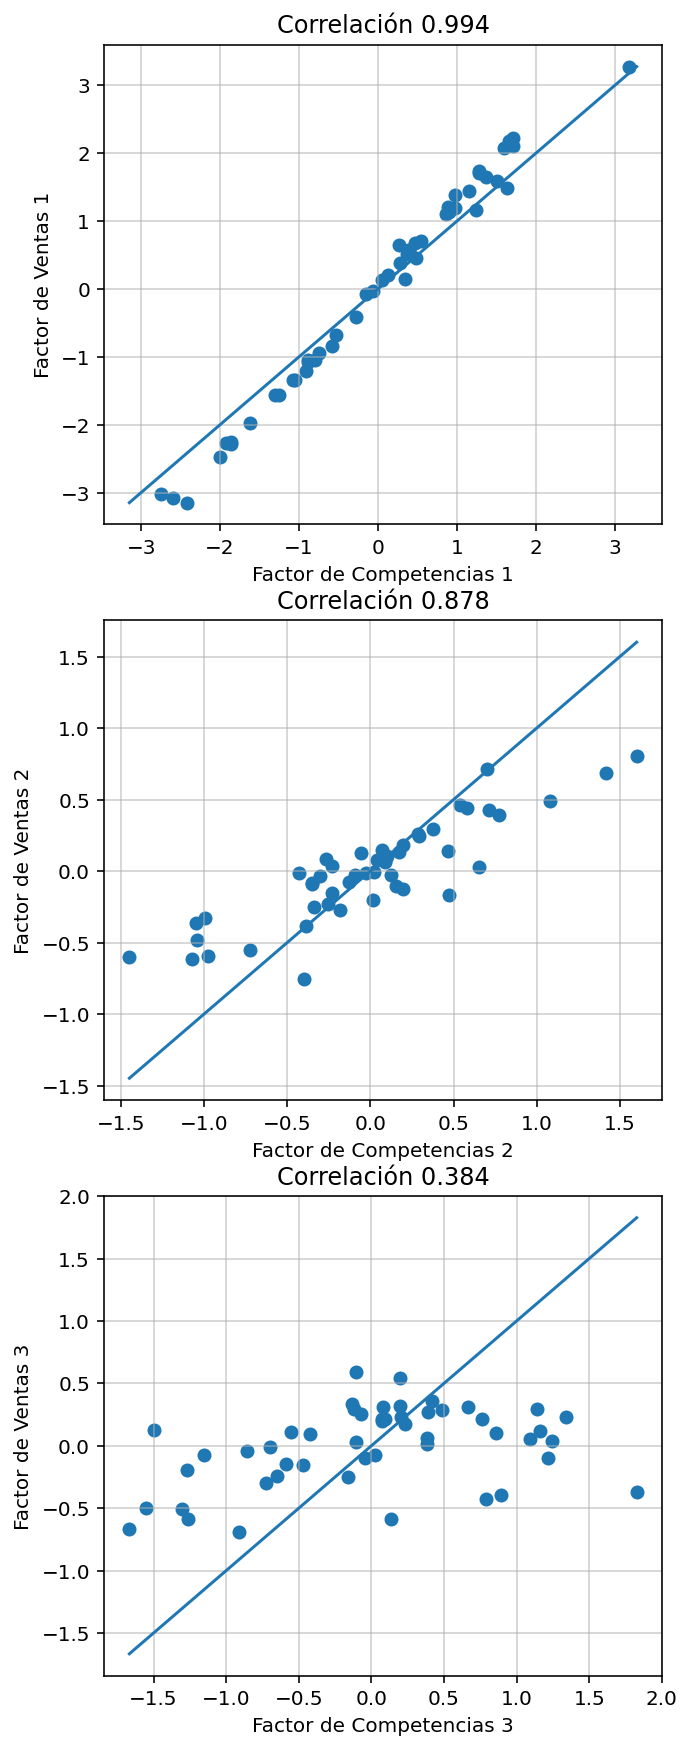

In [49]:
ff,aa = plt.subplots(3,1, figsize=(5,15))
for ii  in range(3):
    aa[ii].scatter(Tx[:,ii], Vy[:,ii])
    aa[ii].set_xlabel('Factor de Competencias {0:d}'.format(ii+1))
    aa[ii].set_ylabel('Factor de Ventas {0:d}'.format(ii+1))
    aa[ii].plot([np.min(np.hstack((Tx[:,ii], Vy[:,ii]))), np.max(np.hstack((Tx[:,ii], Vy[:,ii])))],
               [np.min(np.hstack((Tx[:,ii], Vy[:,ii]))), np.max(np.hstack((Tx[:,ii], Vy[:,ii])))])
    aa[ii].set_title('Correlación {0:.3f}'.format(np.corrcoef(Tx[:,ii], Vy[:,ii])[0,1]))
    aa[ii].grid(alpha=0.6)

Influencia de cada variable original en cada componente canónica. 

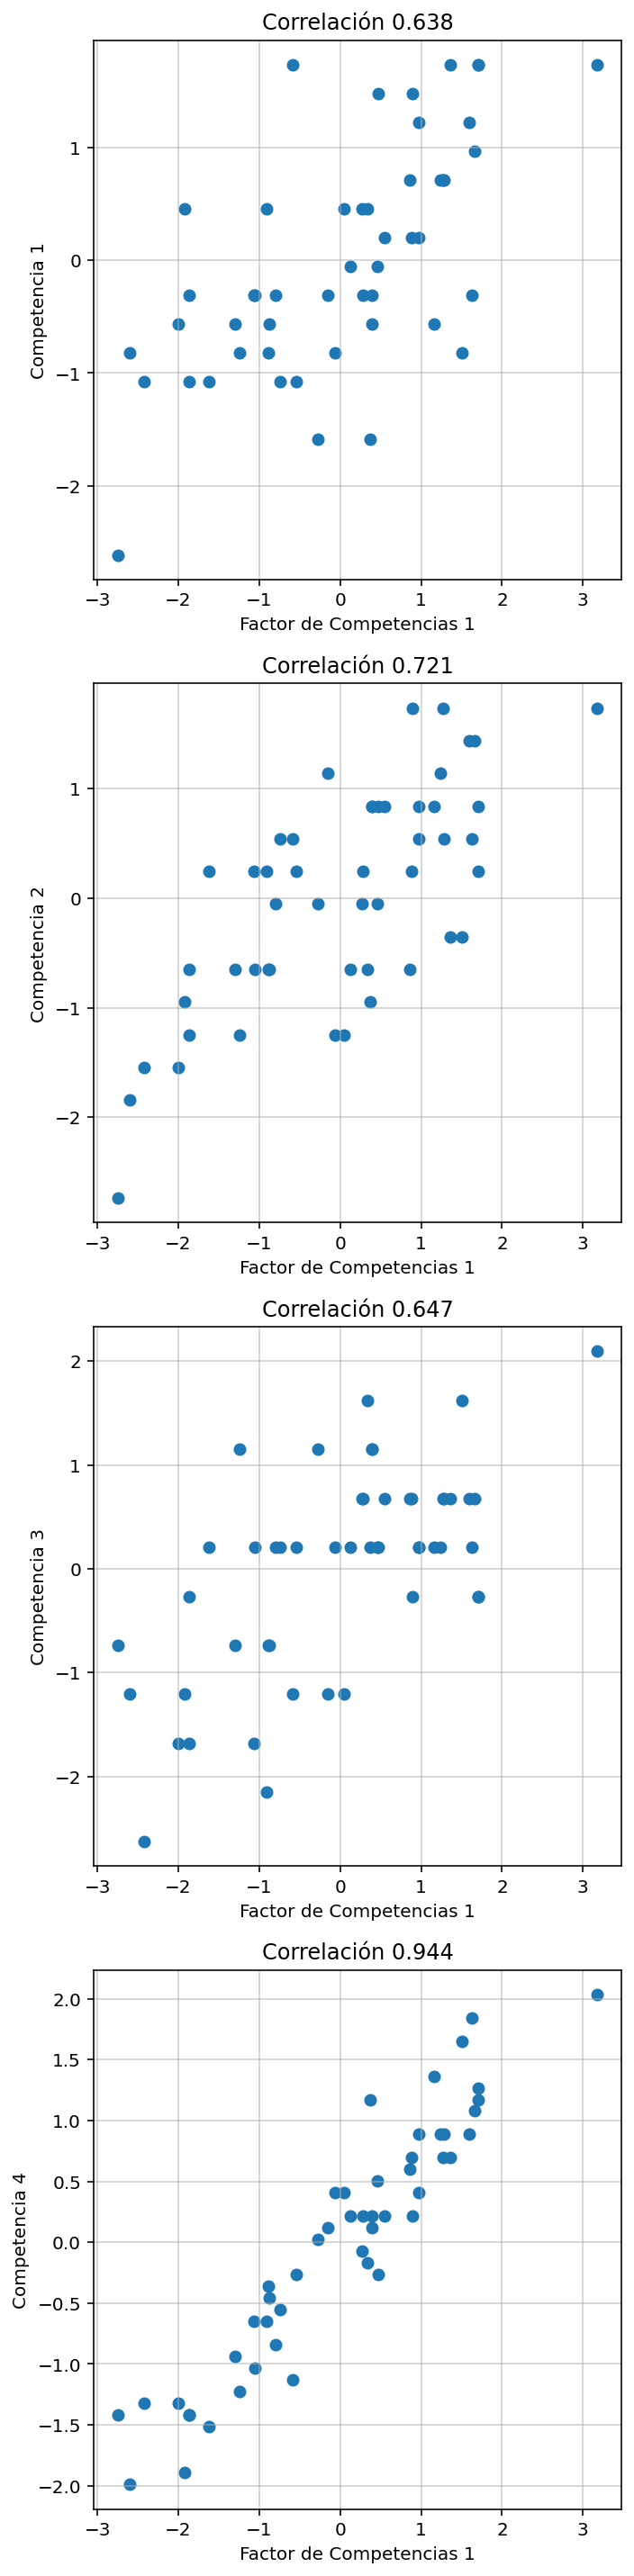

In [50]:
ff,aa = plt.subplots(4,1, figsize=(5,20))
for ii  in range(4):
    aa[ii].scatter(Tx[:,0], T[:,ii])
    aa[ii].set_xlabel('Factor de Competencias {0:d}'.format(1))
    aa[ii].set_ylabel('Competencia {0:d}'.format(ii+1))
    aa[ii].set_title('Correlación {0:.3f}'.format(np.corrcoef(Tx[:,0], T[:,ii])[0,1]))
    aa[ii].grid(alpha=0.6)
ff.tight_layout()

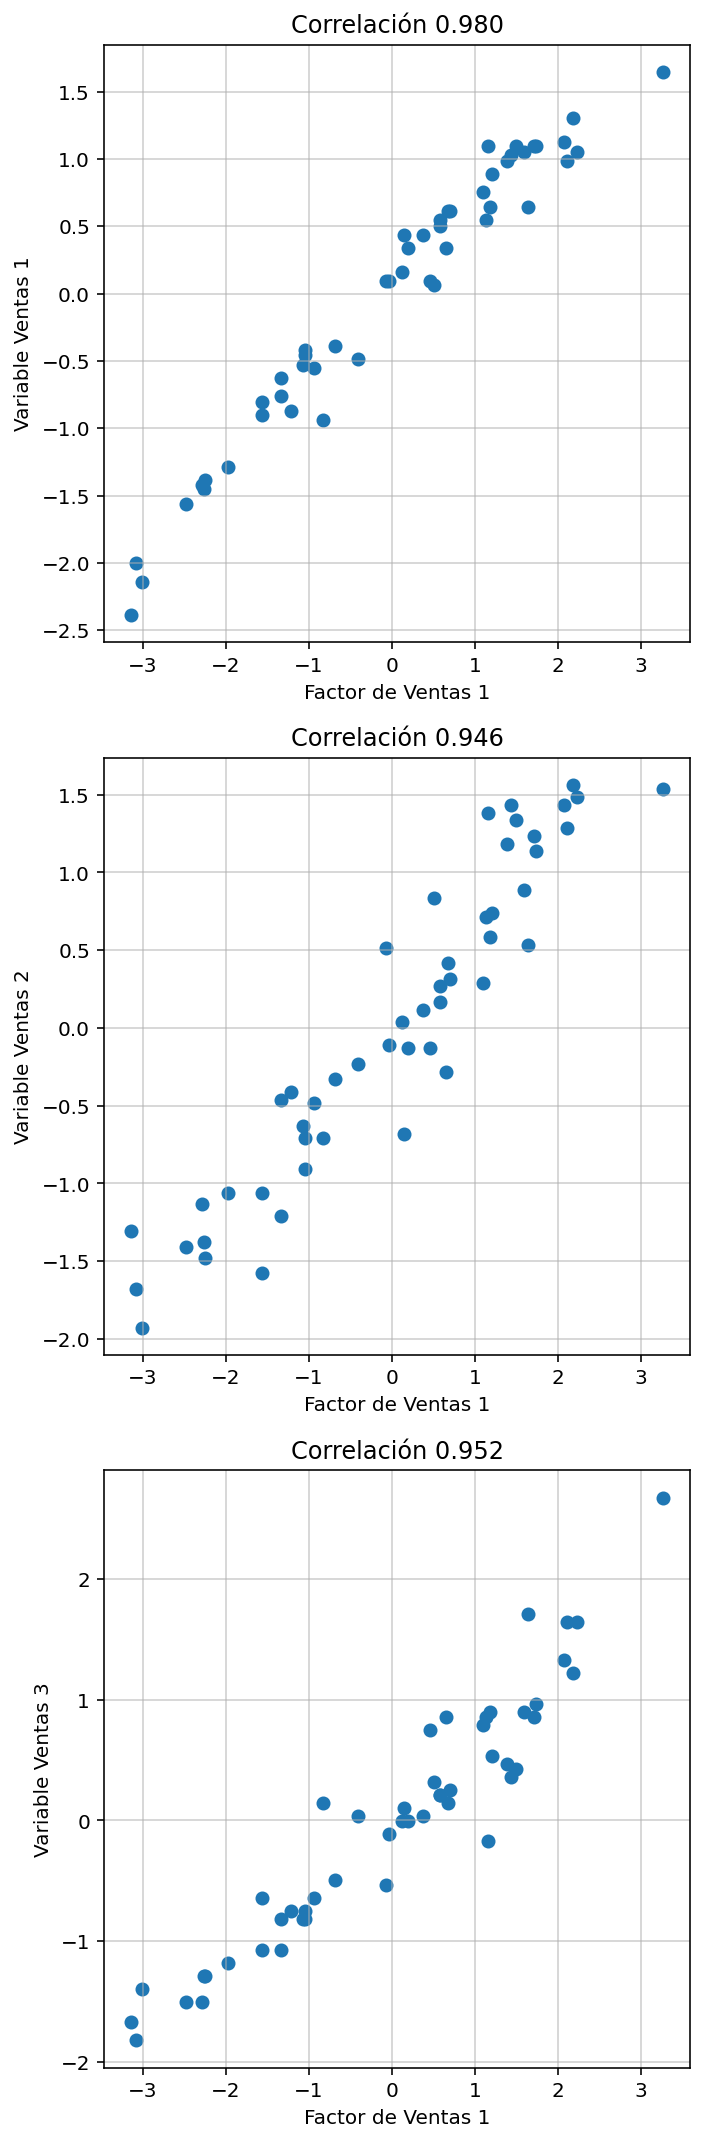

In [51]:
ff,aa = plt.subplots(3,1, figsize=(5,15))
for ii  in range(3):
    aa[ii].scatter(Vy[:,0], V[:,ii])
    aa[ii].set_xlabel('Factor de Ventas {0:d}'.format(1))
    aa[ii].set_ylabel('Variable Ventas {0:d}'.format(ii+1))
    aa[ii].set_title('Correlación {0:.3f}'.format(np.corrcoef(Vy[:,0], V[:,ii])[0,1]))
    aa[ii].grid(alpha=0.6)
ff.tight_layout()

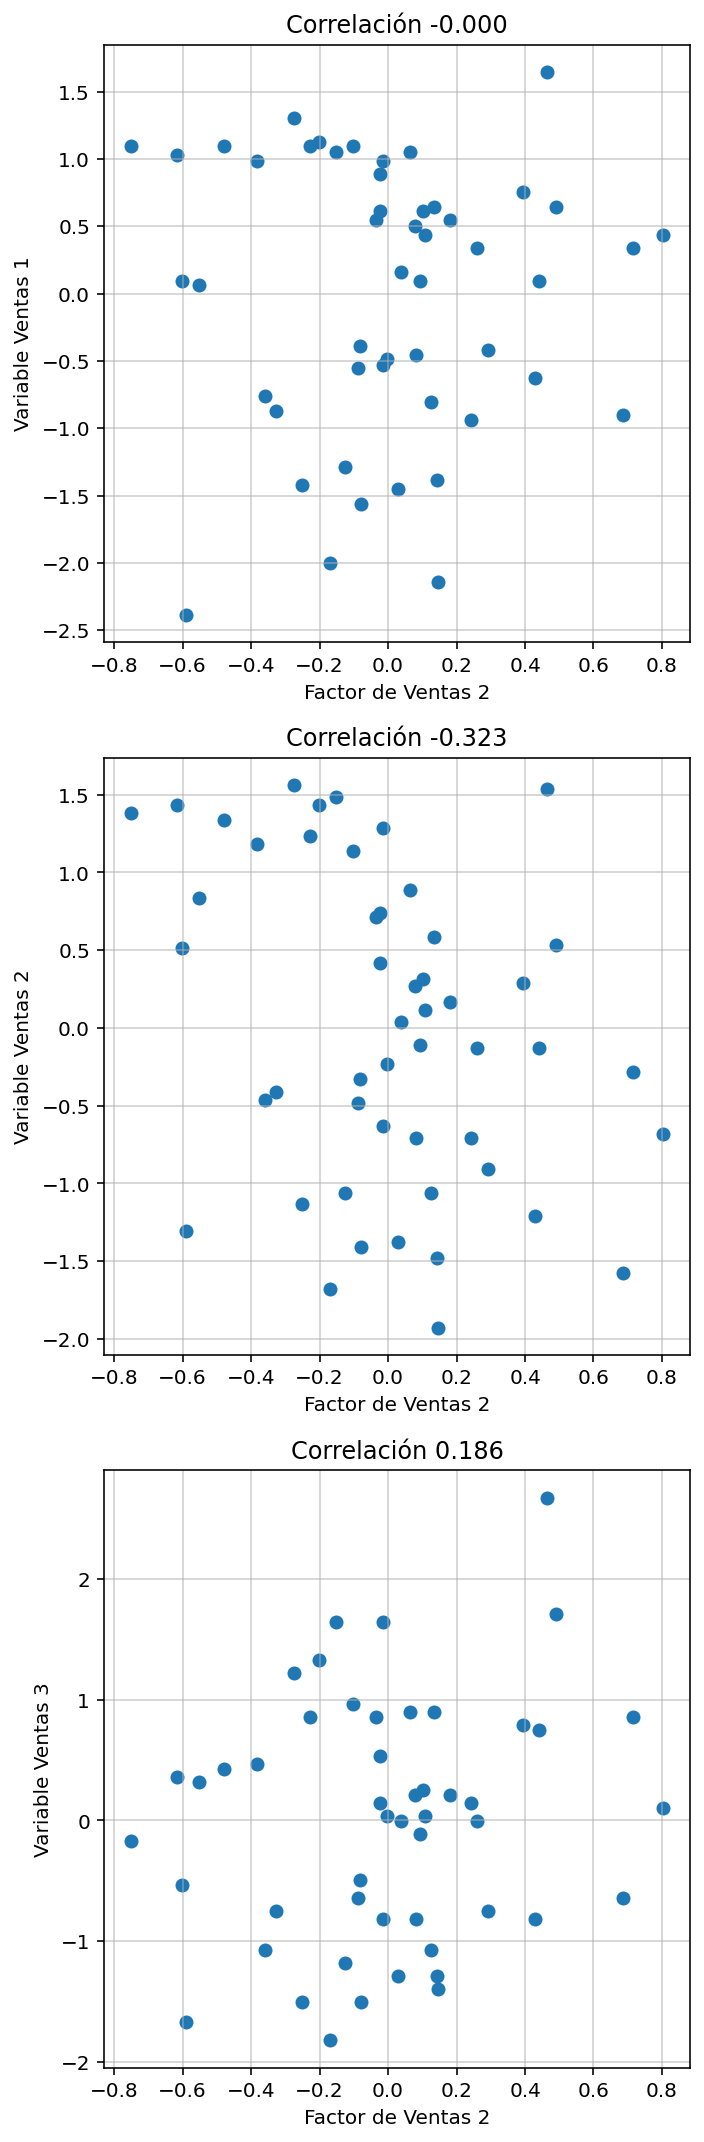

In [52]:
ff,aa = plt.subplots(3,1, figsize=(5,15))
for ii  in range(3):
    aa[ii].scatter(Vy[:,1], V[:,ii])
    aa[ii].set_xlabel('Factor de Ventas {0:d}'.format(2))
    aa[ii].set_ylabel('Variable Ventas {0:d}'.format(ii+1))
    aa[ii].set_title('Correlación {0:.3f}'.format(np.corrcoef(Vy[:,1], V[:,ii])[0,1]))
    aa[ii].grid(alpha=0.6)
ff.tight_layout()

Haber aprendido las dos proyecciones $\mathbf w$ y $\mathbf v$ acopladas nos permite la construcción de un subespacio común donde poder mapear objetos de los que solo tengamos una de las vistas. 

Por ejemplo, si contratamos un vendedor nuevo que tenga como vectores de competencias
- Creatividad: 15
- Razonamiento mecánico: 6
- Razonamiento abstracto: 12
- Matemáticas: 23

Empleando CCA podemos predecir cuál serán sus scores de performance en ventas

In [53]:
xt = np.array([15., 6., 12., 23.])

# quick&dirty hack para escalar xt
xtt = np.hstack((np.zeros(3), xt)).reshape(1,-1)
xt_s = sc.transform(xtt)[:,3:]

Vt = cca.predict(xt_s)

In [54]:
Vt

array([[-1.09889257, -2.24398453,  2.00732587]])

Text(0.5, 0, 'Score Ventas 1')

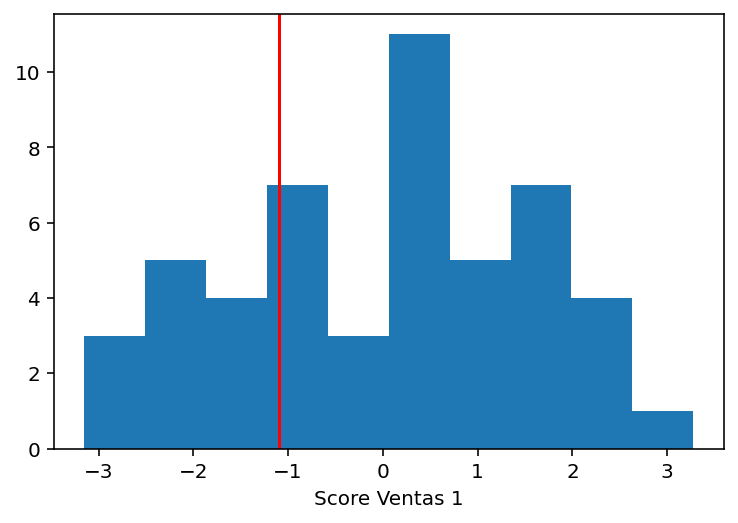

In [55]:
ff,aa = plt.subplots(1,1, figsize=(6,4))
aa.hist(Vy[:,0],10)
aa.axvline(x=Vt[0,0], color='red')
aa.set_xlabel('Score Ventas {0:d}'.format(1))

El algoritmo CCA también admite versión con kernels pero no está implementada en scikit learn de momento.